# Predicting Cytokine Response from Images - Part 2!

#Introduction

This is a follow-up to a previous project which used image embeddings (1230 features) as input for an xgboost model to predict binarized cytokine readouts. The goal of this work is to determine whether production of any cytokines can be predicted from images of the cell membranes.

This time, I compare a CNN and a Vit model to see which cytokines are "predictable" with those models. Predictable here is defined as either having max validation accuracy >0.65 or precision and recall >0.65. Each cytokine gets its own CNN and its own Vit model.

Furthermore, I employ some basic augmentation methods to see if that improves CNN performance. Namely, I employ horizontal flips, vertical flips, and transpositions. I combine these augmented data sets to see if performing all augmentations is beneficial, or if the returns diminish beyond a certain number of augmentations.

I also check for evidence of overfitting with the CNN models.

For the ViT models, I fine tune a ViTb32 pretrained model with the full suite of augmented images per cytokine to see if any cytokines are predictable.

#The Problem
How many cytokines are predictable with CNNs and fine-tuned ViTb32? Does including image augmentation cause more cytokines to be predictable with CNNs or improve accuracy?

#The Data
384 64px X 64px tifs of images of the cell membranes ("features") were used as input for the models.

Pixel values of these images were min/maxed to 0 and 1. This is important to keep gradient descent steps consistently appropriate. (ie, dimmer images could suffer from very large gradient descent steps taken because of some bright pixels in the training set.)

Array shapes were also handled to be compatible with tensorflow and the ViT architecture. (The ViT expects RGB, so this single channel was repeated 3 times.)

The cytokine responses ("targets") were normalized to a negative control and z scored per donor, then binarized into "1" (production) or "0" (no production.) These classes were balanced to equal proportion and cytokines with fewer than 5 producing wells were dropped from the experiment. This means that random chance would result in accuracy or precision/recall of about 0.5. Therefore 0.65 is chosen as the cutoff for initial predictability.

The images and the cytokine readouts are indexed on a per-well basis. (Meaning the images are not crops of only one cell. They are images of several cells in the well.) This is important to note because multiple cells contribute to cytokine production, so crops of single cells would not be an appropriate input.


#Results

##Cytokine Predictability

The CNNs and ViT models did not perform as well as the previous approach based on image embeddings.

The embeddings approach resulted in 10 predictable cytokines with average precision and recall of about 0.75.

The CNN approach as shown here resulted in 7 predictable cytokines with average max validation accuracy of about 0.72.

Only two cytokines were predictable in both the original and CNN approaches - G-CSF and CD14.

The Vit approach as shown here resulted in NO predictable cytokines! This is likely due to the small sample size used in this notebook.

##Augmentation
Including the original images and one augmentation performed best for the CNNs. There was no difference in performance of adding only vertical flips, only horizontal flips, or only transpositions to the original image set.

Using only the original data and, interestingly, using the original data combined with all three augmentations did not perform as well. Combining the original data and all augmentations seemed to create noise rather than generalizable knowledge, since it resulted in no predictable cytokines!


##Overfitting

There was evidence of overfitting for many of the CNNs, so follow-up work here could include tuning the CNN model of each cytokine.


#Lessons Learned

In the case of CNNs, more augmentation does not always lead to better performance.

The embeddings used in the original approach came from an optimized pre-trained CNN (EfficientNetV2XLImageNet21) applied to high resolution images of the ConA channel. The tifs used as input for the CNN and Vit models here are low resolution images of the ConA channel. While some decrease in image quality tends to help avoid overfitting, in this case 64 px X 64 px was likely too low quality.

Furthermore, the CNN and Vits used here have not been optimized for images of cells in general. This poor performance shows the necessity of fine-tuning these models on large datasets first. In the case of Vitb32, while it has been trained for general object detection, I think microscopic images of cells are a niche enough object that the model was not well trained for that data type. According to some resources on line, fine-tuning ViTs often requires large data sets (about a million images is typical), which was not the case for this n=384 dataset. Probably the ViTs and CNNs would both perform much better if I restarted this experiment with a much larger dataset. I was not aware of this problem of small datasets and ViTs before beginning this project, so I am glad I went through this experiment and learned about it.

sources: https://medium.com/@faheemrustamy/vision-transformers-vs-convolutional-neural-networks-5fe8f9e18efc#:~:text=While%20CNNs%20have%20a%20proven,and%20contextual%20understanding%20are%20crucial.
"However, Vision Transformers typically require larger amounts of training data to achieve comparable performance to CNNs."

https://keras.io/examples/vision/vit_small_ds/
"The self-attention layer of ViT lacks locality inductive bias (the notion that image pixels are locally correlated and that their correlation maps are translation-invariant). This is the reason why ViTs need more data. On the other hand, CNNs look at images through spatial sliding windows, which helps them get better results with smaller datasets."

#Future Work:
Restart this process with a much larger dataset.

Fine tune the CNNs to avoid overfitting.

Try another architecture, such as EfficientNet (but use it to predict classes this time, not just capture embeddings.)

#Notes on running this notebook

Overfitting analysis for the Vits is not shown because retaining the history of each vit causes the notebook to crash.

Running the modeling code blocks can take up to 1 hr with a google colab pro hosted runtime.





# Import Packages

In [1]:
# Import packages
from PIL import Image

import tensorflow as tf
import numpy as np
from numpy import array

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import pandas as pd

import os
import glob

from sklearn.model_selection import train_test_split

# Read in images and perform augmentations



In [2]:
#Read in images with PIL

# Get tif files list from the data folder
path = '/content/'
image_files = glob.glob(path + "*.tif")

# We will make a list of all the arrays and all the wells that didn't work

original_arrays = []
horizontal_flip_arrays = []
vertical_flip_arrays = []
both_flip_arrays = []
didnt_work = []

#Go through the file list and convert when possible or move past
counter = 0
for file in image_files:
    try:
      im_1 = Image.open(file)
      ar = array(im_1)
      original_arrays.append(ar)
      h_flip_img = im_1.transpose(Image.FLIP_LEFT_RIGHT)
      arh = array(h_flip_img)
      horizontal_flip_arrays.append(arh)
      v_flip_img = im_1.transpose(Image.FLIP_TOP_BOTTOM)
      arv = array(v_flip_img)
      vertical_flip_arrays.append(arv)
      b_flip_img = im_1.transpose(Image.TRANSPOSE)
      arb = array(b_flip_img)
      both_flip_arrays.append(arb)
    except:
        didnt_work.append(wells[counter])
    counter+=1
all_arrays = [original_arrays, horizontal_flip_arrays,vertical_flip_arrays, both_flip_arrays]

# Confirm augmentations handled arrays appropriately with visual inspection

#Flips, not rotations, are employed here because rotations show a vignette artifact

In [3]:
print("original", all_arrays[0][0])
print("h flip", all_arrays[1][0])
print("v flip", all_arrays[2][0])
print("bflip", all_arrays[3][0])

original [[1197 1451 1497 ... 1511 1453 1199]
 [1458 1763 1822 ... 1839 1771 1471]
 [1505 1824 1881 ... 1916 1842 1560]
 ...
 [1713 2285 2283 ... 1793 1771 1467]
 [1757 2598 2479 ... 1748 1723 1428]
 [1214 1579 1670 ... 1452 1425 1182]]
h flip [[1199 1453 1511 ... 1497 1451 1197]
 [1471 1771 1839 ... 1822 1763 1458]
 [1560 1842 1916 ... 1881 1824 1505]
 ...
 [1467 1771 1793 ... 2283 2285 1713]
 [1428 1723 1748 ... 2479 2598 1757]
 [1182 1425 1452 ... 1670 1579 1214]]
v flip [[1214 1579 1670 ... 1452 1425 1182]
 [1757 2598 2479 ... 1748 1723 1428]
 [1713 2285 2283 ... 1793 1771 1467]
 ...
 [1505 1824 1881 ... 1916 1842 1560]
 [1458 1763 1822 ... 1839 1771 1471]
 [1197 1451 1497 ... 1511 1453 1199]]
bflip [[1197 1458 1505 ... 1713 1757 1214]
 [1451 1763 1824 ... 2285 2598 1579]
 [1497 1822 1881 ... 2283 2479 1670]
 ...
 [1511 1839 1916 ... 1793 1748 1452]
 [1453 1771 1842 ... 1771 1723 1425]
 [1199 1471 1560 ... 1467 1428 1182]]


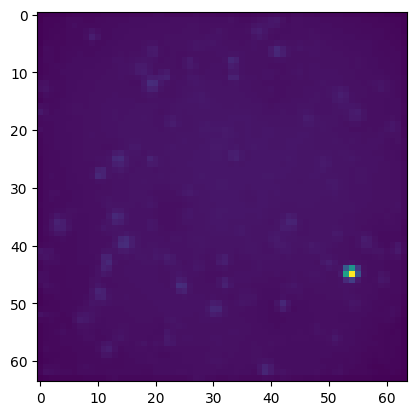

In [28]:
plt.imshow(all_arrays[0][0])

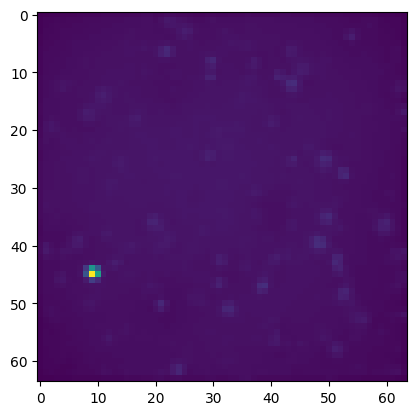

In [29]:
plt.imshow(all_arrays[1][0])

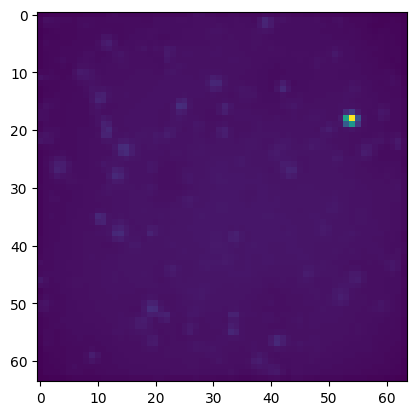

In [30]:
plt.imshow(all_arrays[2][0])

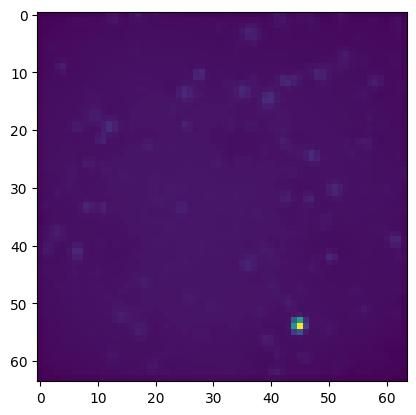

In [31]:
plt.imshow(all_arrays[3][0])

# Normalize pixel values to max 1

In [4]:
#First, we should find the max value of all pixel values in arrays
#And divide everything by that value to get a max of 1
#this improves the performance of the model because it makes gradient descent steps more consistently appropriate

max_pixel = 0

for i in original_arrays:
  max_of_array = i.max()
  if max_of_array>max_pixel:
    max_pixel=max_of_array
  else:
    continue
print(max_pixel)

65478


In [5]:
all_scaled_arrays = all_arrays.copy()

for each in all_scaled_arrays:
  for i in range(len(each)):
    each[i] = each[i]/65478

print("original", all_scaled_arrays[0][0])
print("h flip", all_scaled_arrays[1][0])
print("v flip", all_scaled_arrays[2][0])
print("bflip", all_scaled_arrays[3][0])

original [[0.01828095 0.02216011 0.02286264 ... 0.02307645 0.02219066 0.01831149]
 [0.02226702 0.02692507 0.02782614 ... 0.02808577 0.02704725 0.02246556]
 [0.02298482 0.02785668 0.02872721 ... 0.02926174 0.02813159 0.0238248 ]
 ...
 [0.02616146 0.03489722 0.03486667 ... 0.02738324 0.02704725 0.02240447]
 [0.02683344 0.03967745 0.03786004 ... 0.02669599 0.02631418 0.02180885]
 [0.01854058 0.02411497 0.02550475 ... 0.02217539 0.02176303 0.01805186]]
h flip [[0.01831149 0.02219066 0.02307645 ... 0.02286264 0.02216011 0.01828095]
 [0.02246556 0.02704725 0.02808577 ... 0.02782614 0.02692507 0.02226702]
 [0.0238248  0.02813159 0.02926174 ... 0.02872721 0.02785668 0.02298482]
 ...
 [0.02240447 0.02704725 0.02738324 ... 0.03486667 0.03489722 0.02616146]
 [0.02180885 0.02631418 0.02669599 ... 0.03786004 0.03967745 0.02683344]
 [0.01805186 0.02176303 0.02217539 ... 0.02550475 0.02411497 0.01854058]]
v flip [[0.01854058 0.02411497 0.02550475 ... 0.02217539 0.02176303 0.01805186]
 [0.02683344 0.0

In [6]:
max_pixel = 0

for i in all_scaled_arrays[0]:
  max_of_array = i.max()
  if max_of_array>max_pixel:
    max_pixel=max_of_array
  else:
    continue
print(max_pixel)


1.0


# Adjust array shape to be compatible with tensorflow expectations

In [7]:
#we must change shape from (64,64) to (64, 64, 1) to tell tensorflow that there is one channel
#for later processing
# (shown in pseudocolor above)
expanded_scaled_arrays = all_scaled_arrays.copy()
expanded_scaled_arrays[0][0].shape
for each in expanded_scaled_arrays:
  for i in range(len(each)):
    each[i] = np.expand_dims(each[i], axis=2)
  print(len(expanded_scaled_arrays))
  print(len(expanded_scaled_arrays[0]))
  print(expanded_scaled_arrays[0][0].shape)

4
384
(64, 64, 1)
4
384
(64, 64, 1)
4
384
(64, 64, 1)
4
384
(64, 64, 1)


# Establish data sets

In [8]:
#so now the arrays are ready to go
#we can put them together in groups to see which augmentations help vs the original image performance

og_scaled_arrays = expanded_scaled_arrays[0].copy()

ogh_scaled_arrays = expanded_scaled_arrays[0].copy() + expanded_scaled_arrays[1].copy()

ogv_scaled_arrays = expanded_scaled_arrays[0].copy() + expanded_scaled_arrays[2].copy()

ogb_scaled_arrays = expanded_scaled_arrays[0].copy() + expanded_scaled_arrays[3].copy()

total_scaled_arrays = expanded_scaled_arrays[0].copy() + expanded_scaled_arrays[1].copy()+ expanded_scaled_arrays[2].copy()+ expanded_scaled_arrays[3].copy()

print(len(og_scaled_arrays), len(ogh_scaled_arrays), len(ogv_scaled_arrays), len(ogb_scaled_arrays), len(total_scaled_arrays))

384 768 768 768 1536


# Read in Cytokine Labels

In [9]:
# we need to associate every array with a cytokine now

#Read in labels csv

binned = pd.read_csv('binned_cytokines.csv')
binned = binned.iloc[:,1:].apply(np.int64)
binned



Activin A  Amphiregulin  CCL1  CCL19  CCL2  CCL20  CCL22  CCL4  CCL5  \
0            0             0     0      0     1      0      0     0     1   
1            0             0     0      0     1      1      1     0     1   
2            0             0     0      0     0      1      1     0     1   
3            0             0     0      0     0      0      0     0     1   
4            0             0     0      0     0      0      0     0     1   
..         ...           ...   ...    ...   ...    ...    ...   ...   ...   
379          0             0     0      0     0      0      0     0     0   
380          0             0     0      0     0      0      0     0     0   
381          0             0     0      0     0      0      0     0     0   
382          0             0     1      0     0      0      1     1     1   
383          0             0     0      0     0      0      0     0     0   

     CCL8  ...  IL-4  IL-6 R alpha  IL-6  IL-8  MMP-1  MMP-9  \
0       0  ...     0             0     0     1      1      0   
1       0  ...     0             0     1     0      1      0   
2       0  ...     0             0     0     0      1      0   
3       0  ...     0             0     1     0      1      0   
4       0  ...     0             0     0     0      0      0   
..    ...  ...   ...           ...   ...   ...    ...    ...   
379     0  ...     0             0     1     0      0      0   
380     0  ...     0             0     0     0      0      0   
381     0  ...     0             0     1     0      1      0   
382     0  ...     0             0     1     1      1      1   
383     0  ...     0             0     1     0      1      0   

     Osteopontin (OPN)  SAA  TNF RII  TNF alpha  
0                    1    0        0          0  
1                    0    0        0          0  
2                    0    0        0          0  
3                    0    0        0          0  
4                    0    0        0          0  
..                 ...  ...      ...        ...  
379                  1    0        0          0  
380                  1    0        0          0  
381                  1    0        0          0  
382                  1    0        0          0  
383                  1    0        0          0  

[384 rows x 40 columns]

In [10]:
binned.columns

cytokines = ['Activin A', 'Amphiregulin', 'CCL1', 'CCL19', 'CCL2', 'CCL20',
       'CCL22', 'CCL4', 'CCL5', 'CCL8', 'CD14', 'CRP', 'CX3CL1', 'CXCL1',
       'CXCL10', 'CXCL11', 'CXCL13', 'CXCL16', 'CXCL3', 'CXCL4', 'CXCL5',
       'G-CSF', 'GM-CSF', 'IL-1 RA/RN', 'IL-1 alpha', 'IL-1 beta', 'IL-10',
       'IL-12 p40', 'IL-15', 'IL-16', 'IL-4', 'IL-6 R alpha', 'IL-6', 'IL-8',
       'MMP-1', 'MMP-9', 'Osteopontin (OPN)', 'SAA', 'TNF RII', 'TNF alpha']

In [11]:
binned

Activin A  Amphiregulin  CCL1  CCL19  CCL2  CCL20  CCL22  CCL4  CCL5  \
0            0             0     0      0     1      0      0     0     1   
1            0             0     0      0     1      1      1     0     1   
2            0             0     0      0     0      1      1     0     1   
3            0             0     0      0     0      0      0     0     1   
4            0             0     0      0     0      0      0     0     1   
..         ...           ...   ...    ...   ...    ...    ...   ...   ...   
379          0             0     0      0     0      0      0     0     0   
380          0             0     0      0     0      0      0     0     0   
381          0             0     0      0     0      0      0     0     0   
382          0             0     1      0     0      0      1     1     1   
383          0             0     0      0     0      0      0     0     0   

     CCL8  ...  IL-4  IL-6 R alpha  IL-6  IL-8  MMP-1  MMP-9  \
0       0  ...     0             0     0     1      1      0   
1       0  ...     0             0     1     0      1      0   
2       0  ...     0             0     0     0      1      0   
3       0  ...     0             0     1     0      1      0   
4       0  ...     0             0     0     0      0      0   
..    ...  ...   ...           ...   ...   ...    ...    ...   
379     0  ...     0             0     1     0      0      0   
380     0  ...     0             0     0     0      0      0   
381     0  ...     0             0     1     0      1      0   
382     0  ...     0             0     1     1      1      1   
383     0  ...     0             0     1     0      1      0   

     Osteopontin (OPN)  SAA  TNF RII  TNF alpha  
0                    1    0        0          0  
1                    0    0        0          0  
2                    0    0        0          0  
3                    0    0        0          0  
4                    0    0        0          0  
..                 ...  ...      ...        ...  
379                  1    0        0          0  
380                  1    0        0          0  
381                  1    0        0          0  
382                  1    0        0          0  
383                  1    0        0          0  

[384 rows x 40 columns]

# Balance classes for each cytokine

In [12]:
#This errors when it reaches the end of the list, but works appropriately

#Make the downsampled dfs

eachcolumn = range(0, 41, 1)
success = []
holdingdfs = []

# try using arrays instead

for item in eachcolumn:
    # print(binned.iloc[:,item:item+1])
    binarized_values = binned.iloc[:,item:item+1]
#get the binned cytokine column and get the name for it from the list above
    one = pd.DataFrame(data = binarized_values, columns = [cytokines[item]])
    print(one)
#keep track of cytokine title
#     cytotitle = one.columns[0]
#grab all the positives from the binning
    two = one[one[one.columns[0]]>0.5]
#grab all the negatives from the beginning
    three = one[one[one.columns[0]]<0.5]
#take random samples of the negatives in an equal ratio to the positives
    try:
        three = three.sample(n=len(two))
    except:
      continue
#put the positives and downsampled negatives back together
    four = pd.concat([two, three])
#use this list to keep track of all the succesfully attached embeddings
    success.append(cytokines[item])
#use this list to keep track of all the final dataframes
    holdingdfs.append(four)

     Activin A
0            0
1            0
2            0
3            0
4            0
..         ...
379          0
380          0
381          0
382          0
383          0

[384 rows x 1 columns]
     Amphiregulin
0               0
1               0
2               0
3               0
4               0
..            ...
379             0
380             0
381             0
382             0
383             0

[384 rows x 1 columns]
     CCL1
0       0
1       0
2       0
3       0
4       0
..    ...
379     0
380     0
381     0
382     1
383     0

[384 rows x 1 columns]
     CCL19
0        0
1        0
2        0
3        0
4        0
..     ...
379      0
380      0
381      0
382      0
383      0

[384 rows x 1 columns]
     CCL2
0       1
1       1
2       0
3       0
4       0
..    ...
379     0
380     0
381     0
382     0
383     0

[384 rows x 1 columns]
     CCL20
0        0
1        1
2        1
3        0
4        0
..     ...
379      0
380      0
381      0
38

IndexError: ignored

In [13]:
holdingdfs[-1]
#ok, we got all the cytokines here and the appropriate indices

TNF alpha
31           1
32           1
34           1
36           1
96           1
..         ...
37           0
257          0
283          0
338          0
220          0

[124 rows x 1 columns]

# Remove cytokines without a sufficient number of observations

In [14]:
#Now let's remove everything that is too short
#This means there weren't enough positive response wells for that cytokine

# less than 15 length is too short.
#this will also error due to the use of pop, but does succesfully remove the right dfs
longdfs = holdingdfs.copy()
for i in range(len(longdfs)):
  length = len(longdfs[i])
  if length <15:
    longdfs.pop(i)

IndexError: ignored

In [15]:
#Check that the short dfs were removed
print(len(holdingdfs))
print(len(longdfs))

35
27


# Begin Modeling

# For each cytokine, fetch arrays (features) and labels (target). Then train a CNN and get predictions. Retain the history.

# This is repeated for each dataset.

#Begin with original and horizontal flips here

In [17]:
#Make models

#we need somewhere to store the epoch count, accuracy, and loss for training and validation

oghresults = []

for df in longdfs:
  indices = list(df.index.values)
#go get the features including augmentations
  features = []
  for i in indices:
    thing = ogh_scaled_arrays[i]
    features.append(thing)
    thing2 = ogh_scaled_arrays[i+384]
    features.append(thing2)

#go get the target labels and make it as long as the features
  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(2)]
#this is 2 arrays
#put them together without separation to match structure of features
  target2final = []
  for i in target2:
    target2final = target2final+i

  print("features",len(features))
  print("target", len(target2final))

  X_train, X_test, y_train, y_test = train_test_split(features, target2final, test_size=0.3)

  train_images = np.array(X_train)
  train_labels = np.array(y_train)
  test_images = np.array(X_test)
  test_labels = np.array(y_test)

  model = models.Sequential()
  model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(64, 64, 1)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.Flatten())

#notes
  #first candidate for embedding vector
  #use pretrained model and cutt off top to get embedding vector outputs
  #and you still do model.predict, but it won't be classes it would be embedding vectors
  #you can call a specific layer with model.predict
  #flatten will take the 128, 3X3 so this is 128X3X3, flatten literally just does this and flattens the vector into one dimension. look at model summary to confirm
  #probably want to add another dense layer so it is a smaller embedding

  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(2))

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels), batch_size=20)

  oghresults.append([history.history['accuracy'], history.history['val_accuracy'],
                     history.history['loss'], history.history['val_loss'], df.columns[0]])

features 188
target 188
Epoch 1/10
7/7 [==============================] - 2s 163ms/step - loss: 0.6889 - accuracy: 0.5115 - val_loss: 0.7049 - val_accuracy: 0.3684
Epoch 2/10
7/7 [==============================] - 1s 208ms/step - loss: 0.6724 - accuracy: 0.5573 - val_loss: 0.7174 - val_accuracy: 0.3684
Epoch 3/10
7/7 [==============================] - 1s 211ms/step - loss: 0.6641 - accuracy: 0.5725 - val_loss: 0.7591 - val_accuracy: 0.3684
Epoch 4/10
7/7 [==============================] - 1s 124ms/step - loss: 0.6549 - accuracy: 0.5725 - val_loss: 0.6868 - val_accuracy: 0.4211
Epoch 5/10
7/7 [==============================] - 1s 122ms/step - loss: 0.6324 - accuracy: 0.6260 - val_loss: 0.7510 - val_accuracy: 0.3684
Epoch 6/10
7/7 [==============================] - 1s 122ms/step - loss: 0.5892 - accuracy: 0.6336 - val_loss: 0.7206 - val_accuracy: 0.6140
Epoch 7/10
7/7 [==============================] - 1s 141ms/step - loss: 0.5580 - accuracy: 0.6947 - val_loss: 0.8255 - val_accuracy: 0.4

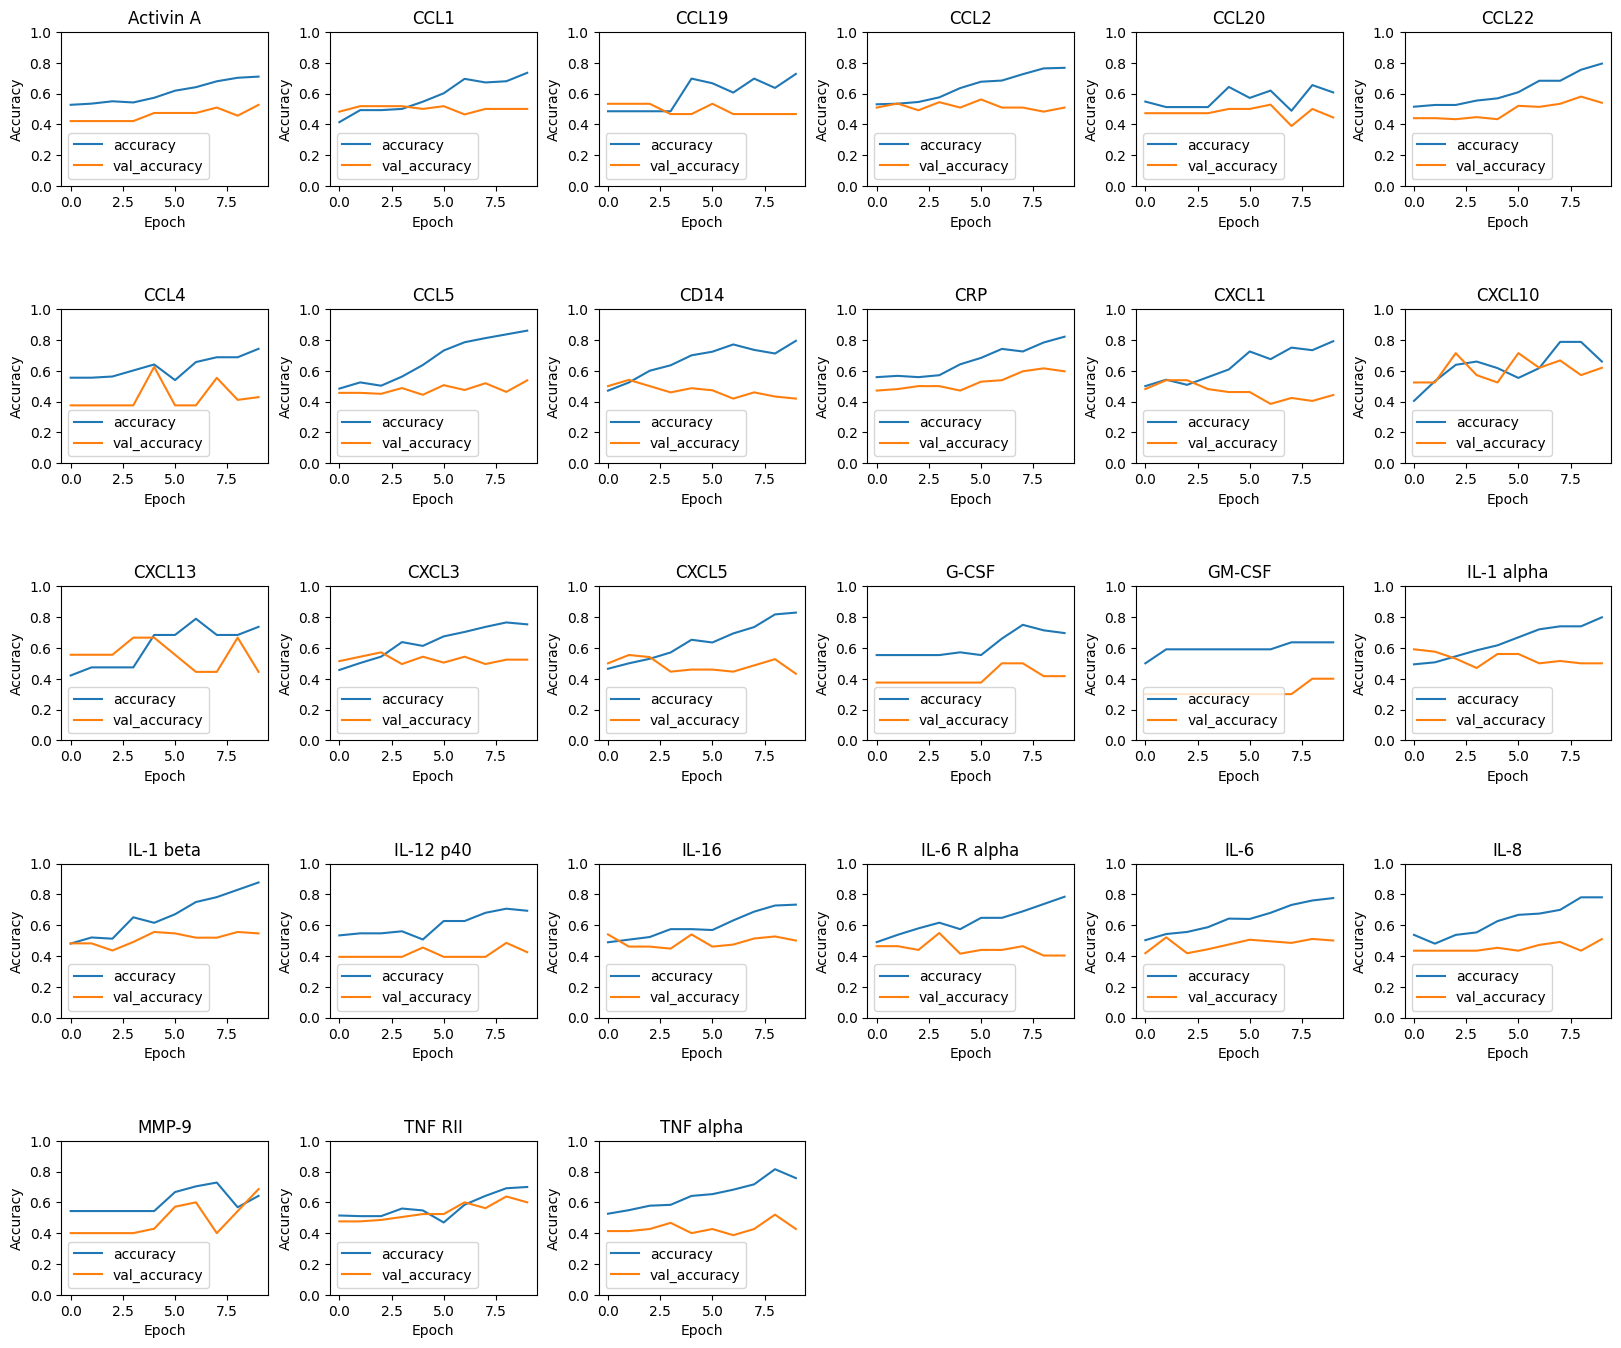

In [ ]:
#Plot performances

#original and horizontal flip images
plt.figure(figsize=(20,20))

for i in range(len(oghresults)):
    plt.subplot(6,6,i+1)
    plt.subplots_adjust(hspace=0.8, wspace=0.3)
    plt.grid(False)
    plt.plot(oghresults[i][0], label='accuracy')
    plt.plot(oghresults[i][1], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title(oghresults[i][4])
    plt.legend(loc='lower left')

plt.show()

# Model for original images only

In [ ]:
# og_scaled_arrays

#Make models

#we need somewhere to store the epoch count, accuracy, and loss for training and validation

ogresults = []
#get features and labels, ensuring they are the same length

for df in longdfs:
  indices = list(df.index.values)
  features = []
  for i in indices:
    thing = og_scaled_arrays[i]
    features.append(thing)


  target = list(df.iloc[:,0:1].values)


  print("features",len(features))
  print("target", len(target))

  X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

  train_images = np.array(X_train)
  train_labels = np.array(y_train)
  test_images = np.array(X_test)
  test_labels = np.array(y_test)

  model = models.Sequential()
  model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(64, 64, 1)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.Flatten())


  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(2))

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels), batch_size=20)

  ogresults.append([history.history['accuracy'], history.history['val_accuracy'],
                     history.history['loss'], history.history['val_loss'], df.columns[0]])



features 94
target 94
Epoch 1/10
4/4 [==============================] - 3s 311ms/step - loss: 0.7016 - accuracy: 0.4154 - val_loss: 0.6968 - val_accuracy: 0.5172
Epoch 2/10
4/4 [==============================] - 1s 139ms/step - loss: 0.6865 - accuracy: 0.5846 - val_loss: 0.6942 - val_accuracy: 0.5517
Epoch 3/10
4/4 [==============================] - 0s 121ms/step - loss: 0.6840 - accuracy: 0.5538 - val_loss: 0.7018 - val_accuracy: 0.5517
Epoch 4/10
4/4 [==============================] - 0s 110ms/step - loss: 0.6608 - accuracy: 0.5385 - val_loss: 0.7271 - val_accuracy: 0.4483
Epoch 5/10
4/4 [==============================] - 0s 119ms/step - loss: 0.6594 - accuracy: 0.5846 - val_loss: 0.7485 - val_accuracy: 0.4483
Epoch 6/10
4/4 [==============================] - 0s 117ms/step - loss: 0.6053 - accuracy: 0.5846 - val_loss: 0.7677 - val_accuracy: 0.4138
Epoch 7/10
4/4 [==============================] - 0s 121ms/step - loss: 0.5469 - accuracy: 0.7692 - val_loss: 0.8167 - val_accuracy: 0.517

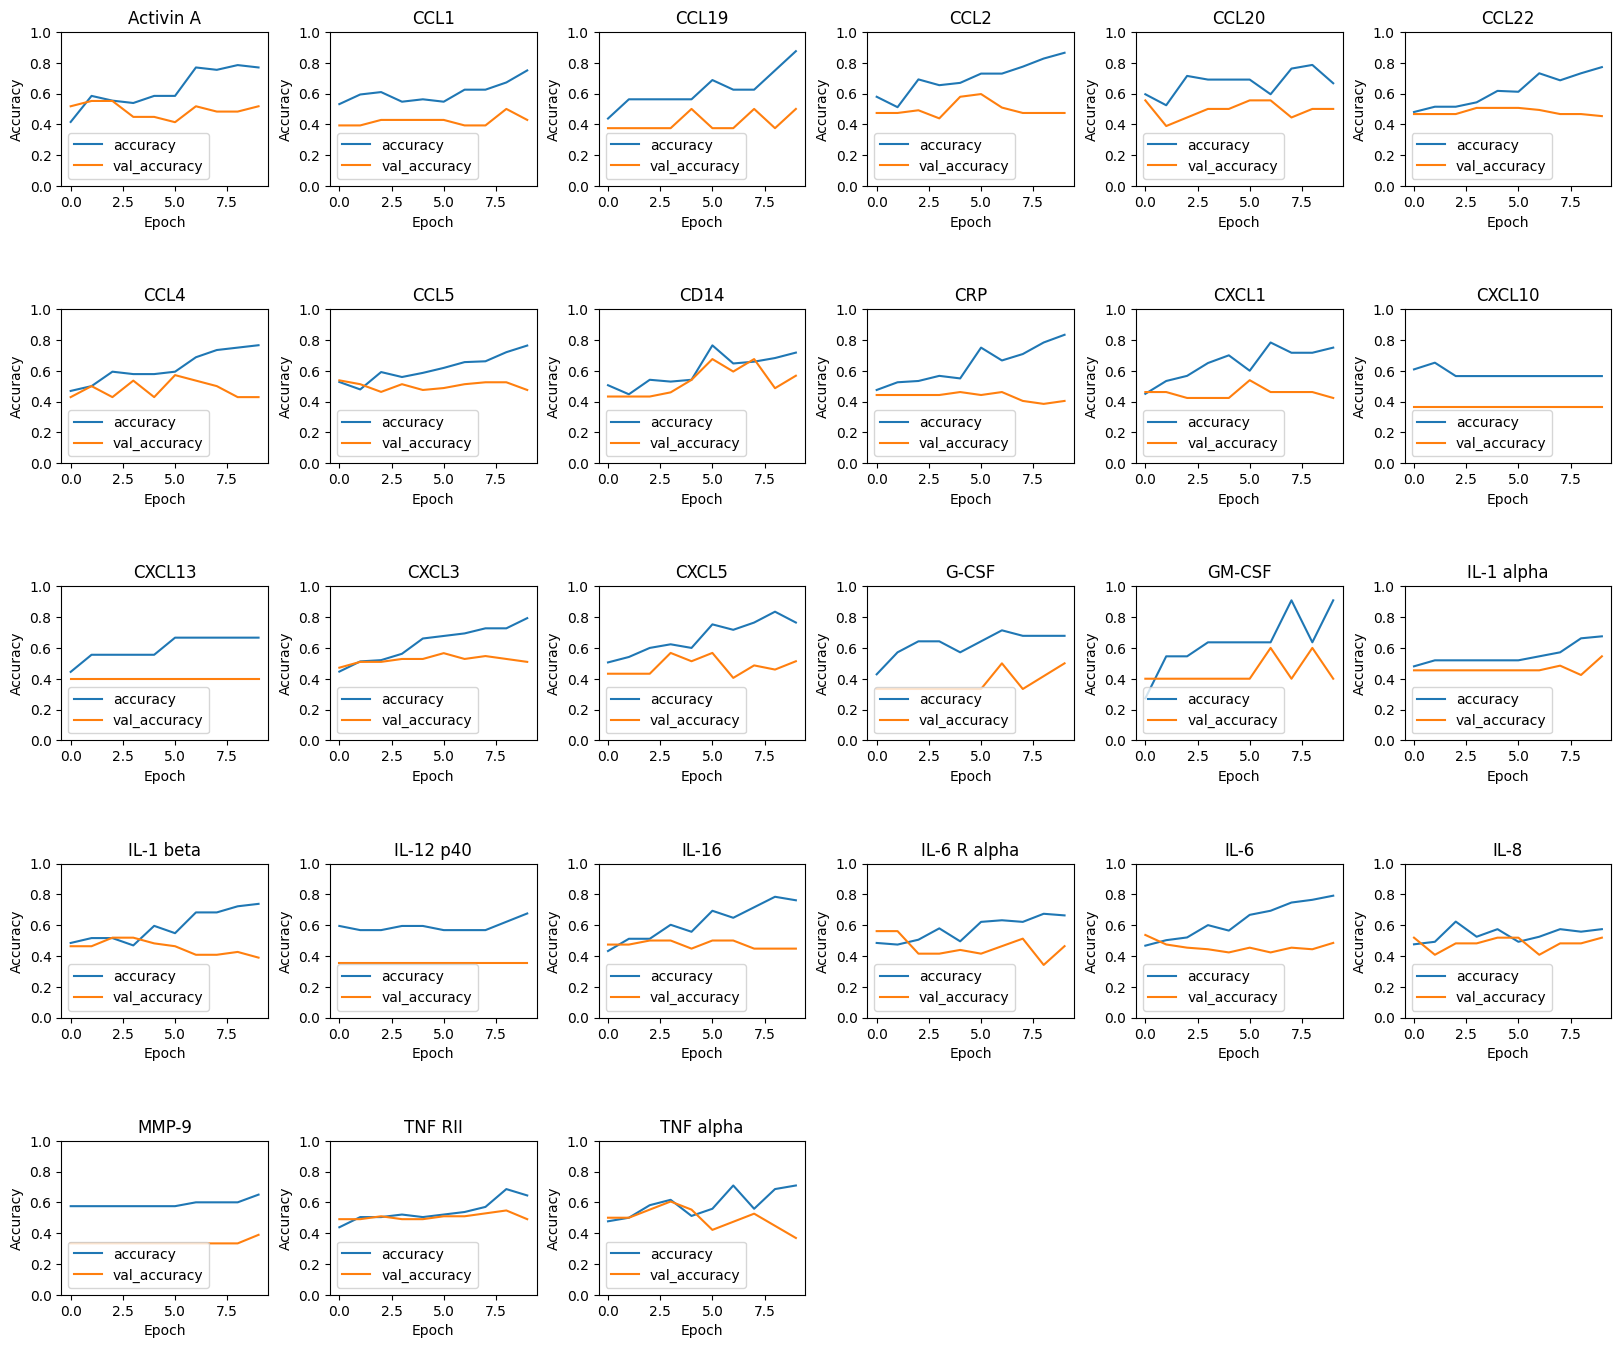

In [ ]:
#Plot performances

#original images only
plt.figure(figsize=(20,20))

for i in range(len(ogresults)):
    plt.subplot(6,6,i+1)
    plt.subplots_adjust(hspace=0.8, wspace=0.3)
    plt.grid(False)
    plt.plot(ogresults[i][0], label='accuracy')
    plt.plot(ogresults[i][1], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title(ogresults[i][4])
    plt.legend(loc='lower left')

plt.show()

# Original images and vertical flips

In [ ]:
# ogv_scaled_arrays

#Make models

#we need somewhere to store the epoch count, accuracy, and loss for training and validation

ogvresults = []
# same as before, make sure they are the same length

for df in longdfs:
  indices = list(df.index.values)
  features = []
  for i in indices:
    thing = ogv_scaled_arrays[i]
    features.append(thing)
    thing2 = ogv_scaled_arrays[i+384]
    features.append(thing2)

  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(2)]
#this is 2 arrays
#put them together without separation to match structure of features
  target2final = []
  for i in target2:
    target2final = target2final+i

  print("features",len(features))
  print("target", len(target2final))

  X_train, X_test, y_train, y_test = train_test_split(features, target2final, test_size=0.3)

  train_images = np.array(X_train)
  train_labels = np.array(y_train)
  test_images = np.array(X_test)
  test_labels = np.array(y_test)

  model = models.Sequential()
  model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(64, 64, 1)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.Flatten())


  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(2))

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels), batch_size=20)

  ogvresults.append([history.history['accuracy'], history.history['val_accuracy'],
                     history.history['loss'], history.history['val_loss'], df.columns[0]])

features 188
target 188
Epoch 1/10
7/7 [==============================] - 3s 335ms/step - loss: 0.6979 - accuracy: 0.4580 - val_loss: 0.6928 - val_accuracy: 0.3860
Epoch 2/10
7/7 [==============================] - 2s 237ms/step - loss: 0.6920 - accuracy: 0.5649 - val_loss: 0.6974 - val_accuracy: 0.4737
Epoch 3/10
7/7 [==============================] - 1s 138ms/step - loss: 0.6891 - accuracy: 0.5878 - val_loss: 0.6984 - val_accuracy: 0.4561
Epoch 4/10
7/7 [==============================] - 1s 131ms/step - loss: 0.6846 - accuracy: 0.5344 - val_loss: 0.7163 - val_accuracy: 0.4211
Epoch 5/10
7/7 [==============================] - 1s 123ms/step - loss: 0.6611 - accuracy: 0.6641 - val_loss: 0.7226 - val_accuracy: 0.4912
Epoch 6/10
7/7 [==============================] - 1s 134ms/step - loss: 0.6426 - accuracy: 0.6412 - val_loss: 0.8008 - val_accuracy: 0.4737
Epoch 7/10
7/7 [==============================] - 1s 134ms/step - loss: 0.6055 - accuracy: 0.6641 - val_loss: 0.8311 - val_accuracy: 0.5

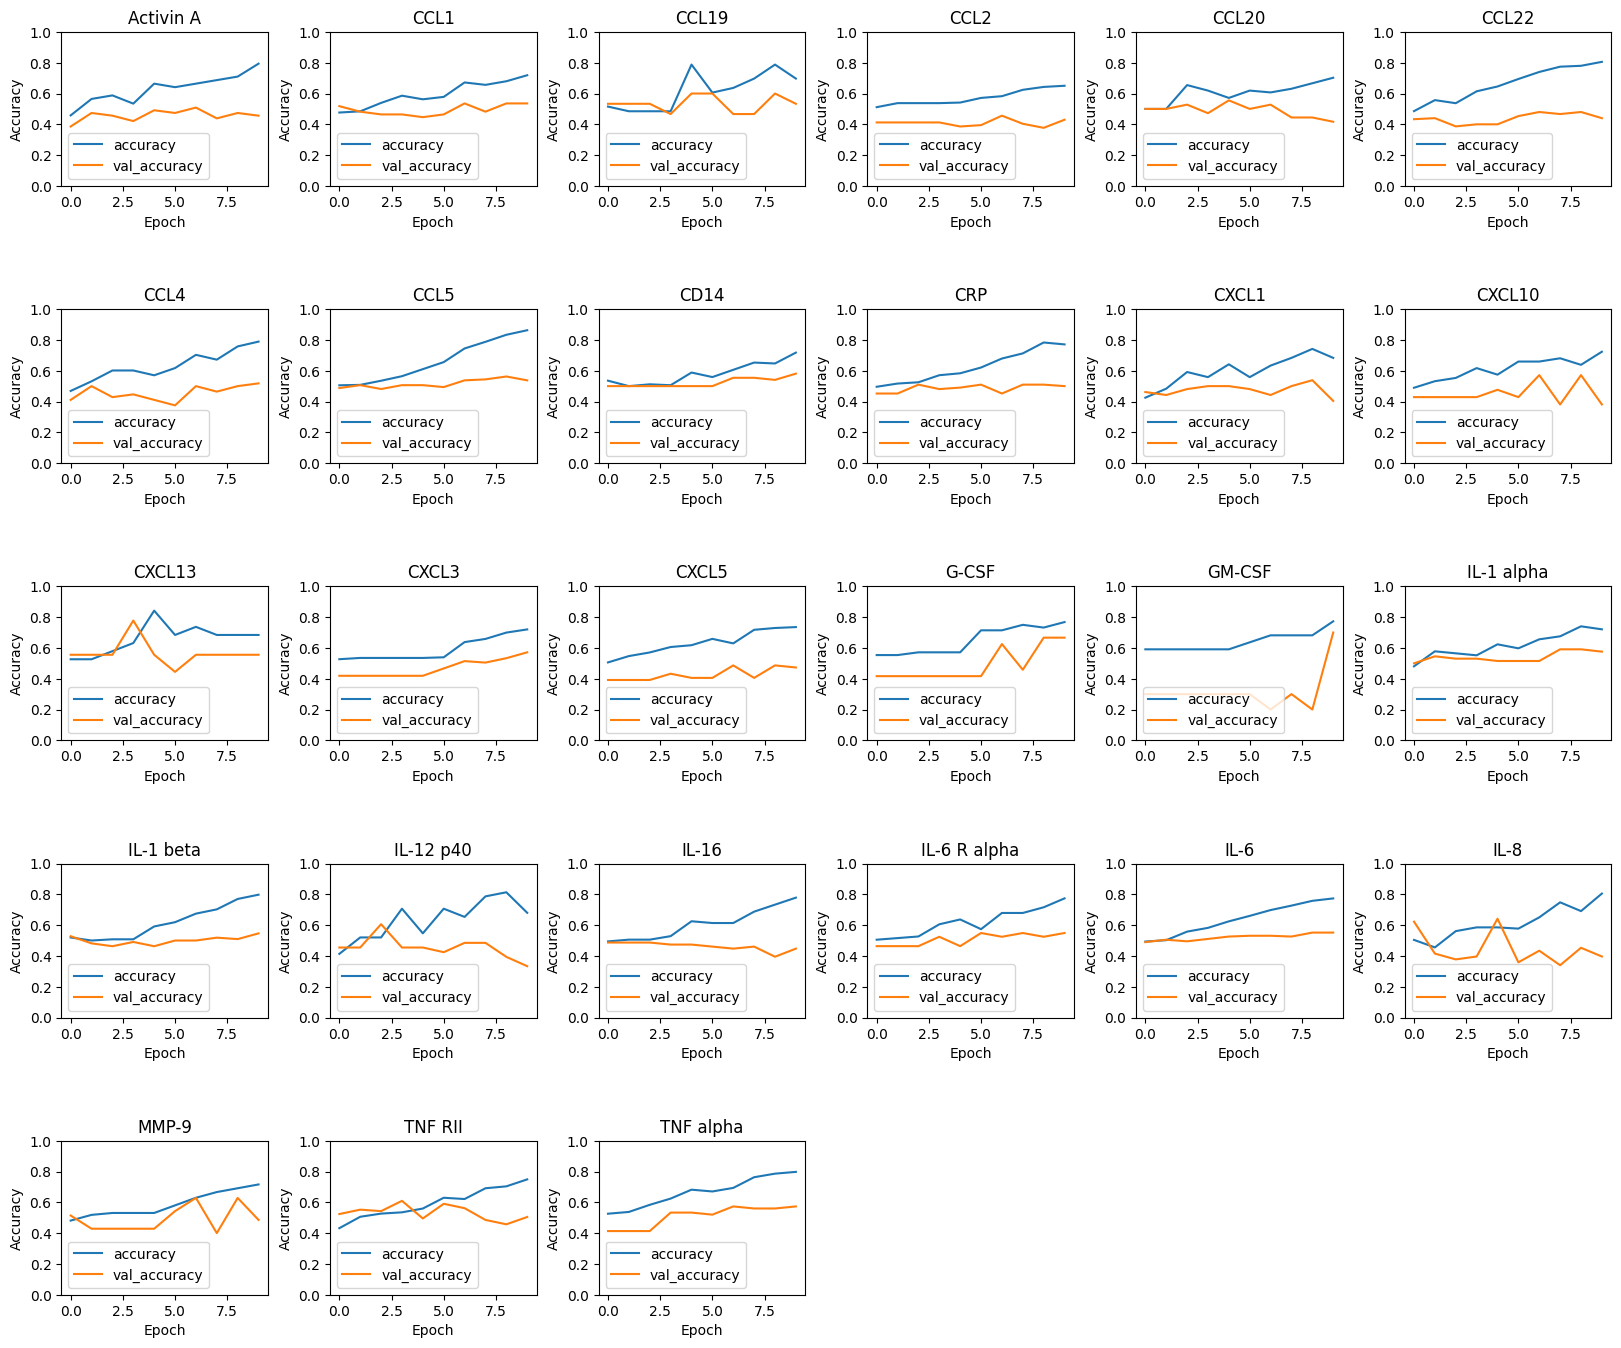

In [ ]:
#Plot performances

#original and vertical flip images
plt.figure(figsize=(20,20))

for i in range(len(ogvresults)):
    plt.subplot(6,6,i+1)
    plt.subplots_adjust(hspace=0.8, wspace=0.3)
    plt.grid(False)
    plt.plot(ogvresults[i][0], label='accuracy')
    plt.plot(ogvresults[i][1], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title(ogvresults[i][4])
    plt.legend(loc='lower left')

plt.show()

# Original images and transposed images

In [ ]:


#Make models

#we need somewhere to store the epoch count, accuracy, and loss for training and validation

ogbresults = []

for df in longdfs:
  indices = list(df.index.values)
  features = []
  for i in indices:
    thing = ogb_scaled_arrays[i]
    features.append(thing)
    thing2 = ogb_scaled_arrays[i+384]
    features.append(thing2)

  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(2)]
#this is 2 arrays
#put them together without separation to match structure of features
  target2final = []
  for i in target2:
    target2final = target2final+i

  print("features",len(features))
  print("target", len(target2final))

  X_train, X_test, y_train, y_test = train_test_split(features, target2final, test_size=0.3)

  train_images = np.array(X_train)
  train_labels = np.array(y_train)
  test_images = np.array(X_test)
  test_labels = np.array(y_test)

  model = models.Sequential()
  model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(64, 64, 1)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.Flatten())


  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(2))

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels), batch_size=20)

  ogbresults.append([history.history['accuracy'], history.history['val_accuracy'],
                     history.history['loss'], history.history['val_loss'], df.columns[0]])

features 188
target 188
Epoch 1/10
7/7 [==============================] - 4s 185ms/step - loss: 0.7055 - accuracy: 0.5115 - val_loss: 0.6921 - val_accuracy: 0.4386
Epoch 2/10
7/7 [==============================] - 1s 133ms/step - loss: 0.6900 - accuracy: 0.5725 - val_loss: 0.7040 - val_accuracy: 0.3860
Epoch 3/10
7/7 [==============================] - 1s 134ms/step - loss: 0.6826 - accuracy: 0.5496 - val_loss: 0.7000 - val_accuracy: 0.4737
Epoch 4/10
7/7 [==============================] - 1s 132ms/step - loss: 0.6689 - accuracy: 0.6183 - val_loss: 0.7010 - val_accuracy: 0.3860
Epoch 5/10
7/7 [==============================] - 1s 134ms/step - loss: 0.6418 - accuracy: 0.5878 - val_loss: 0.7540 - val_accuracy: 0.4386
Epoch 6/10
7/7 [==============================] - 1s 130ms/step - loss: 0.5929 - accuracy: 0.5878 - val_loss: 0.6834 - val_accuracy: 0.5439
Epoch 7/10
7/7 [==============================] - 1s 129ms/step - loss: 0.5618 - accuracy: 0.7023 - val_loss: 0.7829 - val_accuracy: 0.4

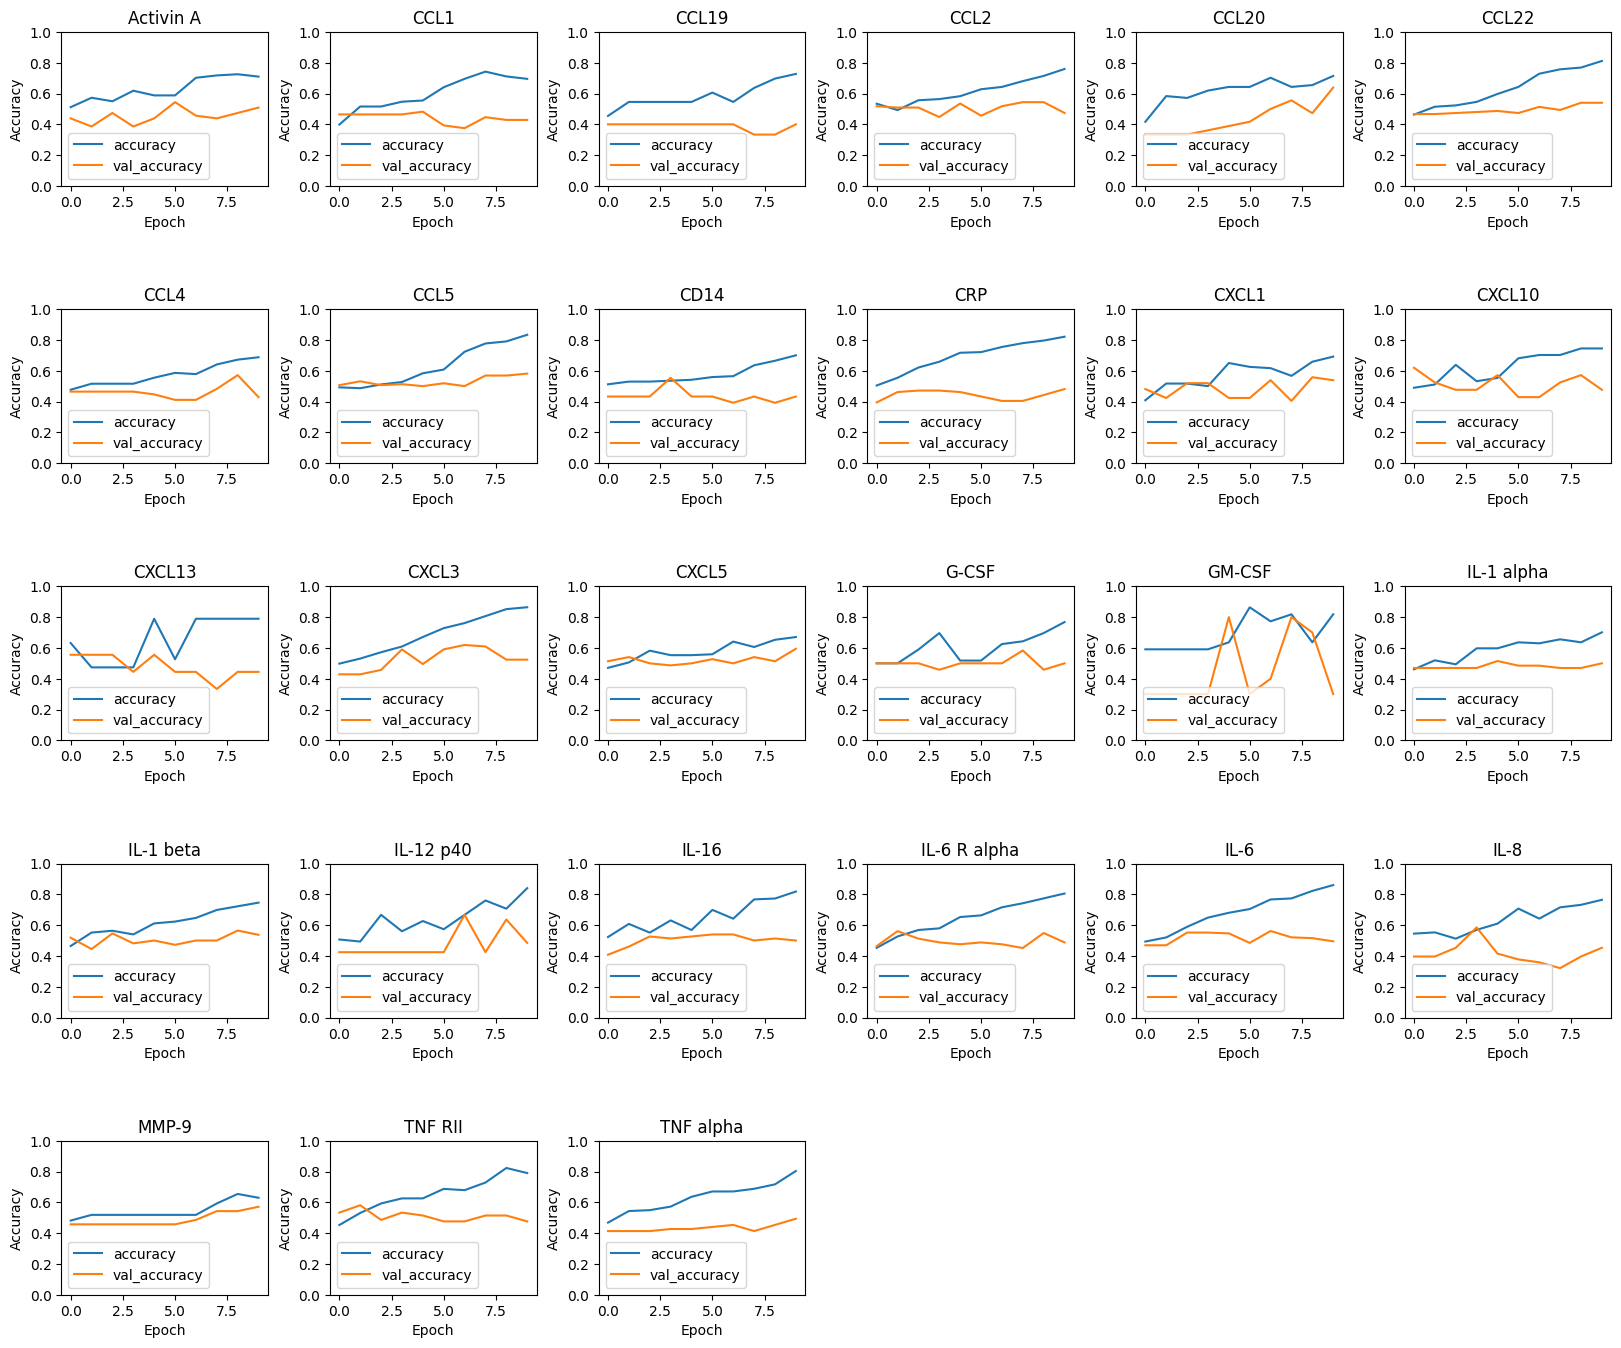

In [ ]:
#Plot performances

#original and trasnposed images
plt.figure(figsize=(20,20))

for i in range(len(ogbresults)):
    plt.subplot(6,6,i+1)
    plt.subplots_adjust(hspace=0.8, wspace=0.3)
    plt.grid(False)
    plt.plot(ogbresults[i][0], label='accuracy')
    plt.plot(ogbresults[i][1], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title(ogbresults[i][4])
    plt.legend(loc='lower left')

plt.show()

# Now include original images and all augmentations

In [ ]:
total_scaled_arrays

# ogv_scaled_arrays

#Make models

#we need somewhere to store the epoch count, accuracy, and loss for training and validation

totalresults = []
# longdfsshort = longdfs[0:5]

for df in longdfs:
  indices = list(df.index.values)
  features = []
  for i in indices:
    thing = total_scaled_arrays[i]
    features.append(thing)
    thing2 = total_scaled_arrays[i+384]
    features.append(thing2)
    thing3 = total_scaled_arrays[i+384+384]
    features.append(thing3)
    thing4 = total_scaled_arrays[i+384+384+384]
    features.append(thing4)

  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(4)]
#this is 2 arrays
#put them together without separation to match structure of features
  target2final = []
  for i in target2:
    target2final = target2final+i

  print("features",len(features))
  print("target", len(target2final))

  X_train, X_test, y_train, y_test = train_test_split(features, target2final, test_size=0.3)

  train_images = np.array(X_train)
  train_labels = np.array(y_train)
  test_images = np.array(X_test)
  test_labels = np.array(y_test)

  model = models.Sequential()
  model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(64, 64, 1)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.Flatten())


  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(2))

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels), batch_size=20)

  totalresults.append([history.history['accuracy'], history.history['val_accuracy'],
                     history.history['loss'], history.history['val_loss'], df.columns[0]])

features 376
target 376
Epoch 1/10
14/14 [==============================] - 5s 147ms/step - loss: 0.6958 - accuracy: 0.5171 - val_loss: 0.6903 - val_accuracy: 0.5575
Epoch 2/10
14/14 [==============================] - 2s 131ms/step - loss: 0.6889 - accuracy: 0.5551 - val_loss: 0.7808 - val_accuracy: 0.4956
Epoch 3/10
14/14 [==============================] - 2s 128ms/step - loss: 0.6995 - accuracy: 0.5513 - val_loss: 0.6975 - val_accuracy: 0.5487
Epoch 4/10
14/14 [==============================] - 2s 130ms/step - loss: 0.6658 - accuracy: 0.5665 - val_loss: 0.7150 - val_accuracy: 0.4513
Epoch 5/10
14/14 [==============================] - 2s 129ms/step - loss: 0.6088 - accuracy: 0.5932 - val_loss: 0.8492 - val_accuracy: 0.5133
Epoch 6/10
14/14 [==============================] - 3s 198ms/step - loss: 0.5615 - accuracy: 0.6464 - val_loss: 0.9180 - val_accuracy: 0.4779
Epoch 7/10
14/14 [==============================] - 2s 134ms/step - loss: 0.5118 - accuracy: 0.7072 - val_loss: 0.9932 - val

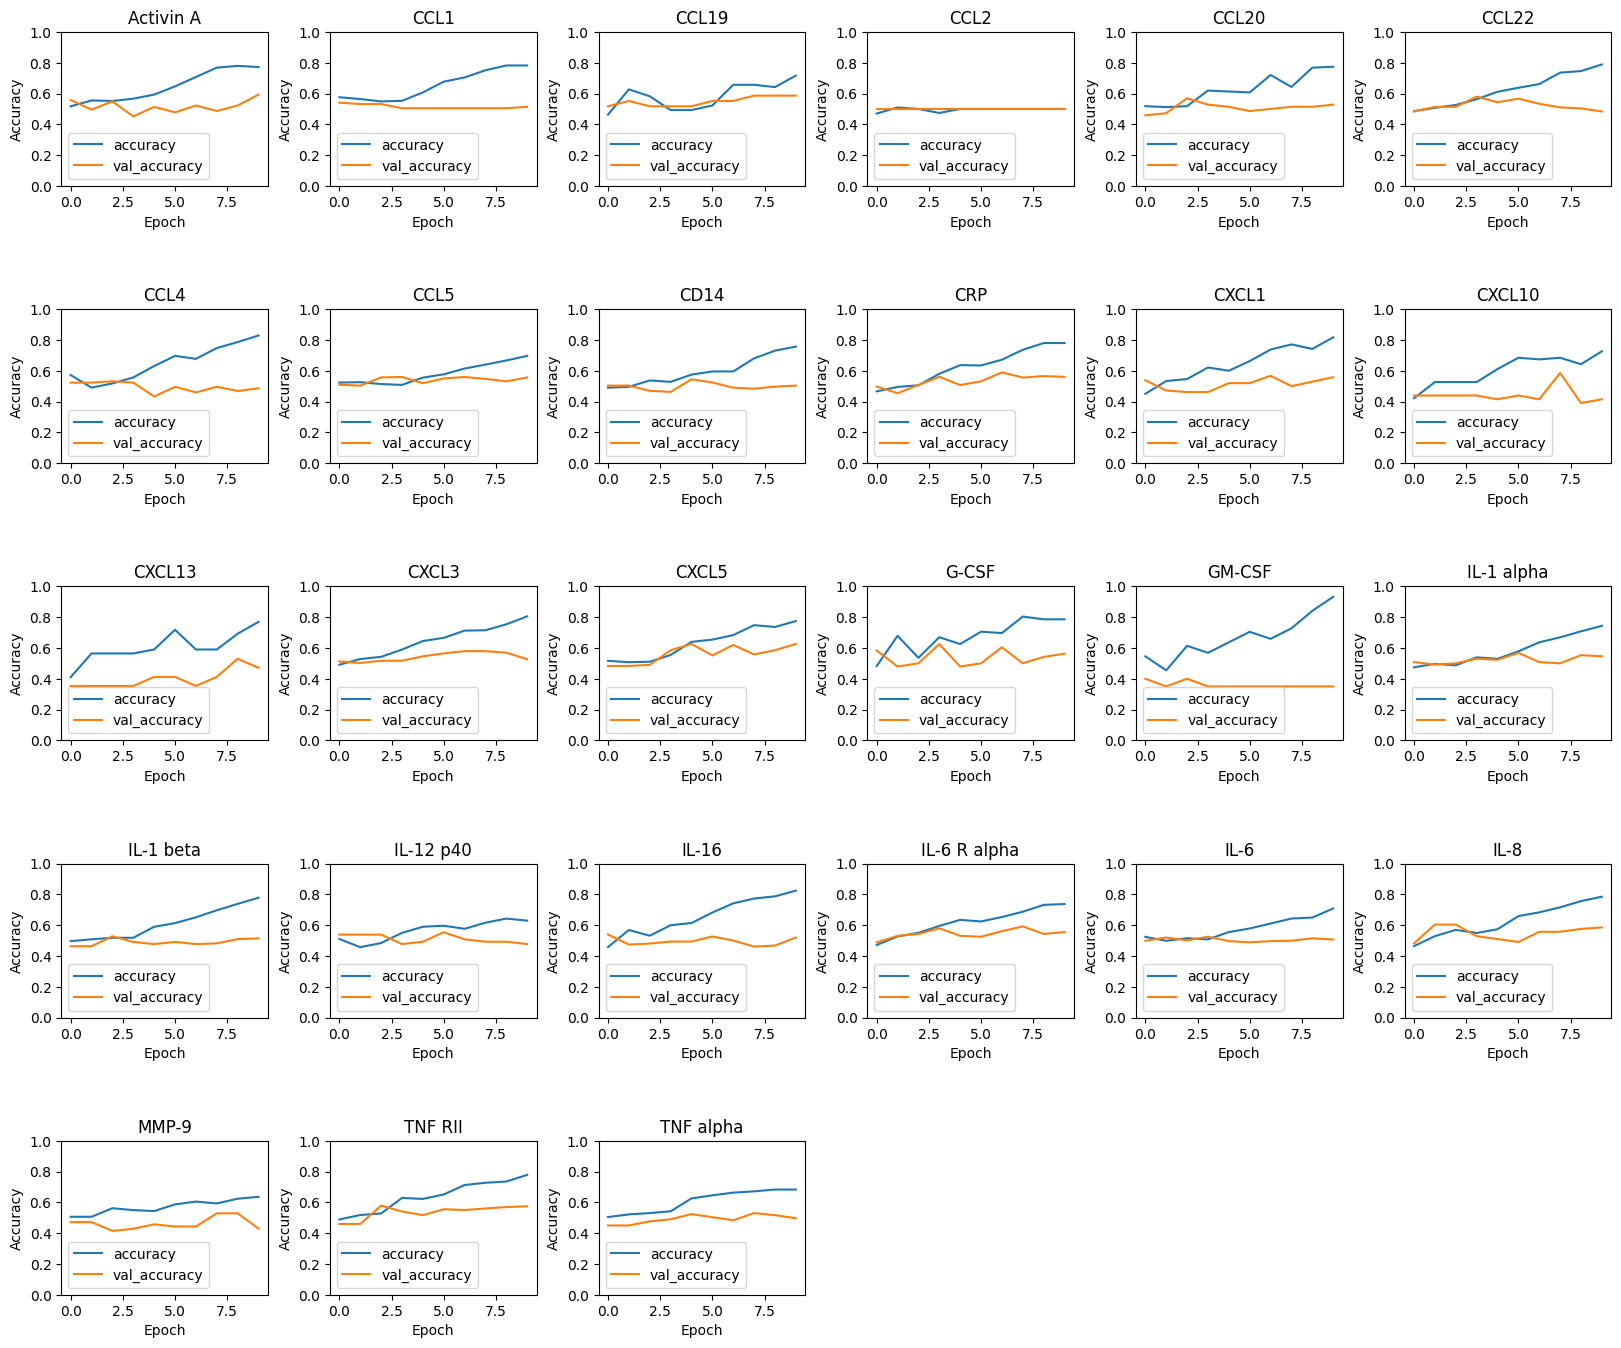

In [ ]:
#Plot performances

#original and all augmented images
plt.figure(figsize=(20,20))

for i in range(len(totalresults)):
    plt.subplot(6,6,i+1)
    plt.subplots_adjust(hspace=0.8, wspace=0.3)
    plt.grid(False)
    plt.plot(totalresults[i][0], label='accuracy')
    plt.plot(totalresults[i][1], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title(totalresults[i][4])
    plt.legend(loc='lower left')

plt.show()

# Summarize CNN results

In [ ]:
#make a summary table

totalresultsdf = pd.DataFrame(data = totalresults, columns = ["test accuracy", "validation accuracy", "test loss", "validation loss", "cytokine"])
totalresultsdf


#there is a number for each metric for each epoch, of course

#Since this is stil just proof of concept, let's take the max for acuracy and val_accuracy
#and the min for loss and validation loss, and finally the cytokine name

#notes
# print(ogresults[0]) #this is all info for the first cytokine
# print(len(ogresults[0])) #this is len 5 for the 5 metrics we put in
# print(ogresults[0][0])
# print(len(ogresults[0][0])) #this is len 10 for the 10 epochs
# print(ogresults[0][2])
# print(len(ogresults[0][2]))
# print(ogresults[0][4]) #this is the cytokine name

summarizer = pd.DataFrame(columns =["MaxTestAcc", "MaxValAcc", "MinTestLoss", "MinValLoss", "Cytokine", "Augmentation"])

for i in range(len(ogresults)):
  maximum_accuracy = max(ogresults[i][0])
  maximum_val_accuracy = max(ogresults[i][1])
  min_loss = min(ogresults[i][2])
  min_val_loss = min(ogresults[i][3])
  cytokine = ogresults[i][4]
  tracking = [maximum_accuracy, maximum_val_accuracy, min_loss, min_val_loss, cytokine, "Original"]
  summarizer.loc[len(summarizer.index)] = tracking

for i in range(len(oghresults)):
  maximum_accuracy = max(oghresults[i][0])
  maximum_val_accuracy = max(oghresults[i][1])
  min_loss = min(oghresults[i][2])
  min_val_loss = min(oghresults[i][3])
  cytokine = oghresults[i][4]
  tracking = [maximum_accuracy, maximum_val_accuracy, min_loss, min_val_loss, cytokine, "Original/Horizontal"]
  summarizer.loc[len(summarizer.index)] = tracking

for i in range(len(ogbresults)):
  maximum_accuracy = max(ogbresults[i][0])
  maximum_val_accuracy = max(ogbresults[i][1])
  min_loss = min(ogbresults[i][2])
  min_val_loss = min(ogbresults[i][3])
  cytokine = ogbresults[i][4]
  tracking = [maximum_accuracy, maximum_val_accuracy, min_loss, min_val_loss, cytokine, "Original/Transposed"]
  summarizer.loc[len(summarizer.index)] = tracking

for i in range(len(ogvresults)):
  maximum_accuracy = max(ogvresults[i][0])
  maximum_val_accuracy = max(ogvresults[i][1])
  min_loss = min(ogvresults[i][2])
  min_val_loss = min(ogvresults[i][3])
  cytokine = ogvresults[i][4]
  tracking = [maximum_accuracy, maximum_val_accuracy, min_loss, min_val_loss, cytokine, "Original/Vertical"]
  summarizer.loc[len(summarizer.index)] = tracking

for i in range(len(totalresults)):
  maximum_accuracy = max(totalresults[i][0])
  maximum_val_accuracy = max(totalresults[i][1])
  min_loss = min(totalresults[i][2])
  min_val_loss = min(totalresults[i][3])
  cytokine = totalresults[i][4]
  tracking = [maximum_accuracy, maximum_val_accuracy, min_loss, min_val_loss, cytokine, "Everything"]
  summarizer.loc[len(summarizer.index)] = tracking


summarizer

MaxTestAcc  MaxValAcc  MinTestLoss  MinValLoss   Cytokine Augmentation
0      0.784615   0.551724     0.402280    0.694229  Activin A     Original
1      0.750000   0.500000     0.546524    0.699426       CCL1     Original
2      0.875000   0.500000     0.506569    0.720829      CCL19     Original
3      0.864662   0.596491     0.293573    0.701704       CCL2     Original
4      0.785714   0.555556     0.537102    0.693233      CCL20     Original
..          ...        ...          ...         ...        ...          ...
130    0.708102   0.524548     0.520203    0.693013       IL-6   Everything
131    0.784553   0.603774     0.427631    0.653358       IL-8   Everything
132    0.635802   0.528571     0.605300    0.693389      MMP-9   Everything
133    0.778234   0.578947     0.406359    0.693116    TNF RII   Everything
134    0.682997   0.530201     0.531194    0.693386  TNF alpha   Everything

[135 rows x 6 columns]

#Show the predictable cytokines!

In [ ]:
predictable = summarizer[summarizer["MaxValAcc"]>= 0.65]
predictable

MaxTestAcc  MaxValAcc  MinTestLoss  MinValLoss   Cytokine  \
8     0.764706   0.675676     0.564034    0.623770       CD14   
38    0.787234   0.714286     0.478432    0.526283     CXCL10   
39    0.789474   0.666667     0.556030    0.660464     CXCL13   
51    0.728395   0.685714     0.564770    0.656137      MMP-9   
70    0.863636   0.800000     0.601501    0.667470     GM-CSF   
73    0.840000   0.666667     0.473098    0.641797  IL-12 p40   
93    0.842105   0.777778     0.497007    0.603522     CXCL13   
96    0.767857   0.666667     0.487041    0.646744      G-CSF   
97    0.772727   0.700000     0.614486    0.678833     GM-CSF   

           Augmentation  
8              Original  
38  Original/Horizontal  
39  Original/Horizontal  
51  Original/Horizontal  
70  Original/Transposed  
73  Original/Transposed  
93    Original/Vertical  
96    Original/Vertical  
97    Original/Vertical

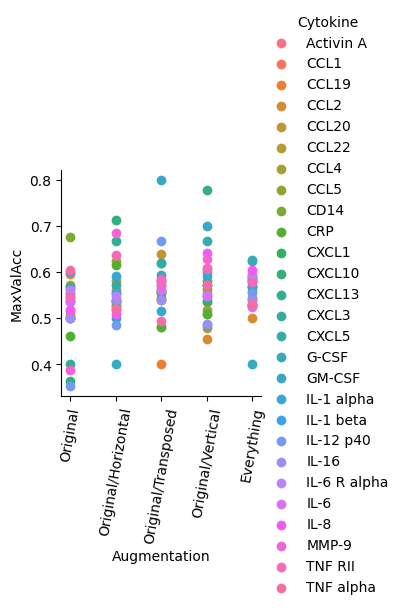

In [ ]:
# All cytokines, bar chart with augmentation on x axis
# color is cyotkine
# value is maxvalacc

import seaborn as sns


fg = sns.FacetGrid(data=summarizer, hue='Cytokine')
fg.map(plt.scatter, 'Augmentation', 'MaxValAcc').add_legend()
fg.set_xticklabels(rotation=80)

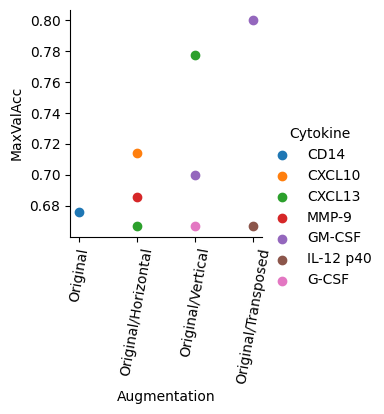

In [ ]:
#Just predictable cytokines
fg = sns.FacetGrid(data=predictable, hue='Cytokine')
fg.map(plt.scatter, 'Augmentation', 'MaxValAcc').add_legend()
fg.set_xticklabels(rotation=80)

# Now use a visual transformer

# Install necessary packages

In [18]:
!pip install tensorflow_addons
!pip install vit-keras
from vit_keras import vit, utils

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Include this code to create more visually appealing confusion matrices

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

def confusio_matrix(y_test, preds, target):
  cm = confusion_matrix(y_test, preds)
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos
  recall = (cm[1][1])/(cm[1][1] + cm[1][0])  #TruePositives / (TruePositives + FalseNegatives)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]

  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()
  print(target, "precision", "=", precision,"recall", "=", recall)
  return precision, recall


#Fit a visual transformer on each cytokine, get predictions, and show confusion matrices.

#Do this for the dataset which includes all augmentations and the original images



In [20]:
#Load up the ViT

vit_model = vit.vit_b32(
image_size = 64,
activation = 'max',
pretrained = True,
include_top = False,
pretrained_top = False,
classes = 2)

vit_model.trainable = False
#^this ensures we don't train the bottom (general object detection) of the ViT -
#we only want to train the top few layers which we will add below.

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 2, 2
  warnings.warn(


features 376
target 376
(113, 64, 64, 3)
(263, 64, 64, 3)
Epoch 1/5
9/9 [==============================] - 43s 1s/step - loss: 0.7119 - val_loss: 0.6945
Epoch 2/5
9/9 [==============================] - 7s 794ms/step - loss: 0.7018 - val_loss: 0.6904
Epoch 3/5
9/9 [==============================] - 8s 936ms/step - loss: 0.6954 - val_loss: 0.6894
Epoch 4/5
9/9 [==============================] - 7s 771ms/step - loss: 0.6892 - val_loss: 0.6897
Epoch 5/5
1/1 [==============================] - 0s 88ms/step


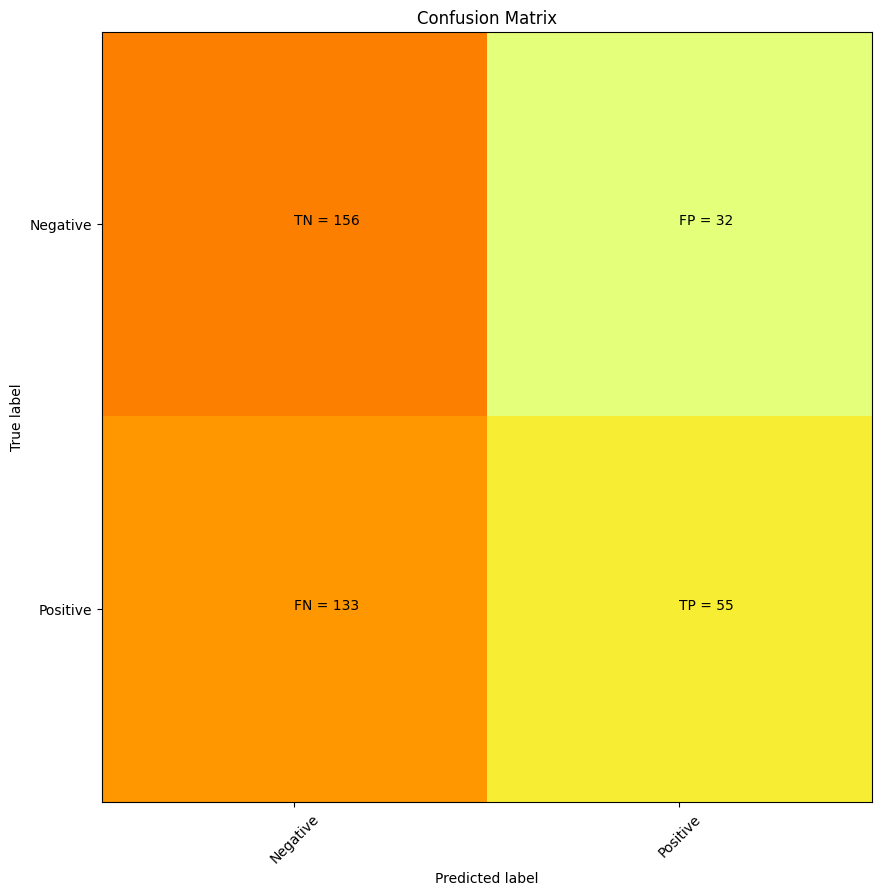

['Original', 'Activin A'] precision = 0.632183908045977 recall = 0.2925531914893617
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_66 (Dense)            (None, 256)               196864    
                                                                 
 dense_67 (Dense)            (None, 128)               32896     
                                                                 
 dense_68 (Dense)            (None, 64)                8256      
                                                                 
 dense_69 (Dense)            (None, 32)                2080      
                                                                 
 dense_70 (Dense)            (None, 1)                 33        
                                             

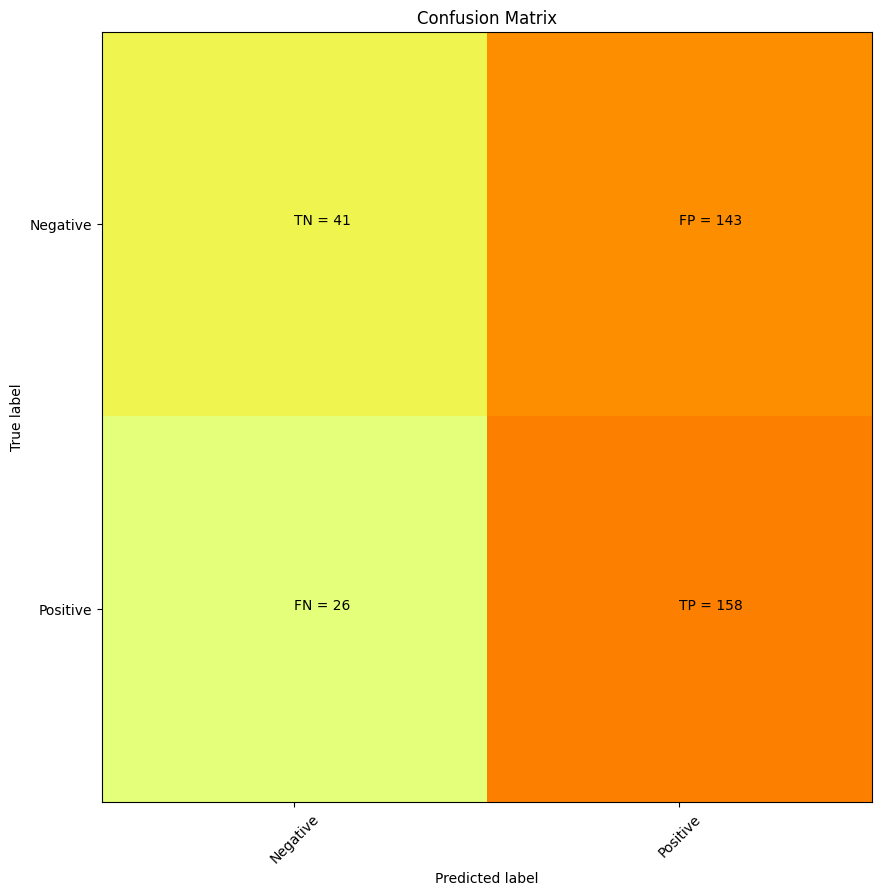

['Original', 'CCL1'] precision = 0.5249169435215947 recall = 0.8586956521739131
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_71 (Dense)            (None, 256)               196864    
                                                                 
 dense_72 (Dense)            (None, 128)               32896     
                                                                 
 dense_73 (Dense)            (None, 64)                8256      
                                                                 
 dense_74 (Dense)            (None, 32)                2080      
                                                                 
 dense_75 (Dense)            (None, 1)                 33        
                                                 

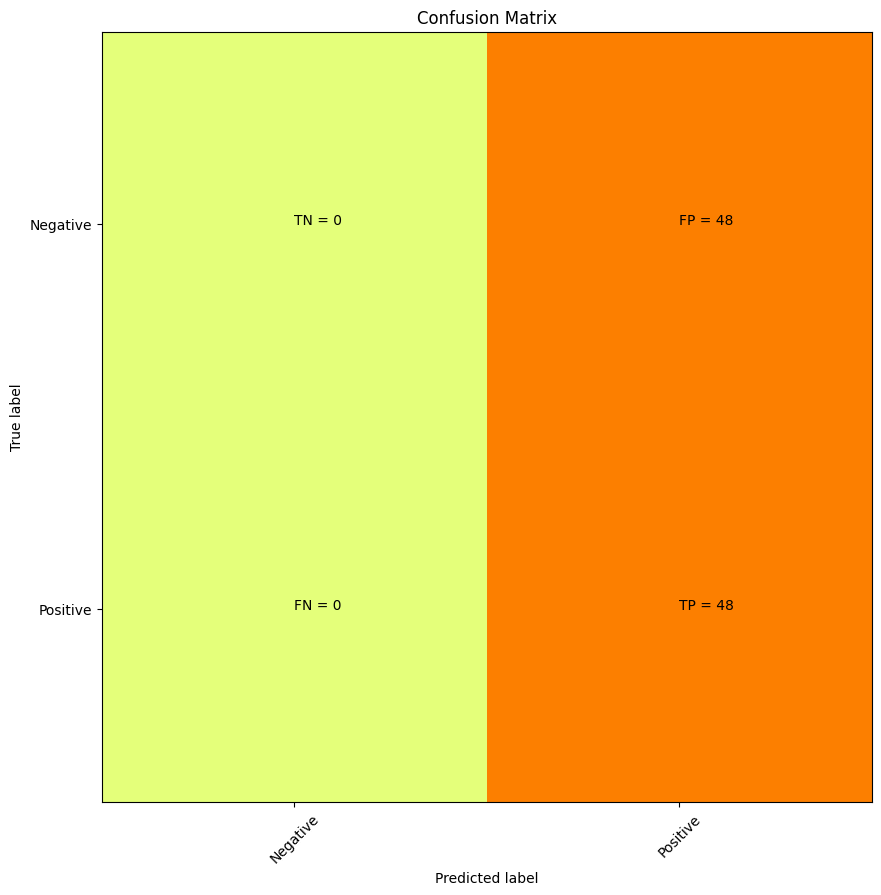

['Original', 'CCL19'] precision = 0.5 recall = 1.0
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_76 (Dense)            (None, 256)               196864    
                                                                 
 dense_77 (Dense)            (None, 128)               32896     
                                                                 
 dense_78 (Dense)            (None, 64)                8256      
                                                                 
 dense_79 (Dense)            (None, 32)                2080      
                                                                 
 dense_80 (Dense)            (None, 1)                 33        
                                                                 
Total params

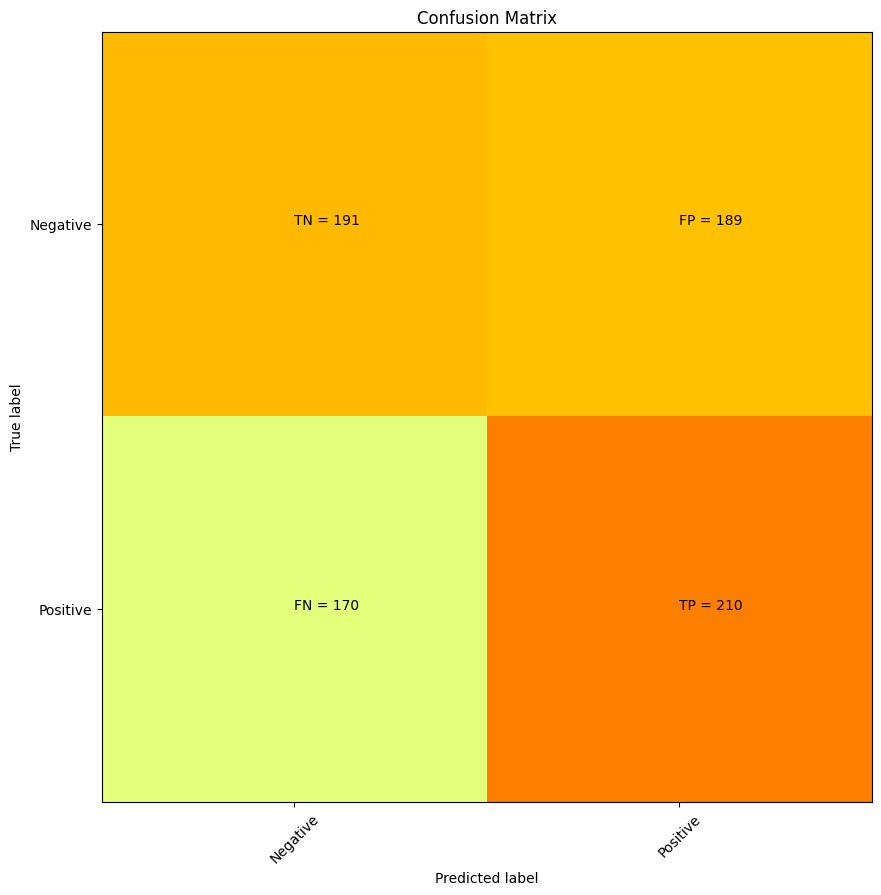

['Original', 'CCL2'] precision = 0.5263157894736842 recall = 0.5526315789473685
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_81 (Dense)            (None, 256)               196864    
                                                                 
 dense_82 (Dense)            (None, 128)               32896     
                                                                 
 dense_83 (Dense)            (None, 64)                8256      
                                                                 
 dense_84 (Dense)            (None, 32)                2080      
                                                                 
 dense_85 (Dense)            (None, 1)                 33        
                                                 

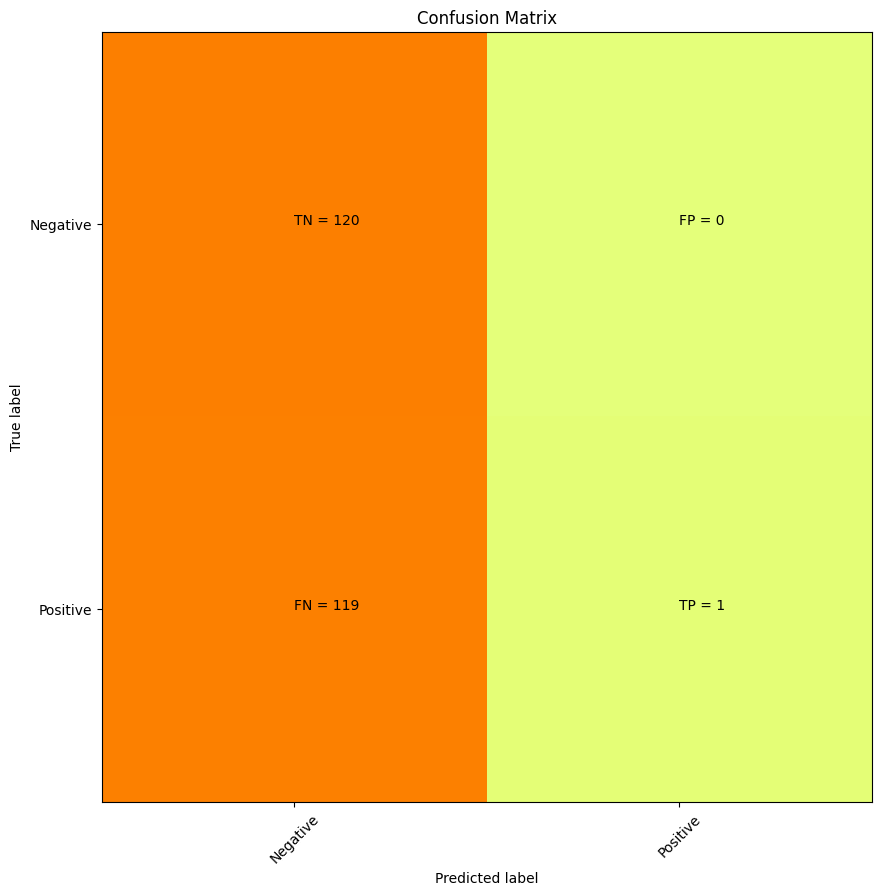

['Original', 'CCL20'] precision = 1.0 recall = 0.008333333333333333
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_86 (Dense)            (None, 256)               196864    
                                                                 
 dense_87 (Dense)            (None, 128)               32896     
                                                                 
 dense_88 (Dense)            (None, 64)                8256      
                                                                 
 dense_89 (Dense)            (None, 32)                2080      
                                                                 
 dense_90 (Dense)            (None, 1)                 33        
                                                             

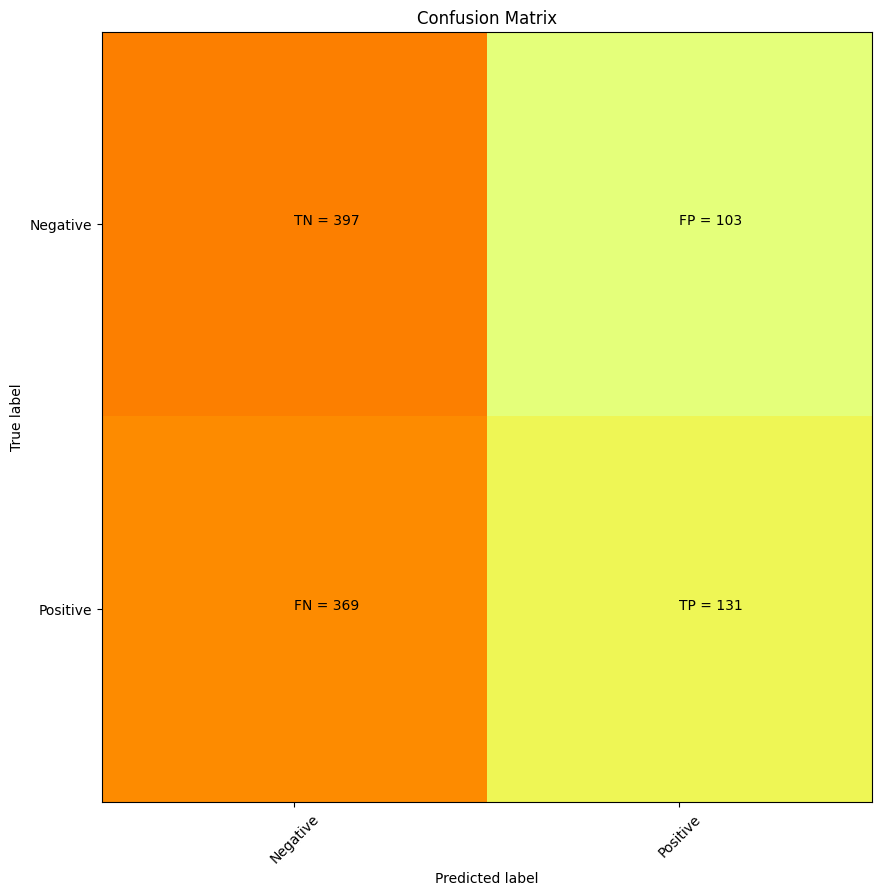

['Original', 'CCL22'] precision = 0.5598290598290598 recall = 0.262
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_91 (Dense)            (None, 256)               196864    
                                                                 
 dense_92 (Dense)            (None, 128)               32896     
                                                                 
 dense_93 (Dense)            (None, 64)                8256      
                                                                 
 dense_94 (Dense)            (None, 32)                2080      
                                                                 
 dense_95 (Dense)            (None, 1)                 33        
                                                             

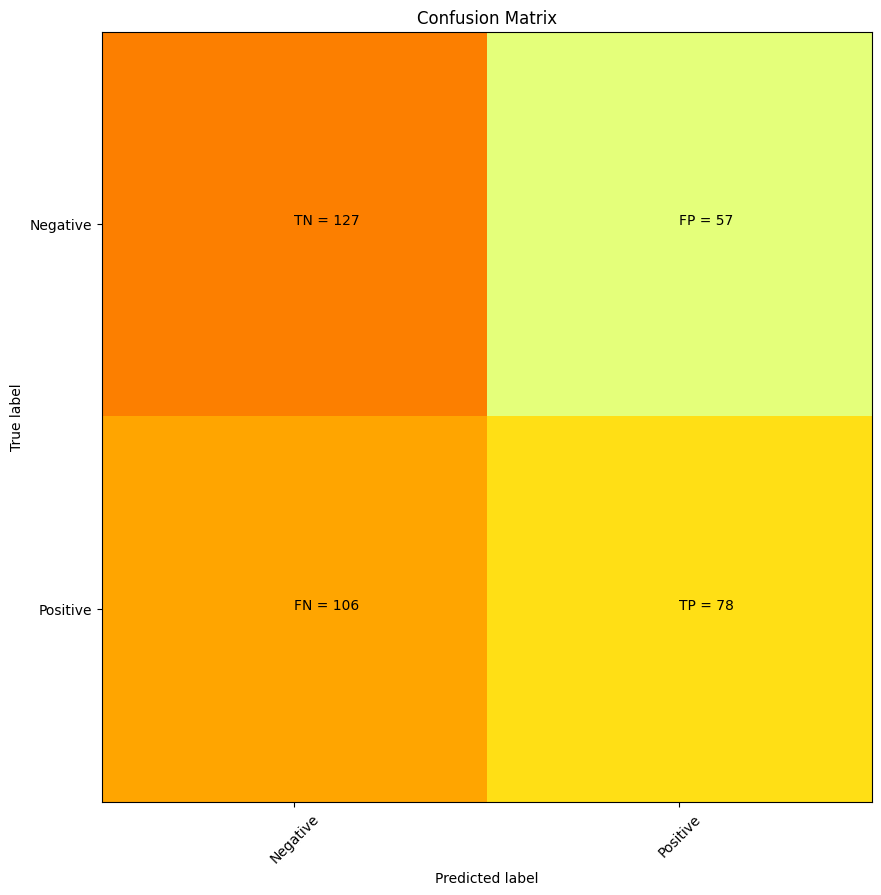

['Original', 'CCL4'] precision = 0.5777777777777777 recall = 0.42391304347826086
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_96 (Dense)            (None, 256)               196864    
                                                                 
 dense_97 (Dense)            (None, 128)               32896     
                                                                 
 dense_98 (Dense)            (None, 64)                8256      
                                                                 
 dense_99 (Dense)            (None, 32)                2080      
                                                                 
 dense_100 (Dense)           (None, 1)                 33        
                                                

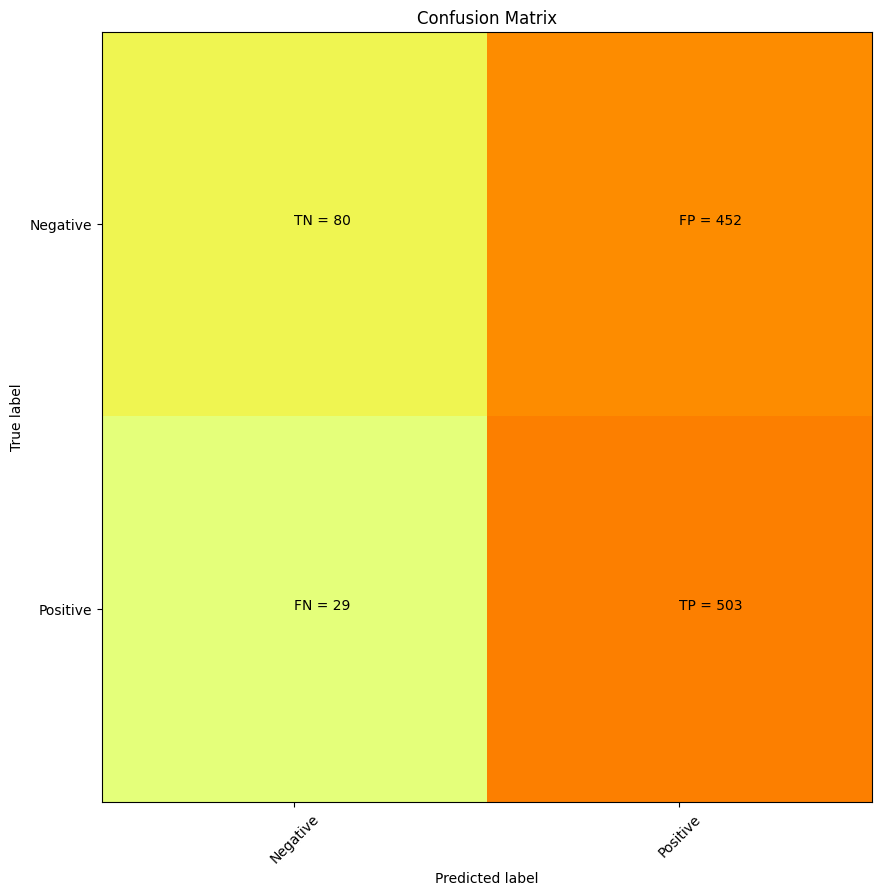

['Original', 'CCL5'] precision = 0.5267015706806283 recall = 0.9454887218045113
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_101 (Dense)           (None, 256)               196864    
                                                                 
 dense_102 (Dense)           (None, 128)               32896     
                                                                 
 dense_103 (Dense)           (None, 64)                8256      
                                                                 
 dense_104 (Dense)           (None, 32)                2080      
                                                                 
 dense_105 (Dense)           (None, 1)                 33        
                                                 

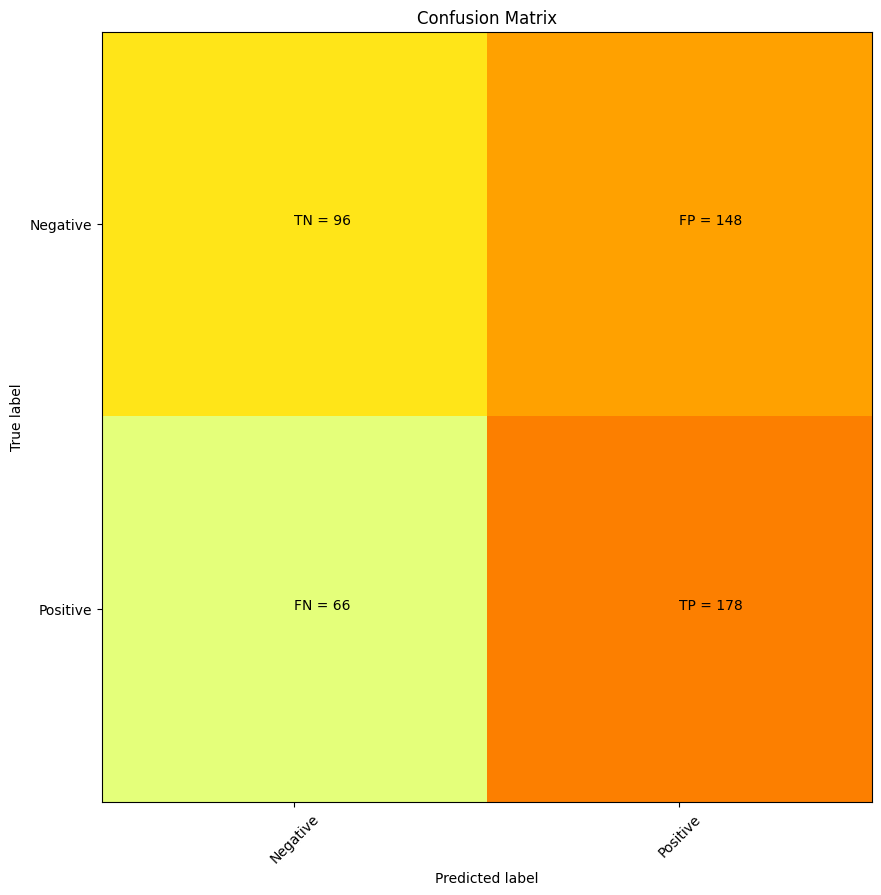

['Original', 'CD14'] precision = 0.5460122699386503 recall = 0.7295081967213115
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_106 (Dense)           (None, 256)               196864    
                                                                 
 dense_107 (Dense)           (None, 128)               32896     
                                                                 
 dense_108 (Dense)           (None, 64)                8256      
                                                                 
 dense_109 (Dense)           (None, 32)                2080      
                                                                 
 dense_110 (Dense)           (None, 1)                 33        
                                                 

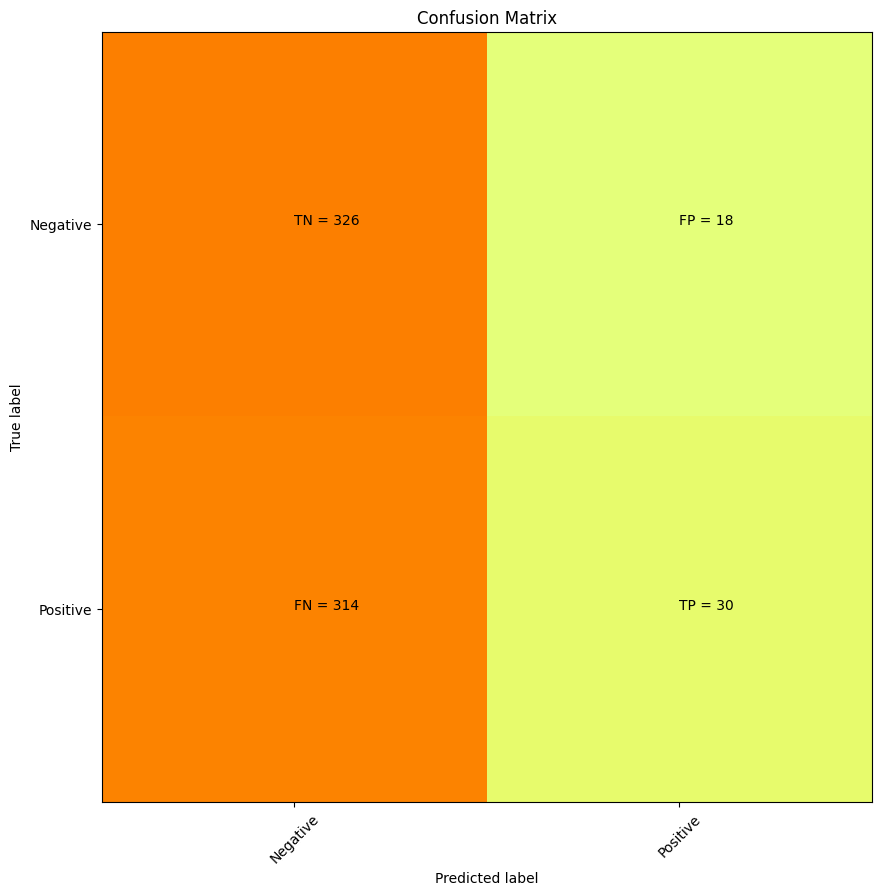

['Original', 'CRP'] precision = 0.625 recall = 0.0872093023255814
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_111 (Dense)           (None, 256)               196864    
                                                                 
 dense_112 (Dense)           (None, 128)               32896     
                                                                 
 dense_113 (Dense)           (None, 64)                8256      
                                                                 
 dense_114 (Dense)           (None, 32)                2080      
                                                                 
 dense_115 (Dense)           (None, 1)                 33        
                                                               

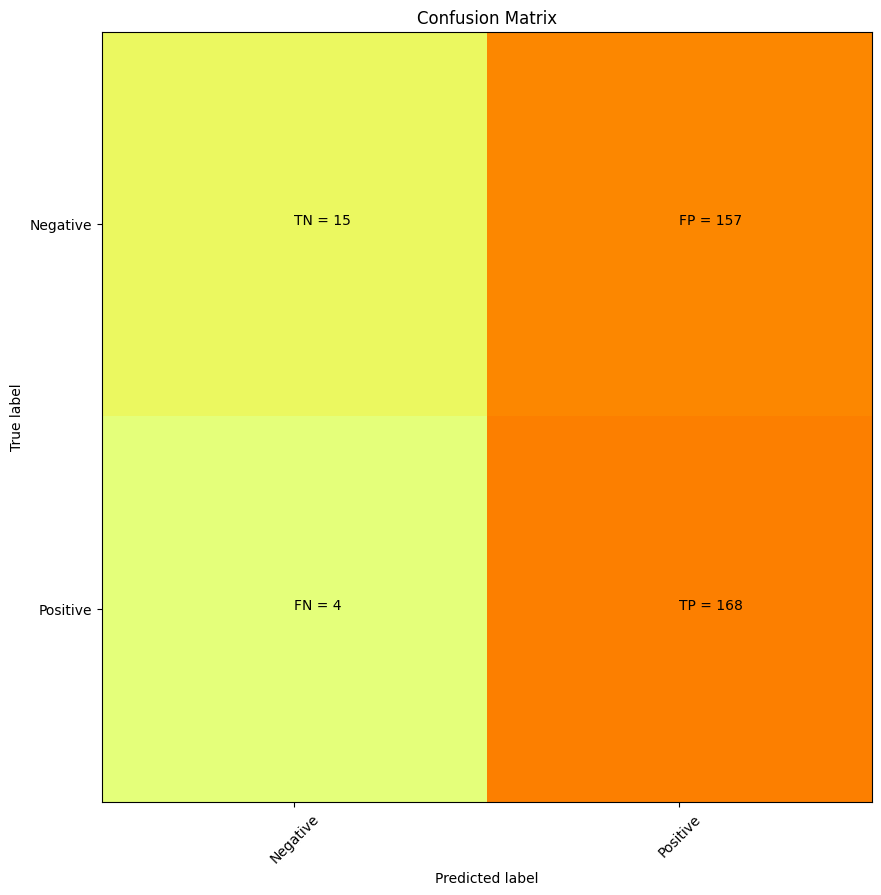

['Original', 'CXCL1'] precision = 0.5169230769230769 recall = 0.9767441860465116
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_116 (Dense)           (None, 256)               196864    
                                                                 
 dense_117 (Dense)           (None, 128)               32896     
                                                                 
 dense_118 (Dense)           (None, 64)                8256      
                                                                 
 dense_119 (Dense)           (None, 32)                2080      
                                                                 
 dense_120 (Dense)           (None, 1)                 33        
                                                

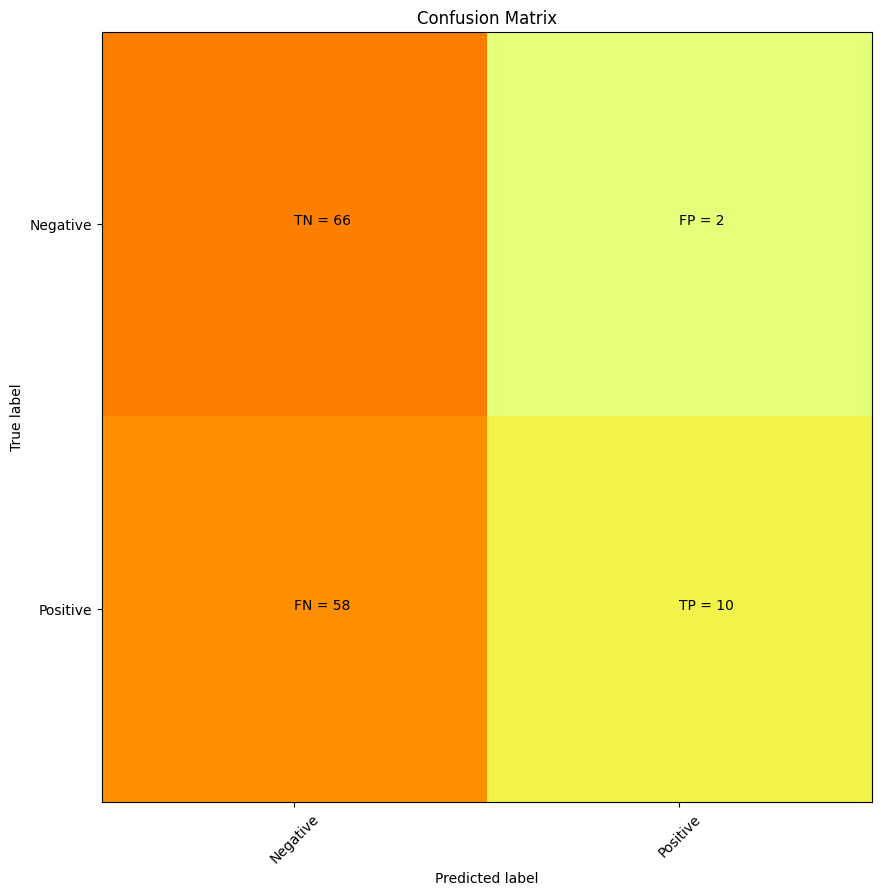

['Original', 'CXCL10'] precision = 0.8333333333333334 recall = 0.14705882352941177
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_121 (Dense)           (None, 256)               196864    
                                                                 
 dense_122 (Dense)           (None, 128)               32896     
                                                                 
 dense_123 (Dense)           (None, 64)                8256      
                                                                 
 dense_124 (Dense)           (None, 32)                2080      
                                                                 
 dense_125 (Dense)           (None, 1)                 33        
                                              

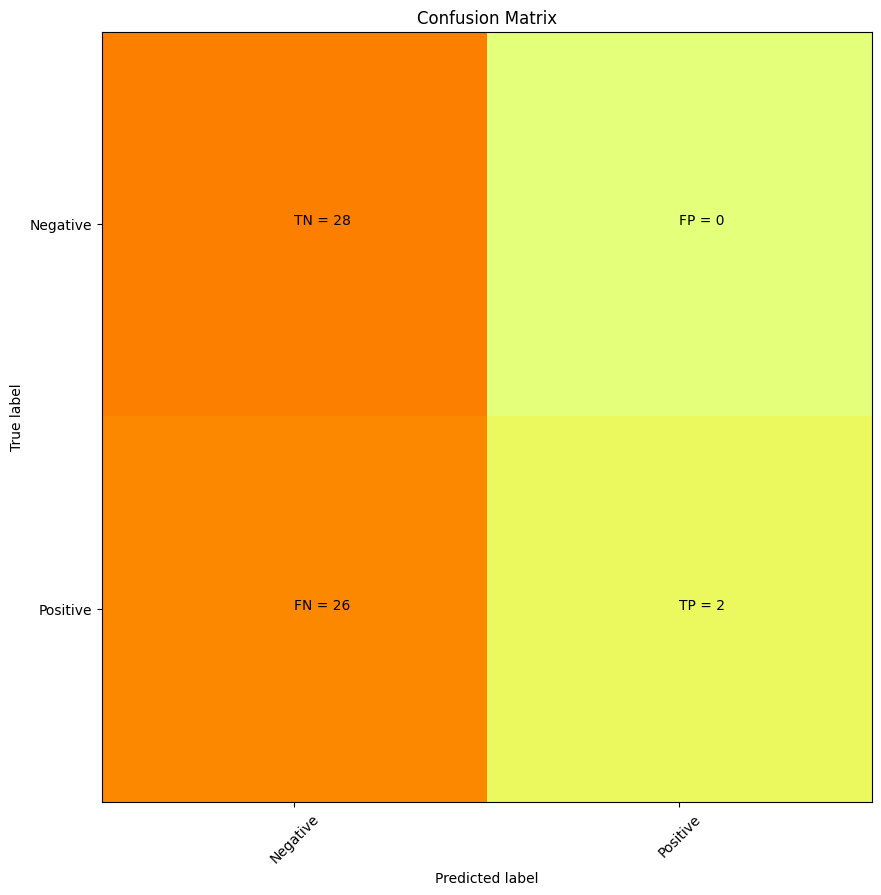

['Original', 'CXCL13'] precision = 1.0 recall = 0.07142857142857142
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_126 (Dense)           (None, 256)               196864    
                                                                 
 dense_127 (Dense)           (None, 128)               32896     
                                                                 
 dense_128 (Dense)           (None, 64)                8256      
                                                                 
 dense_129 (Dense)           (None, 32)                2080      
                                                                 
 dense_130 (Dense)           (None, 1)                 33        
                                                             

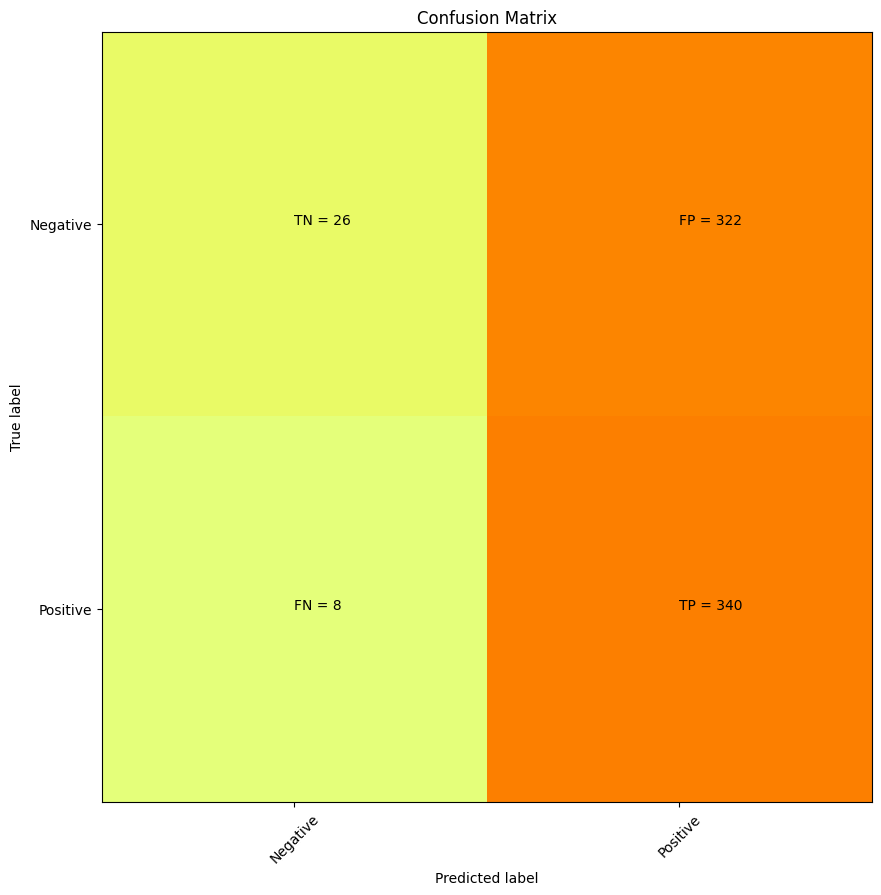

['Original', 'CXCL3'] precision = 0.513595166163142 recall = 0.9770114942528736
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_131 (Dense)           (None, 256)               196864    
                                                                 
 dense_132 (Dense)           (None, 128)               32896     
                                                                 
 dense_133 (Dense)           (None, 64)                8256      
                                                                 
 dense_134 (Dense)           (None, 32)                2080      
                                                                 
 dense_135 (Dense)           (None, 1)                 33        
                                                 

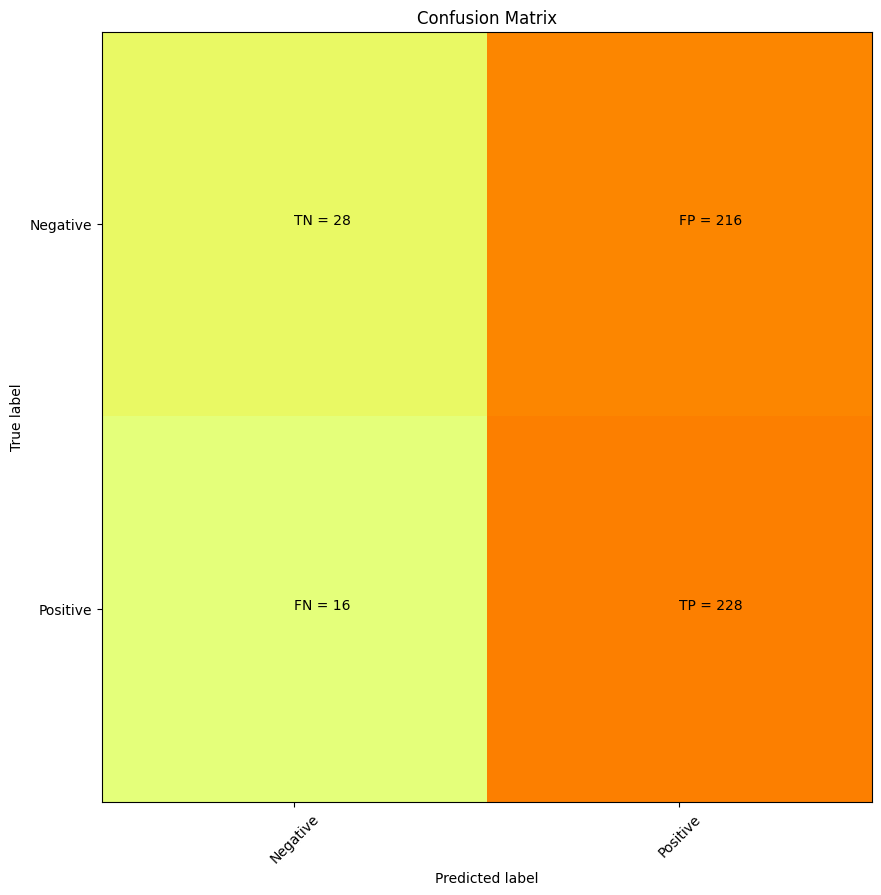

['Original', 'CXCL5'] precision = 0.5135135135135135 recall = 0.9344262295081968
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_136 (Dense)           (None, 256)               196864    
                                                                 
 dense_137 (Dense)           (None, 128)               32896     
                                                                 
 dense_138 (Dense)           (None, 64)                8256      
                                                                 
 dense_139 (Dense)           (None, 32)                2080      
                                                                 
 dense_140 (Dense)           (None, 1)                 33        
                                                

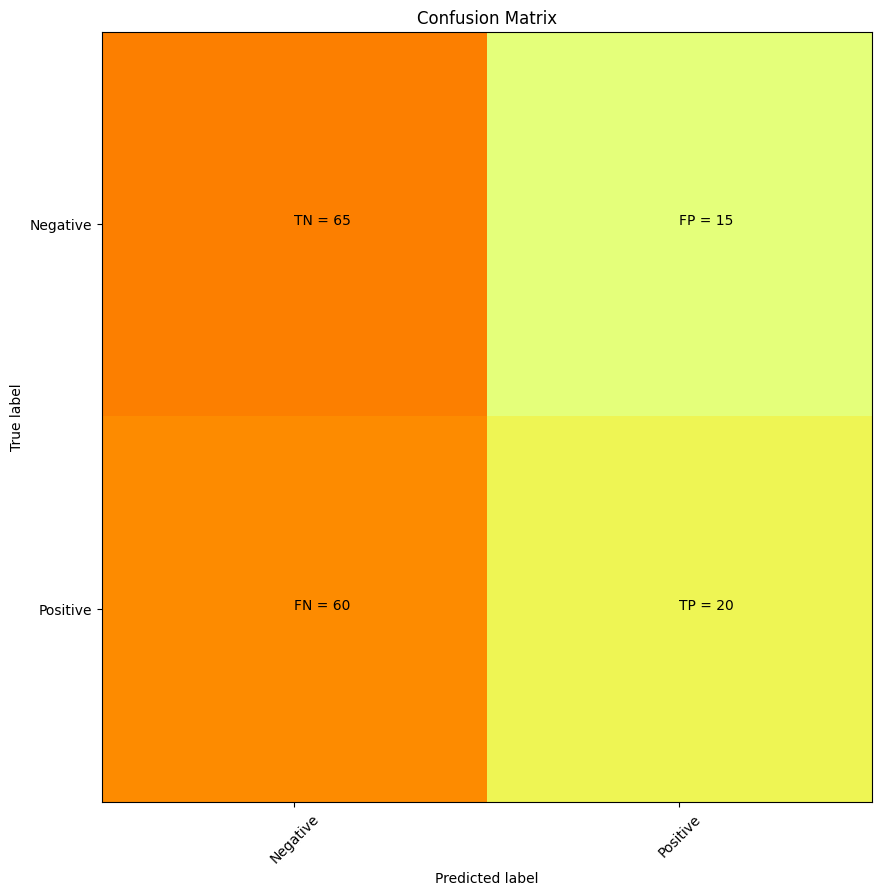

['Original', 'G-CSF'] precision = 0.5714285714285714 recall = 0.25
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_141 (Dense)           (None, 256)               196864    
                                                                 
 dense_142 (Dense)           (None, 128)               32896     
                                                                 
 dense_143 (Dense)           (None, 64)                8256      
                                                                 
 dense_144 (Dense)           (None, 32)                2080      
                                                                 
 dense_145 (Dense)           (None, 1)                 33        
                                                              

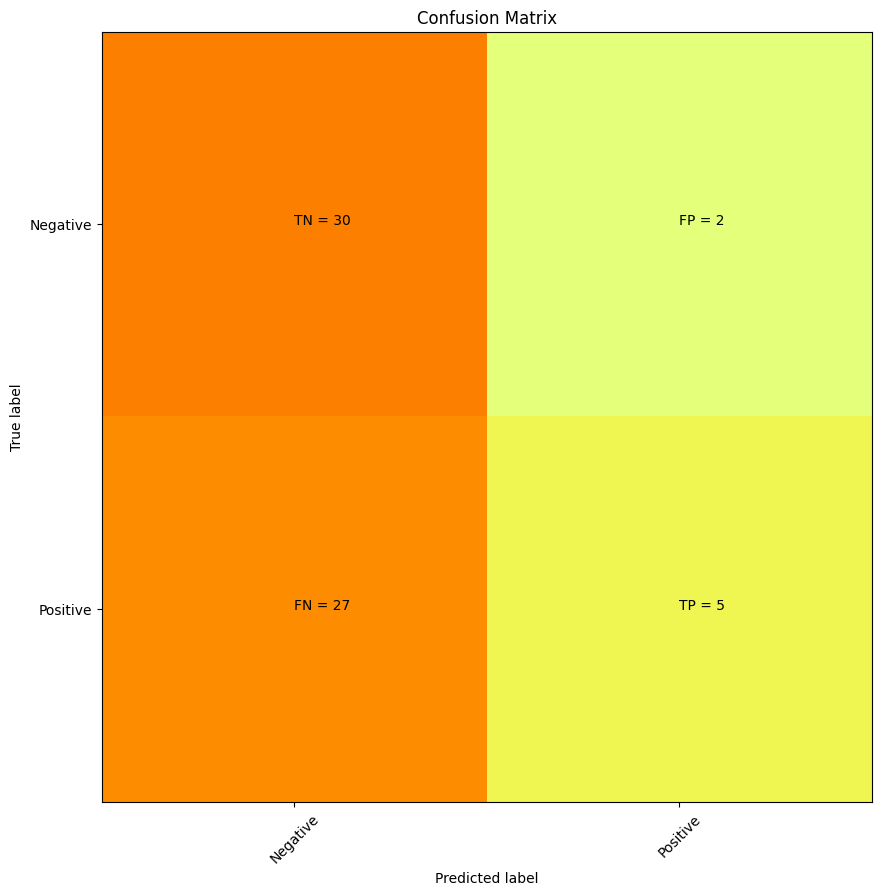

['Original', 'GM-CSF'] precision = 0.7142857142857143 recall = 0.15625
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_146 (Dense)           (None, 256)               196864    
                                                                 
 dense_147 (Dense)           (None, 128)               32896     
                                                                 
 dense_148 (Dense)           (None, 64)                8256      
                                                                 
 dense_149 (Dense)           (None, 32)                2080      
                                                                 
 dense_150 (Dense)           (None, 1)                 33        
                                                          

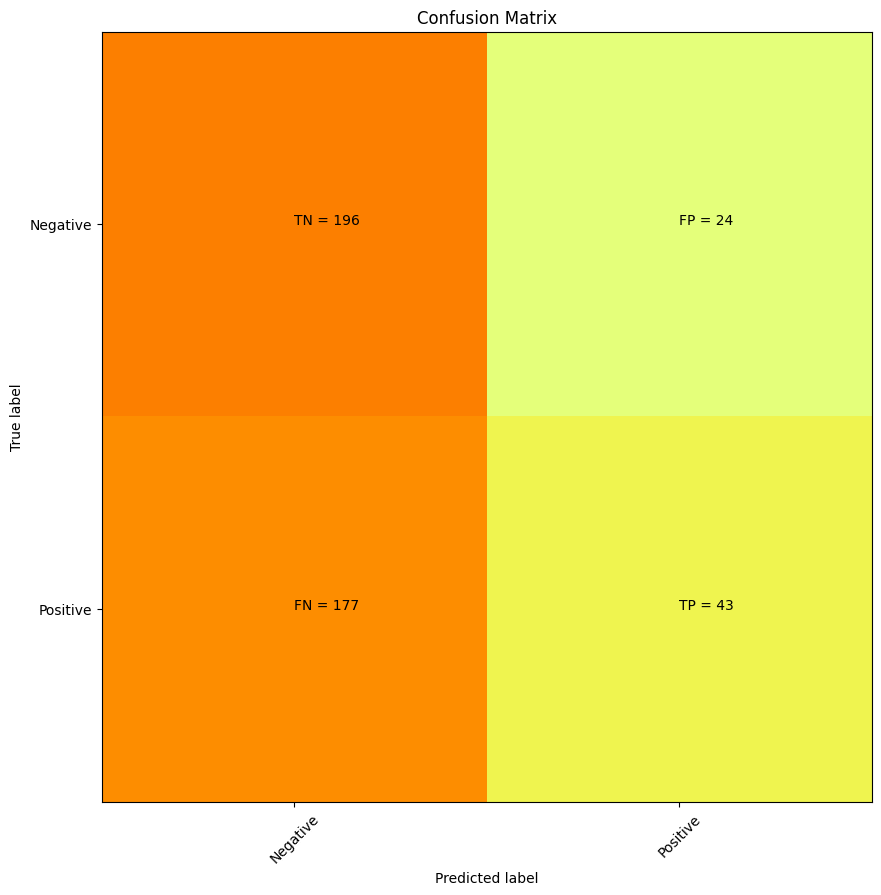

['Original', 'IL-1 alpha'] precision = 0.6417910447761194 recall = 0.19545454545454546
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_151 (Dense)           (None, 256)               196864    
                                                                 
 dense_152 (Dense)           (None, 128)               32896     
                                                                 
 dense_153 (Dense)           (None, 64)                8256      
                                                                 
 dense_154 (Dense)           (None, 32)                2080      
                                                                 
 dense_155 (Dense)           (None, 1)                 33        
                                          

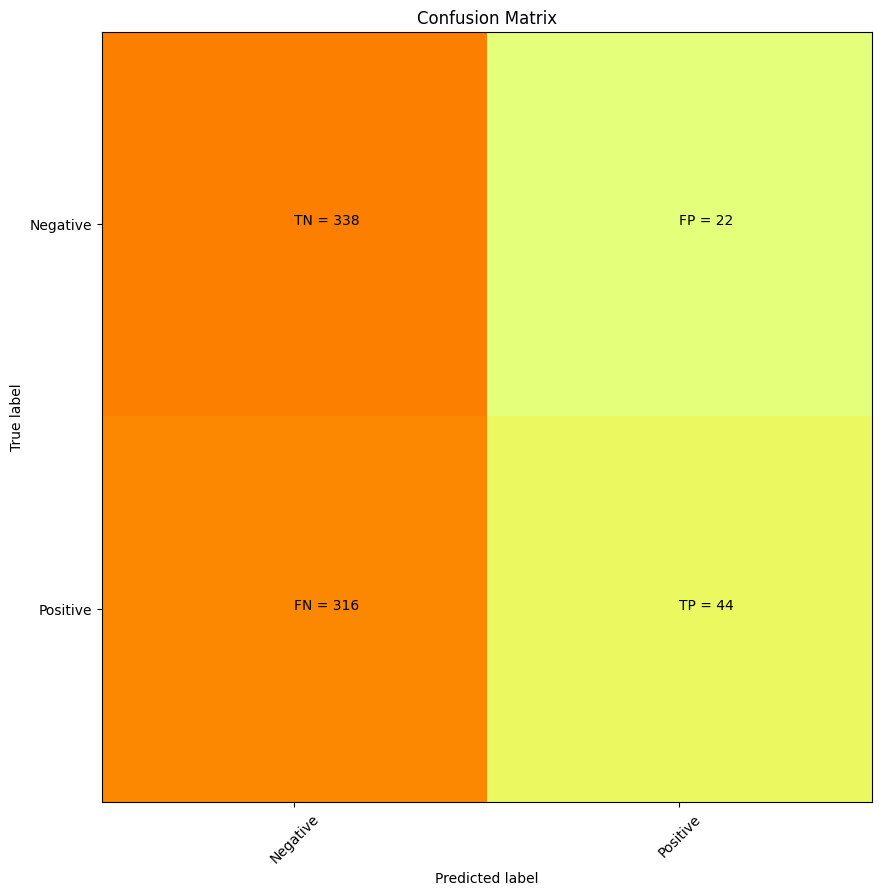

['Original', 'IL-1 beta'] precision = 0.6666666666666666 recall = 0.12222222222222222
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_156 (Dense)           (None, 256)               196864    
                                                                 
 dense_157 (Dense)           (None, 128)               32896     
                                                                 
 dense_158 (Dense)           (None, 64)                8256      
                                                                 
 dense_159 (Dense)           (None, 32)                2080      
                                                                 
 dense_160 (Dense)           (None, 1)                 33        
                                           

<ipython-input-19-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


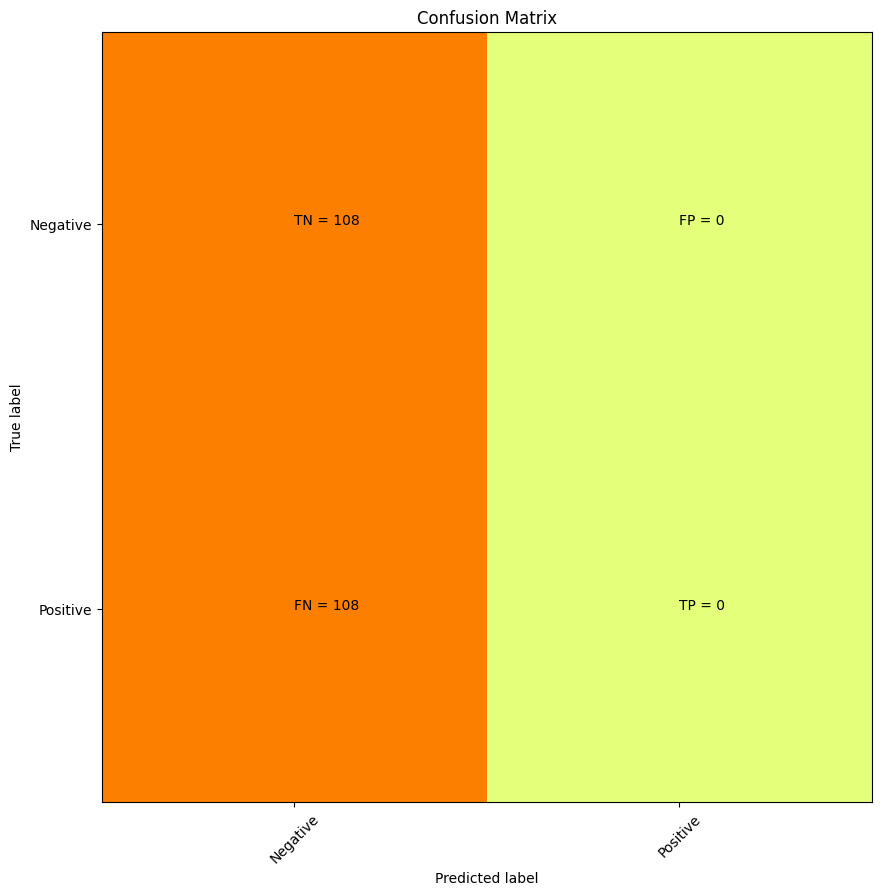

['Original', 'IL-12 p40'] precision = nan recall = 0.0
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_161 (Dense)           (None, 256)               196864    
                                                                 
 dense_162 (Dense)           (None, 128)               32896     
                                                                 
 dense_163 (Dense)           (None, 64)                8256      
                                                                 
 dense_164 (Dense)           (None, 32)                2080      
                                                                 
 dense_165 (Dense)           (None, 1)                 33        
                                                                 
Total pa

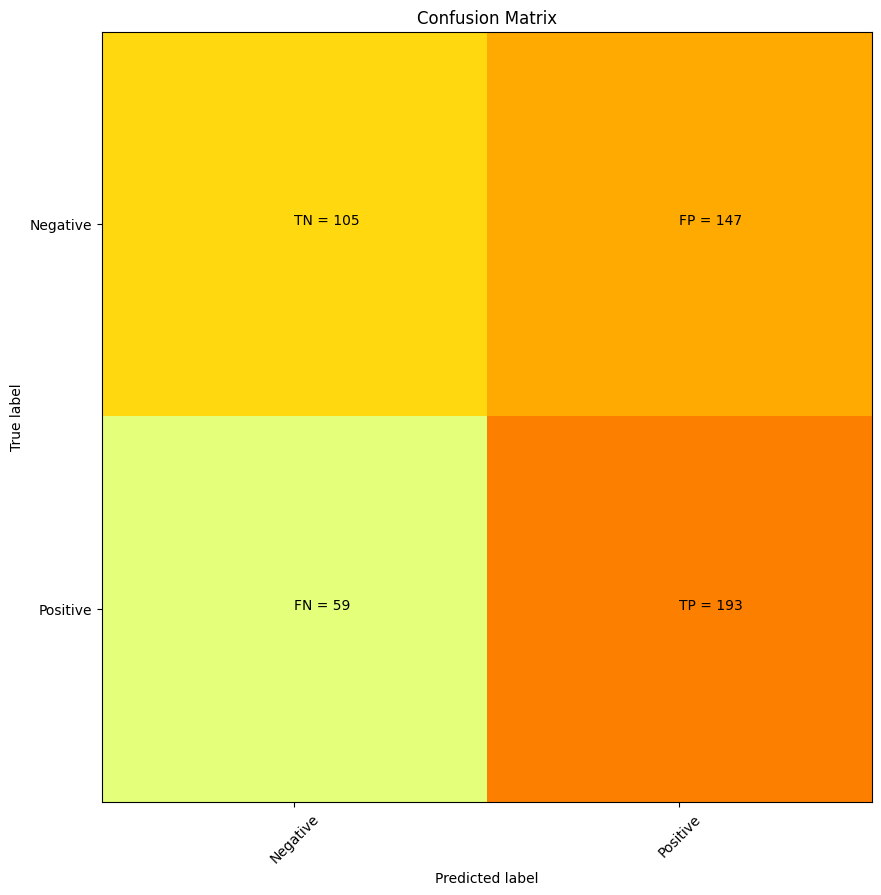

['Original', 'IL-16'] precision = 0.5676470588235294 recall = 0.7658730158730159
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_166 (Dense)           (None, 256)               196864    
                                                                 
 dense_167 (Dense)           (None, 128)               32896     
                                                                 
 dense_168 (Dense)           (None, 64)                8256      
                                                                 
 dense_169 (Dense)           (None, 32)                2080      
                                                                 
 dense_170 (Dense)           (None, 1)                 33        
                                                

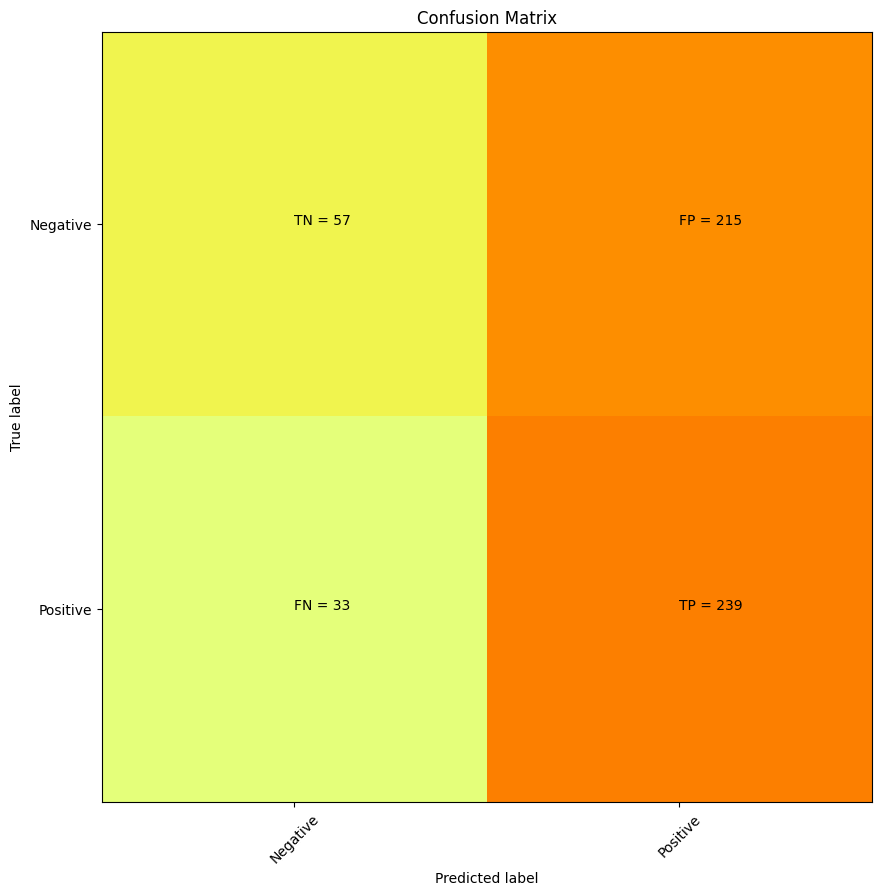

['Original', 'IL-6 R alpha'] precision = 0.526431718061674 recall = 0.8786764705882353
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_171 (Dense)           (None, 256)               196864    
                                                                 
 dense_172 (Dense)           (None, 128)               32896     
                                                                 
 dense_173 (Dense)           (None, 64)                8256      
                                                                 
 dense_174 (Dense)           (None, 32)                2080      
                                                                 
 dense_175 (Dense)           (None, 1)                 33        
                                          

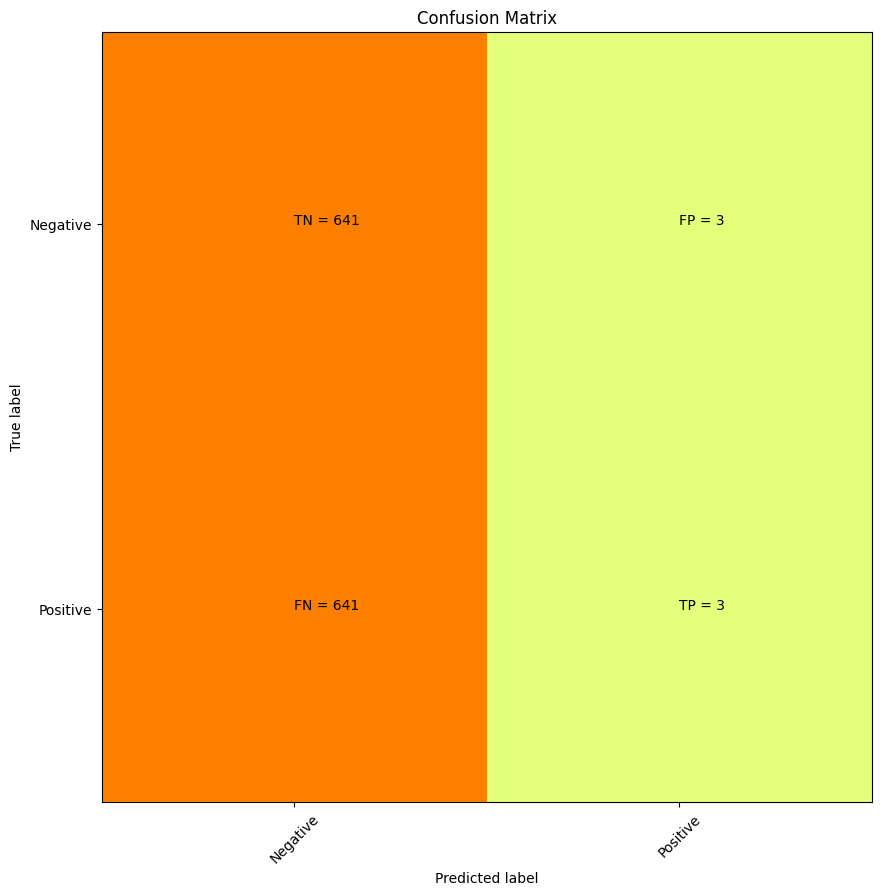

['Original', 'IL-6'] precision = 0.5 recall = 0.004658385093167702
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_176 (Dense)           (None, 256)               196864    
                                                                 
 dense_177 (Dense)           (None, 128)               32896     
                                                                 
 dense_178 (Dense)           (None, 64)                8256      
                                                                 
 dense_179 (Dense)           (None, 32)                2080      
                                                                 
 dense_180 (Dense)           (None, 1)                 33        
                                                              

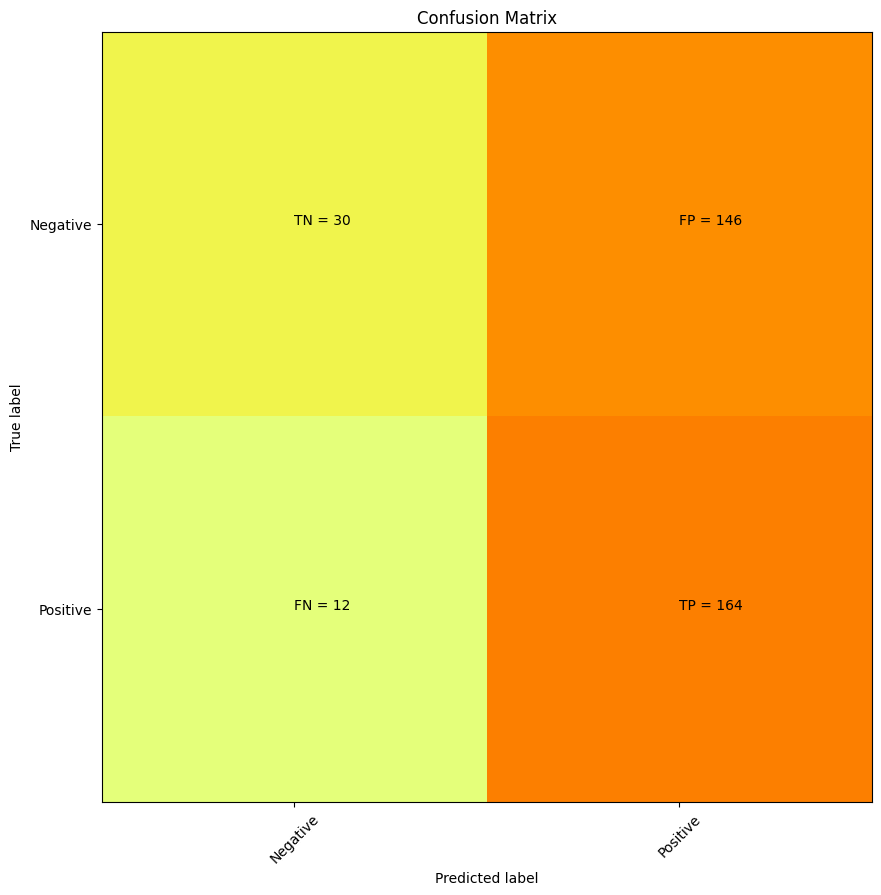

['Original', 'IL-8'] precision = 0.5290322580645161 recall = 0.9318181818181818
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_181 (Dense)           (None, 256)               196864    
                                                                 
 dense_182 (Dense)           (None, 128)               32896     
                                                                 
 dense_183 (Dense)           (None, 64)                8256      
                                                                 
 dense_184 (Dense)           (None, 32)                2080      
                                                                 
 dense_185 (Dense)           (None, 1)                 33        
                                                 

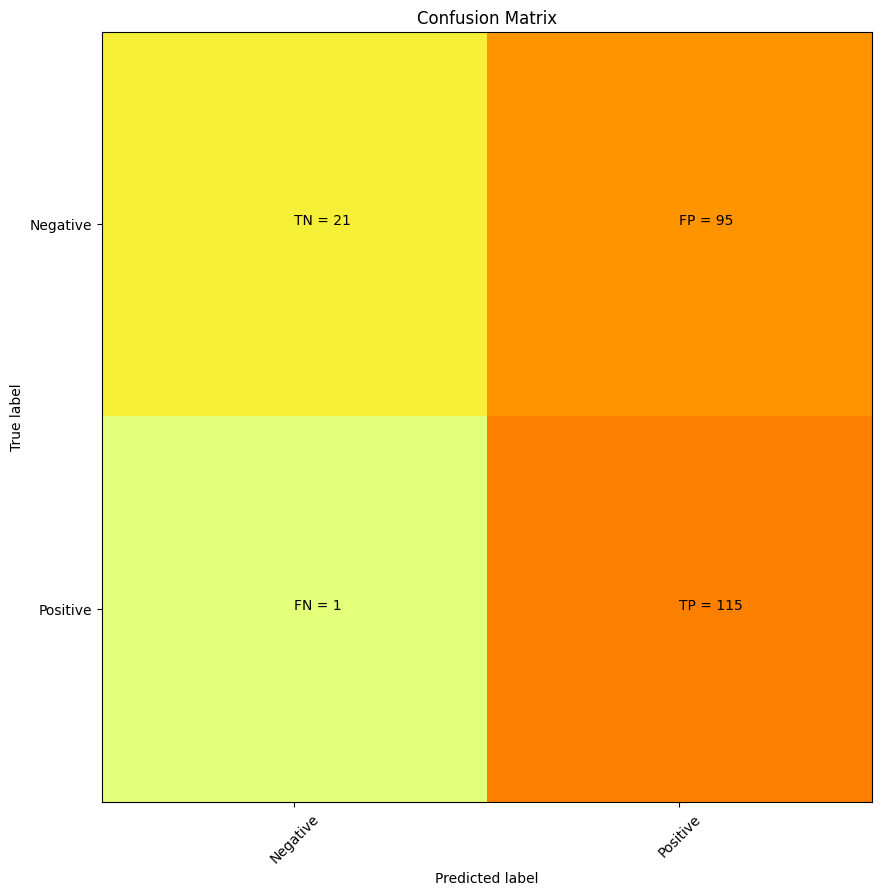

['Original', 'MMP-9'] precision = 0.5476190476190477 recall = 0.9913793103448276
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_186 (Dense)           (None, 256)               196864    
                                                                 
 dense_187 (Dense)           (None, 128)               32896     
                                                                 
 dense_188 (Dense)           (None, 64)                8256      
                                                                 
 dense_189 (Dense)           (None, 32)                2080      
                                                                 
 dense_190 (Dense)           (None, 1)                 33        
                                                

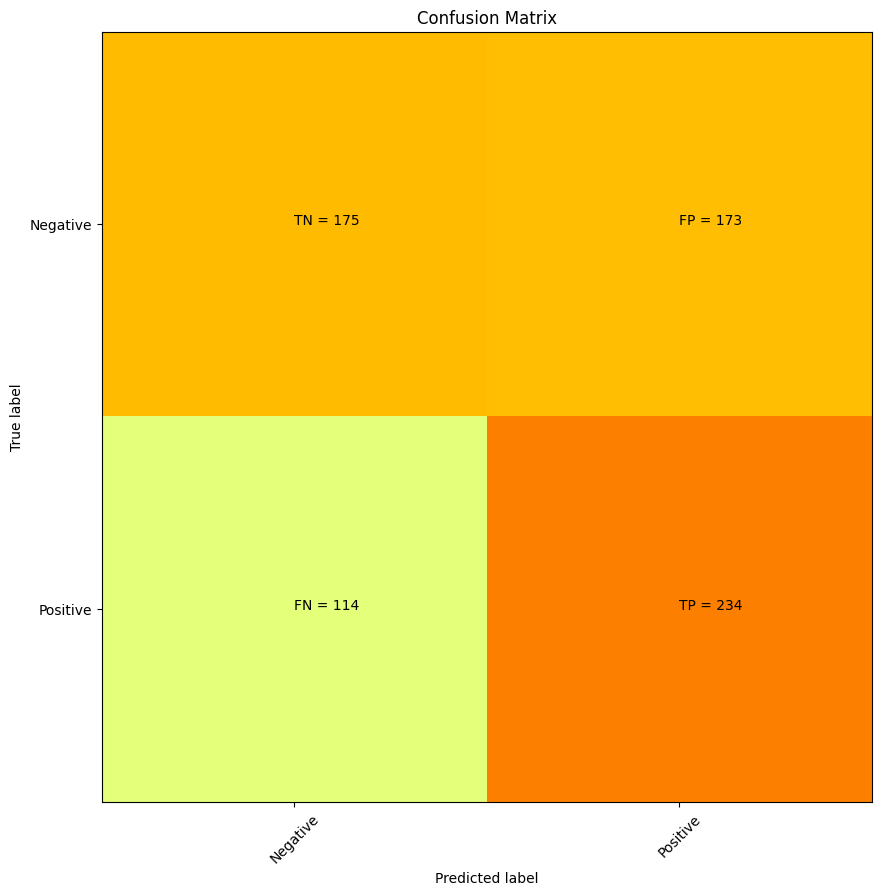

['Original', 'TNF RII'] precision = 0.5749385749385749 recall = 0.6724137931034483
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_191 (Dense)           (None, 256)               196864    
                                                                 
 dense_192 (Dense)           (None, 128)               32896     
                                                                 
 dense_193 (Dense)           (None, 64)                8256      
                                                                 
 dense_194 (Dense)           (None, 32)                2080      
                                                                 
 dense_195 (Dense)           (None, 1)                 33        
                                              

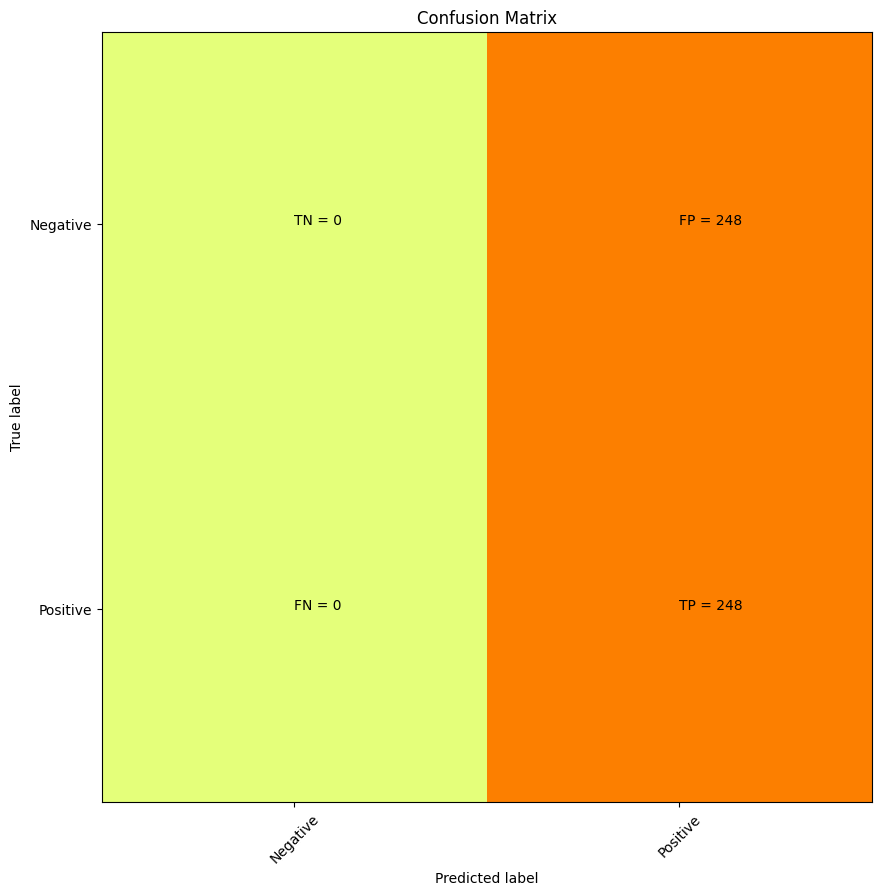

['Original', 'TNF alpha'] precision = 0.5 recall = 1.0
Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87420672  
                                                                 
 dense_196 (Dense)           (None, 256)               196864    
                                                                 
 dense_197 (Dense)           (None, 128)               32896     
                                                                 
 dense_198 (Dense)           (None, 64)                8256      
                                                                 
 dense_199 (Dense)           (None, 32)                2080      
                                                                 
 dense_200 (Dense)           (None, 1)                 33        
                                                                 
Total pa

In [23]:
#This code block takes about 56 minutes

#output is verbose, if you want to see confusion matrices please go to next code block down

#Best loss function is binary cross entropy
#source: https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
#"Cross-entropy is the default loss function to use for binary classification problems.
#It is intended for use with binary classification where the target values are in the set {0, 1}.
#Mathematically, it is the preferred loss function under the inference framework of maximum likelihood.
#It is the loss function to be evaluated first and only changed if you have a good reason."


totalresultsvit_1 = []

totalresultsvit_1_answer = []



for df in longdfs:
  indices = list(df.index.values)
  features = []
  for i in indices:
    thing = total_scaled_arrays[i]
    features.append(thing)
    thing2 = total_scaled_arrays[i+384]
    features.append(thing2)
    thing3 = total_scaled_arrays[i+384+384]
    features.append(thing3)
    thing4 = total_scaled_arrays[i+384+384+384]
    features.append(thing4)


  target = list(df.iloc[:,0:1].values)

  target2 = [target for i in range(4)]
#this is 2 arrays
#put them together without separation to match structure of features
  target2final = []
  for i in target2:
    target2final = target2final+i

  print("features",len(features))
  print("target", len(target2final))

  X_train, X_test, y_train, y_test = train_test_split(features, target2final, test_size=0.3)

#reshaping gray scale images so that we can use the RGB transformer

  for i in range(len(X_test)):
    X_test[i] = np.stack((X_test[i],)*3, axis=-1)
    X_test[i] = np.squeeze(X_test[i])

  for i in range(len(X_train)):
    X_train[i] = np.stack((X_train[i],)*3, axis=-1)
    X_train[i] = np.squeeze(X_train[i])


  # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
  # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


  train_images = np.array(X_train)
  train_labels = np.array(y_train)
  test_images = np.array(X_test)
  test_labels = np.array(y_test)

  print(test_images.shape)
  print(train_images.shape)

  model_list = []
  model_list.append(vit_model)


  #you can then add layers

  model_list.append(tf.keras.layers.Dense(256, activation = 'sigmoid'))

  model_list.append(tf.keras.layers.Dense(128, activation = 'sigmoid'))

  model_list.append(tf.keras.layers.Dense(64, activation = 'relu'))

  model_list.append(tf.keras.layers.Dense(32, activation = 'relu'))
  #final layer
  # model_list.append(tf.keras.layers.Dense(1, activation = 'softmax'))

  model_list.append(tf.keras.layers.Dense(1, activation="sigmoid"))
  #then
  model = tf.keras.Sequential(model_list,name='ViT')


  model.compile(optimizer='adam', loss='binary_crossentropy')
  # this is reported as the best for binary classifications

  model.fit(train_images, train_labels, epochs=5,
                    validation_data=(test_images, test_labels), batch_size=30)


  # history = model.fit(train_images, train_labels, epochs=10,
  #                   validation_data=(test_images, test_labels), batch_size=20)

  # ogresultsvit_1_history.append([history.history['accuracy'], history.history['val_accuracy'],
  #                    history.history['loss'], history.history['val_loss'], df.columns[0]])


  preds = []
  for i in range(len(features)):
    single = features[i]
    single = np.stack((single,)*3, axis=-1)
    single = np.squeeze(single)
    single = np.expand_dims(single, axis=0)
    preds.append(model.predict(single))
  preds

#this part of the code has changed slightly to accomodate the new single number output
  answer = []
  for i in range(len(preds)):
    if preds[i][0][0]<=0.5:
      answer.append(0)
    else:
      answer.append(1)
  answer

  confusio_matrix(target2final,answer, ['Original',df.columns[0]])

  totalresultsvit_1_answer.append([df.columns[0],answer])


  print(model.summary())

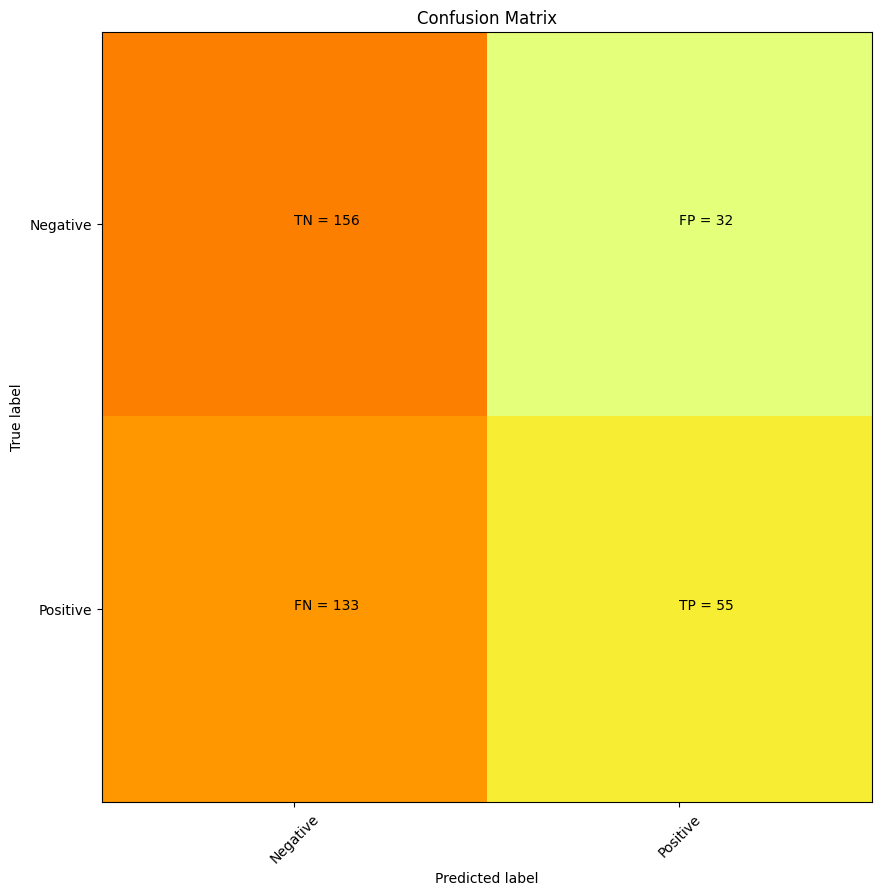

Activin A precision = 0.632183908045977 recall = 0.2925531914893617


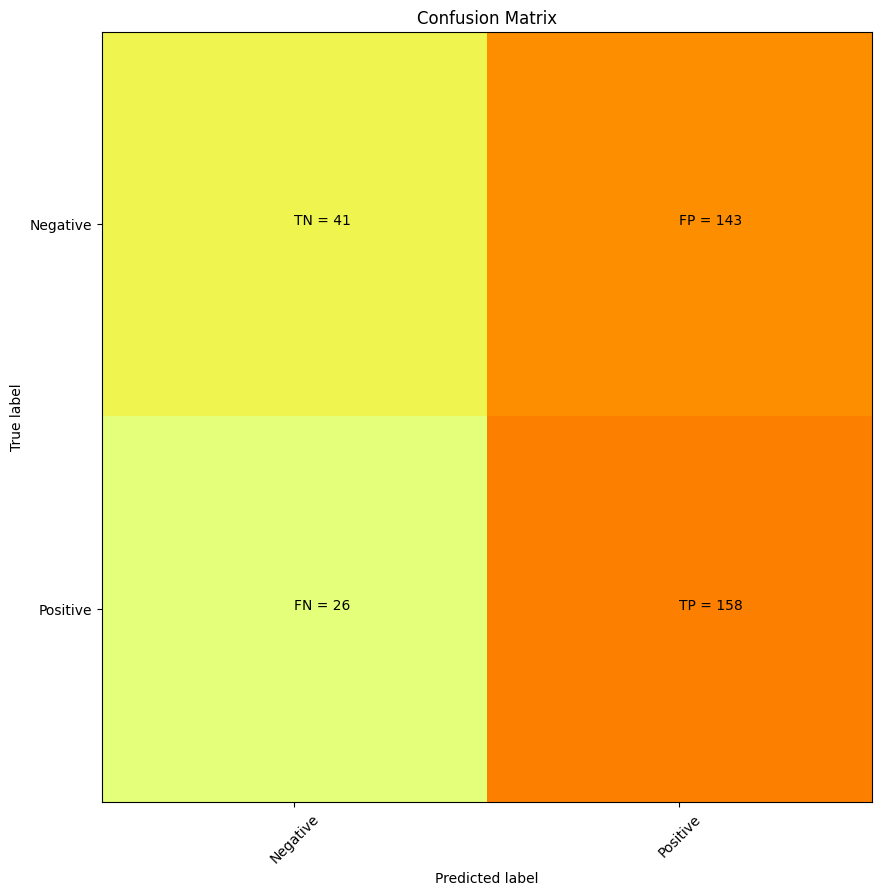

CCL1 precision = 0.5249169435215947 recall = 0.8586956521739131


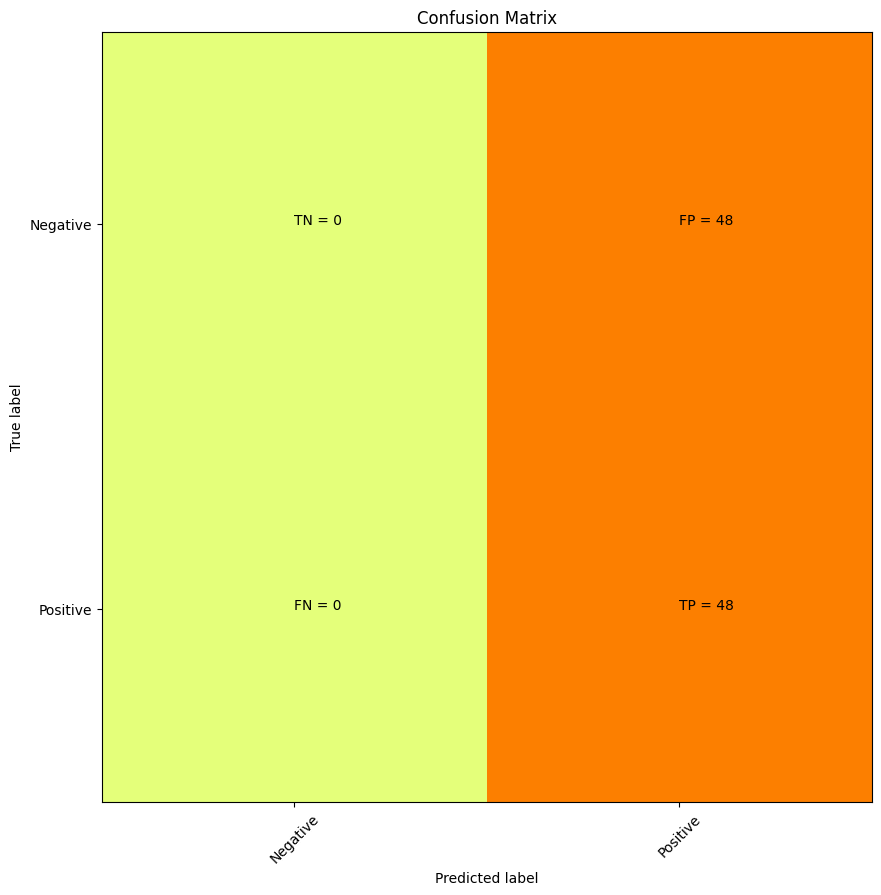

CCL19 precision = 0.5 recall = 1.0


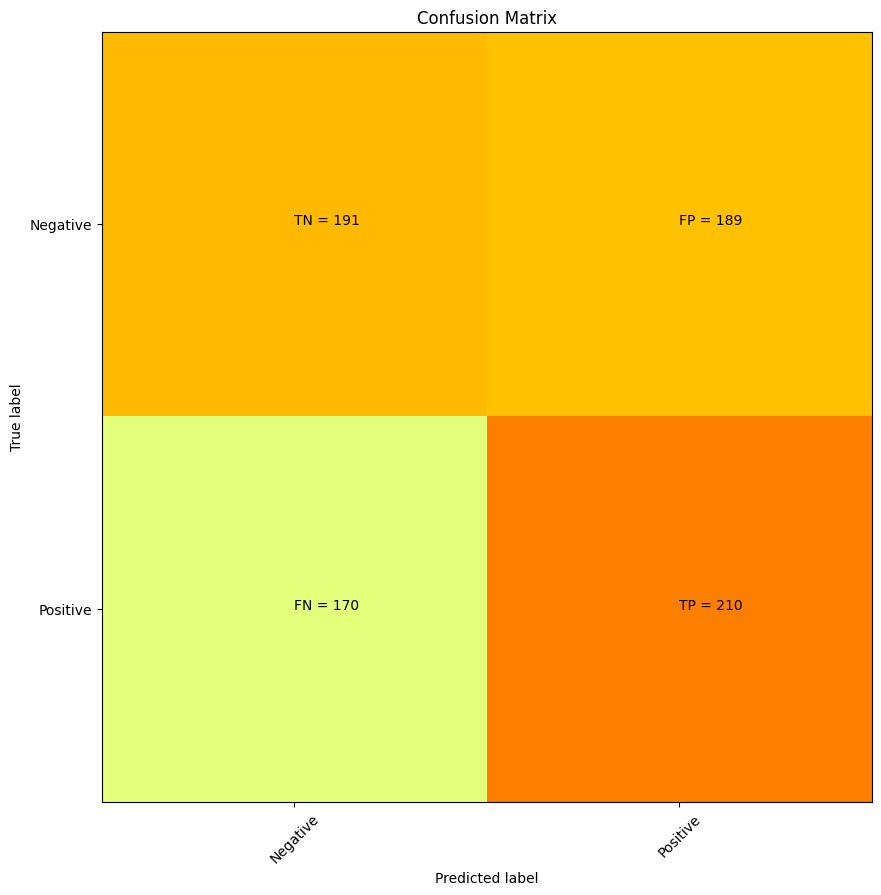

CCL2 precision = 0.5263157894736842 recall = 0.5526315789473685


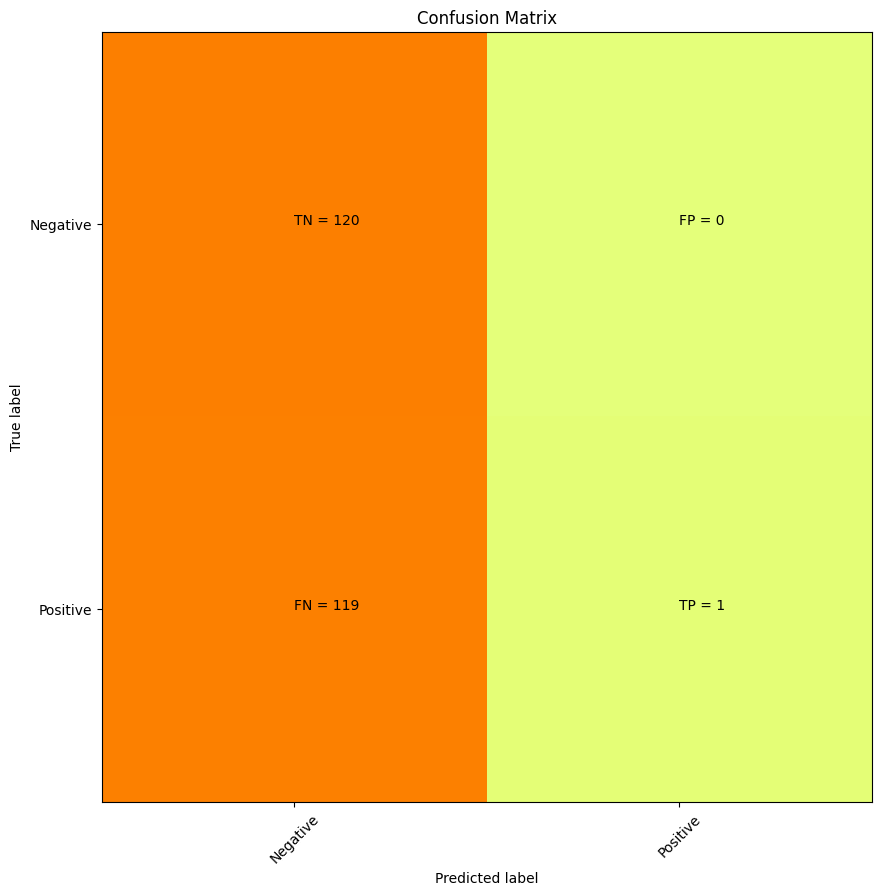

CCL20 precision = 1.0 recall = 0.008333333333333333


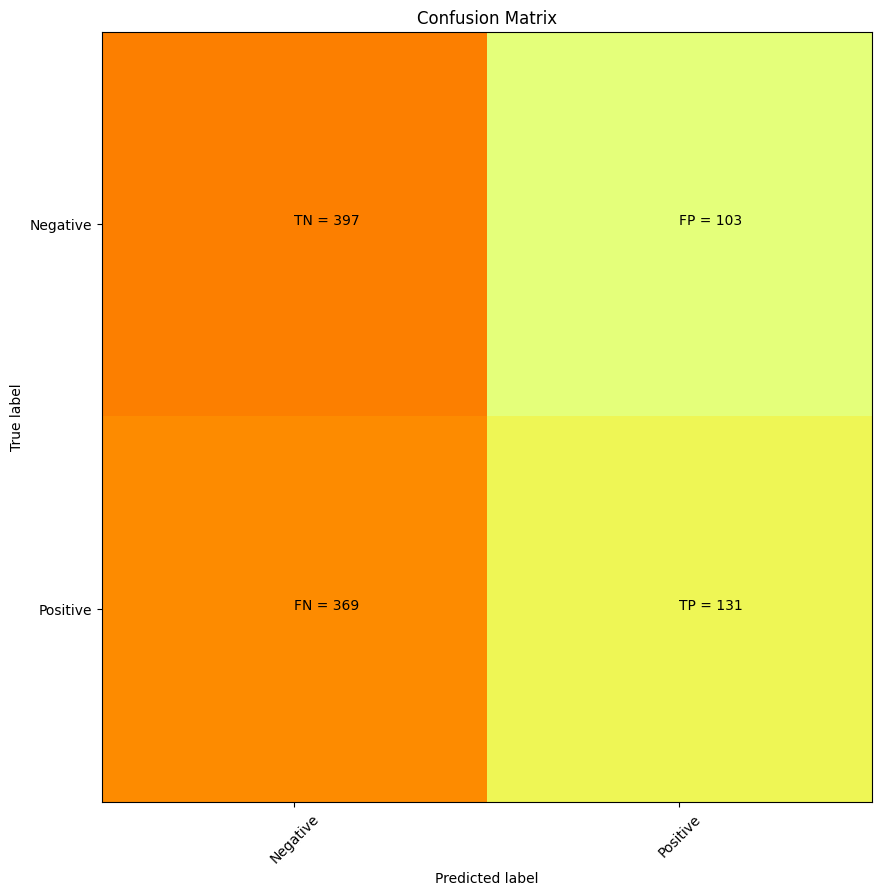

CCL22 precision = 0.5598290598290598 recall = 0.262


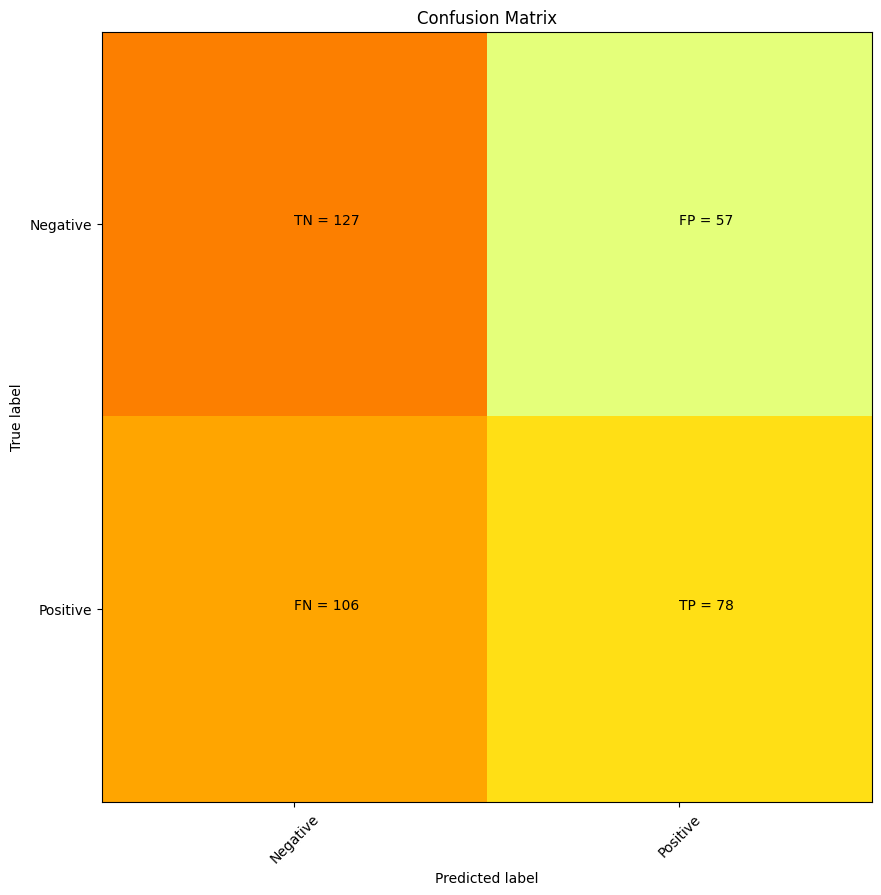

CCL4 precision = 0.5777777777777777 recall = 0.42391304347826086


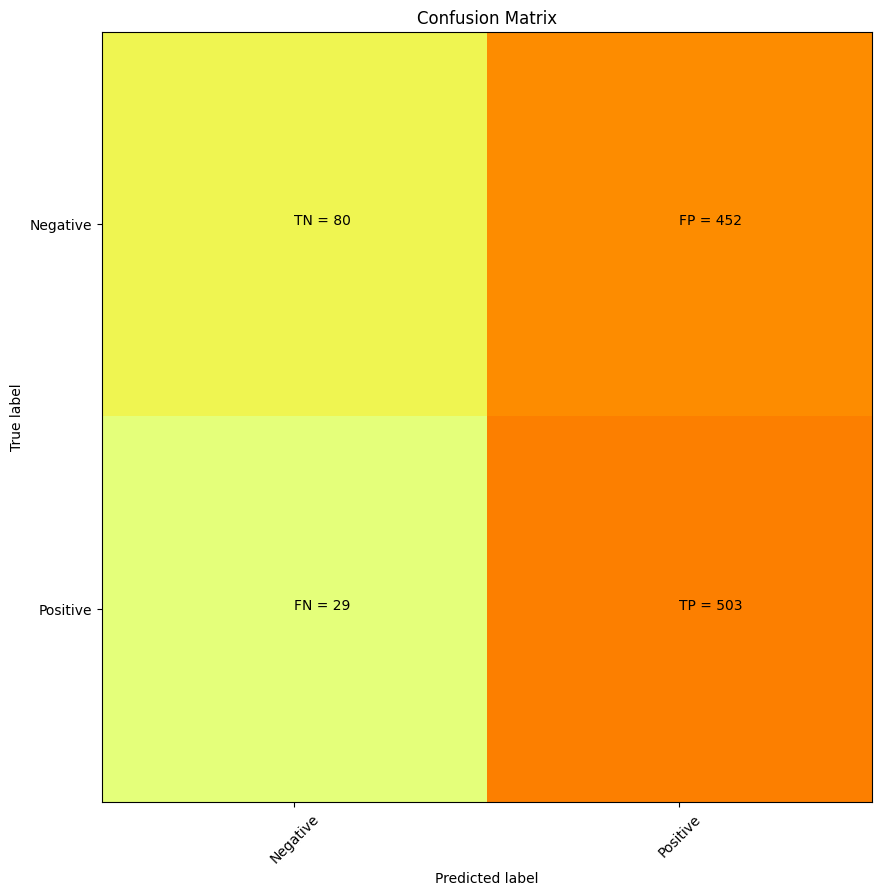

CCL5 precision = 0.5267015706806283 recall = 0.9454887218045113


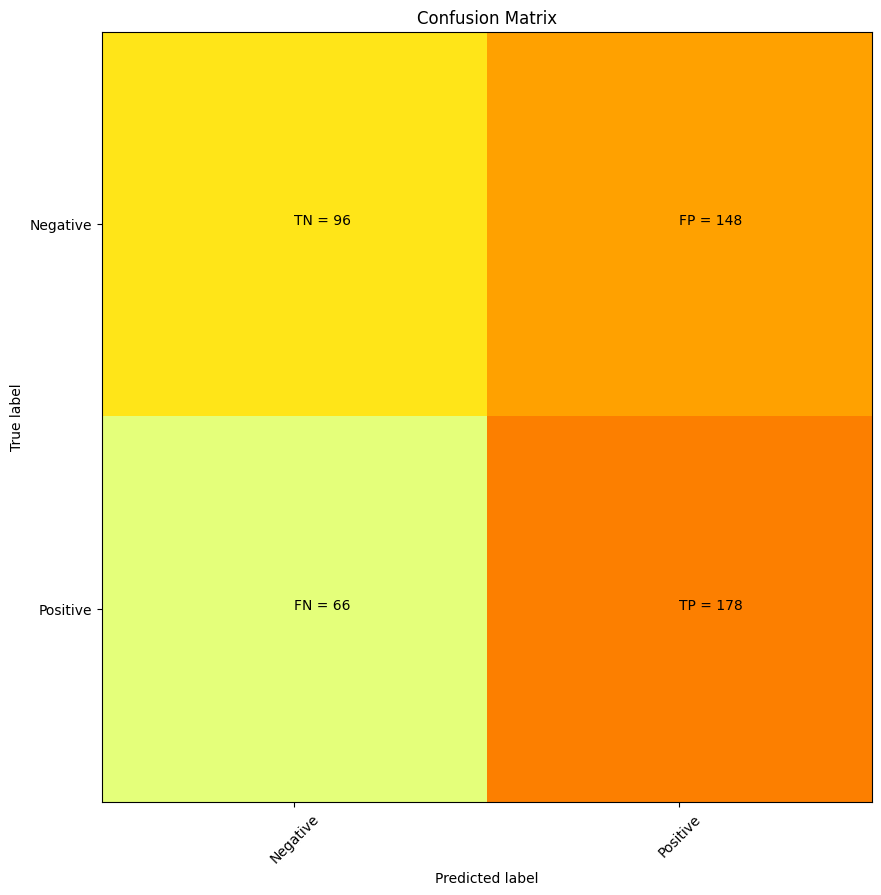

CD14 precision = 0.5460122699386503 recall = 0.7295081967213115


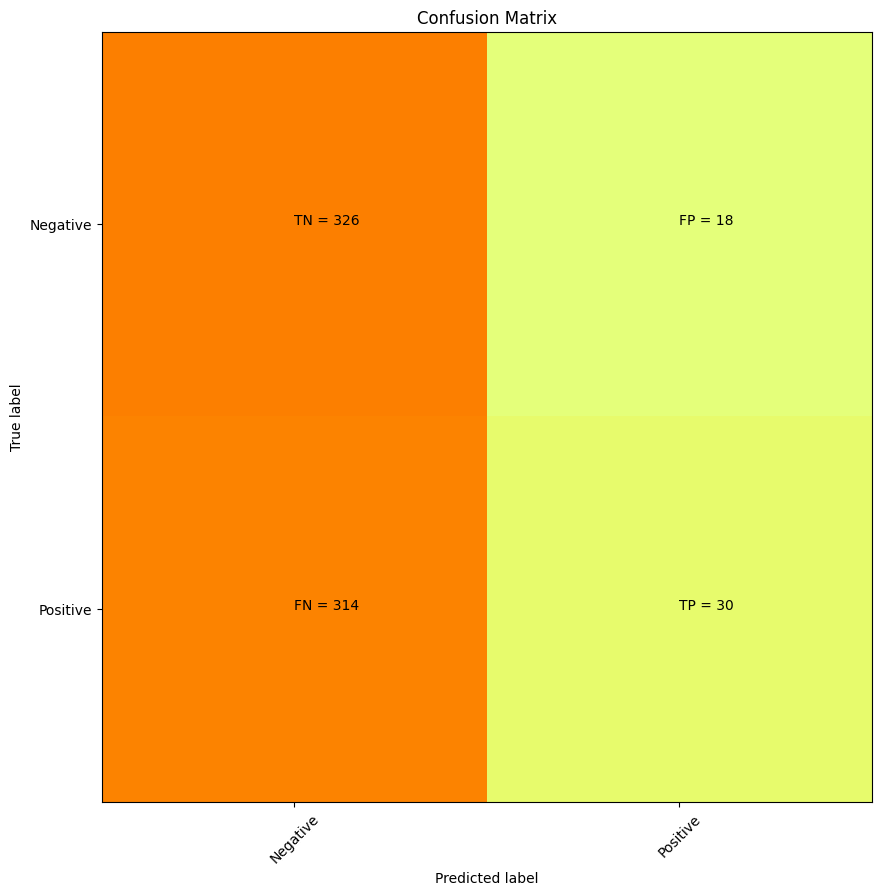

CRP precision = 0.625 recall = 0.0872093023255814


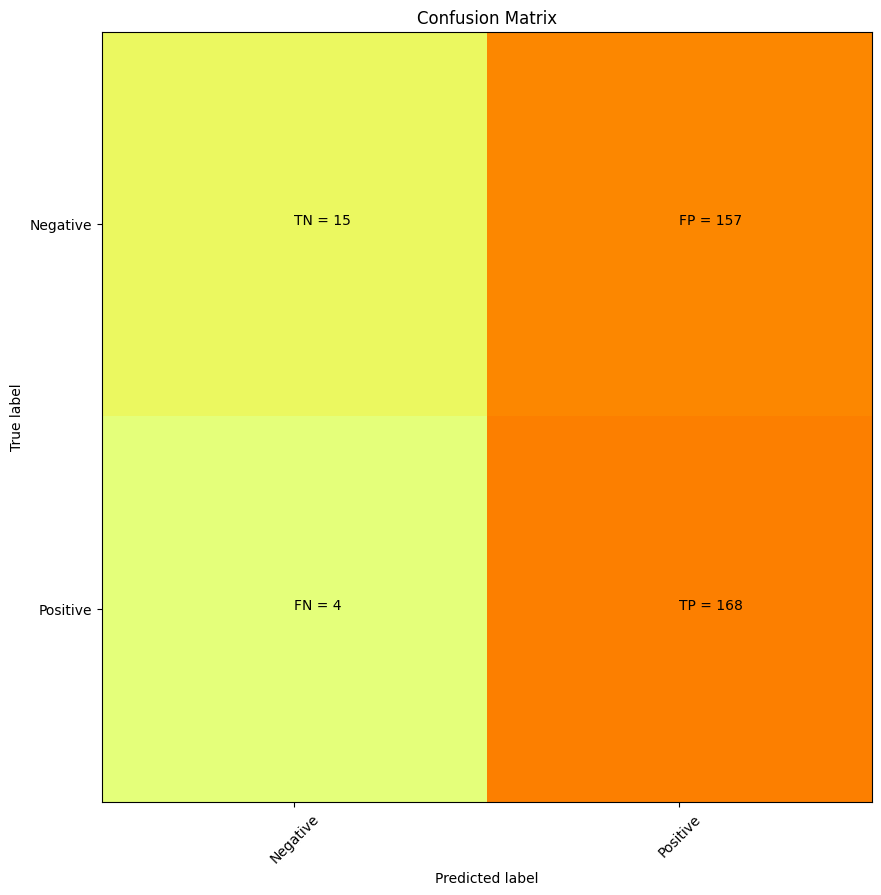

CXCL1 precision = 0.5169230769230769 recall = 0.9767441860465116


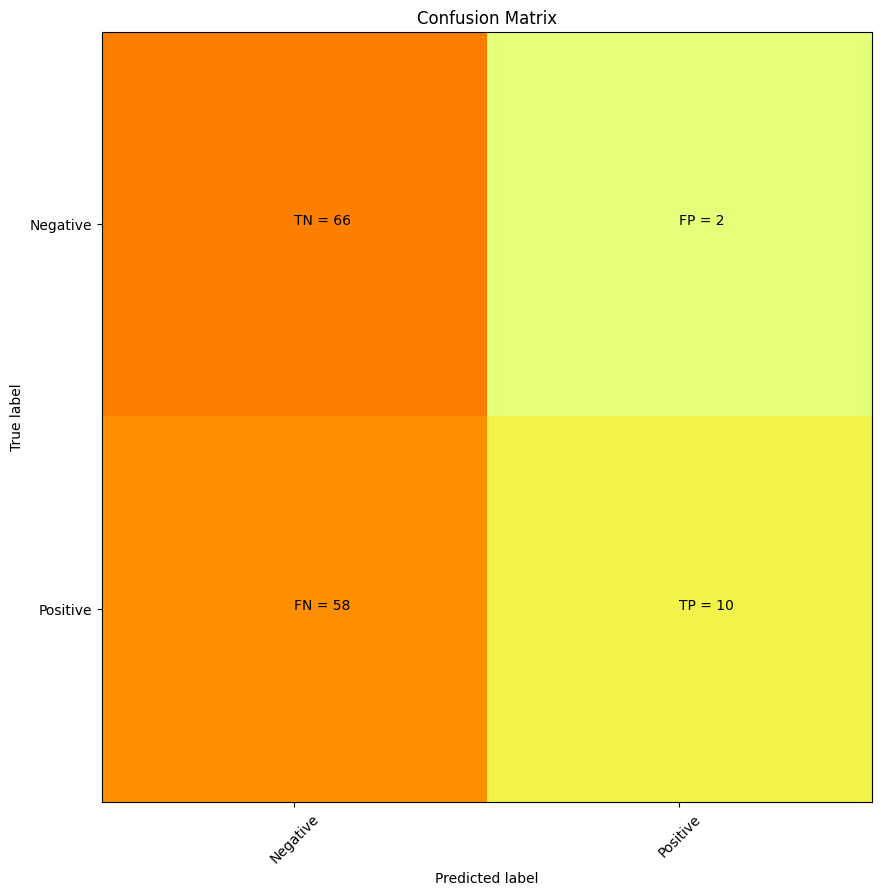

CXCL10 precision = 0.8333333333333334 recall = 0.14705882352941177


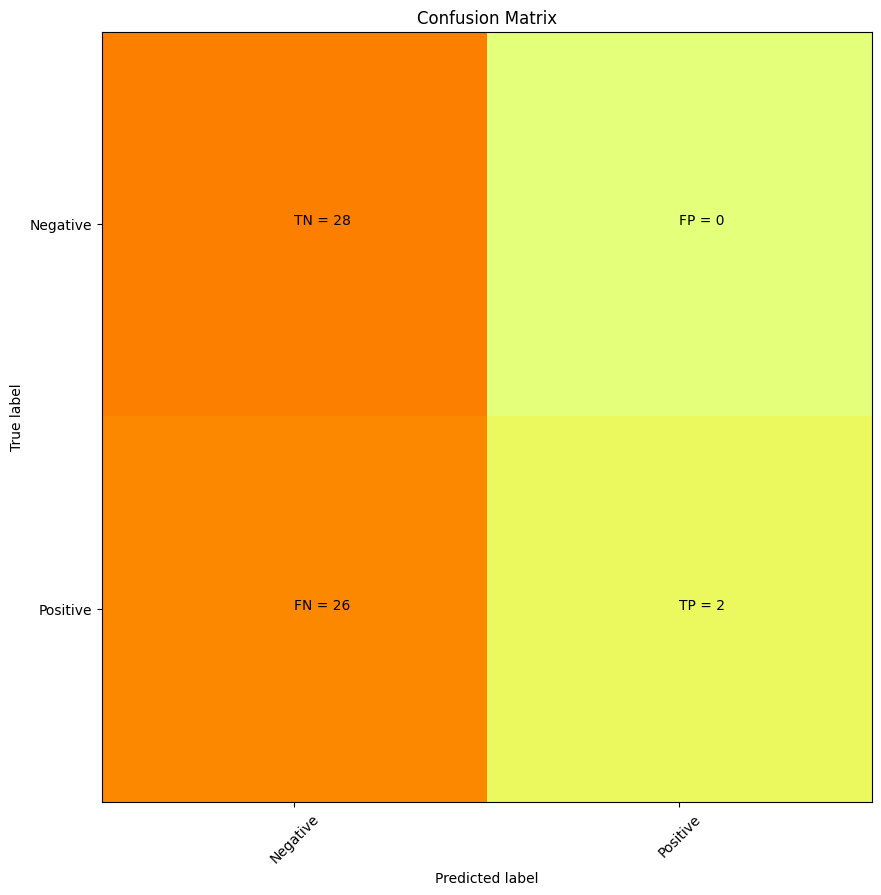

CXCL13 precision = 1.0 recall = 0.07142857142857142


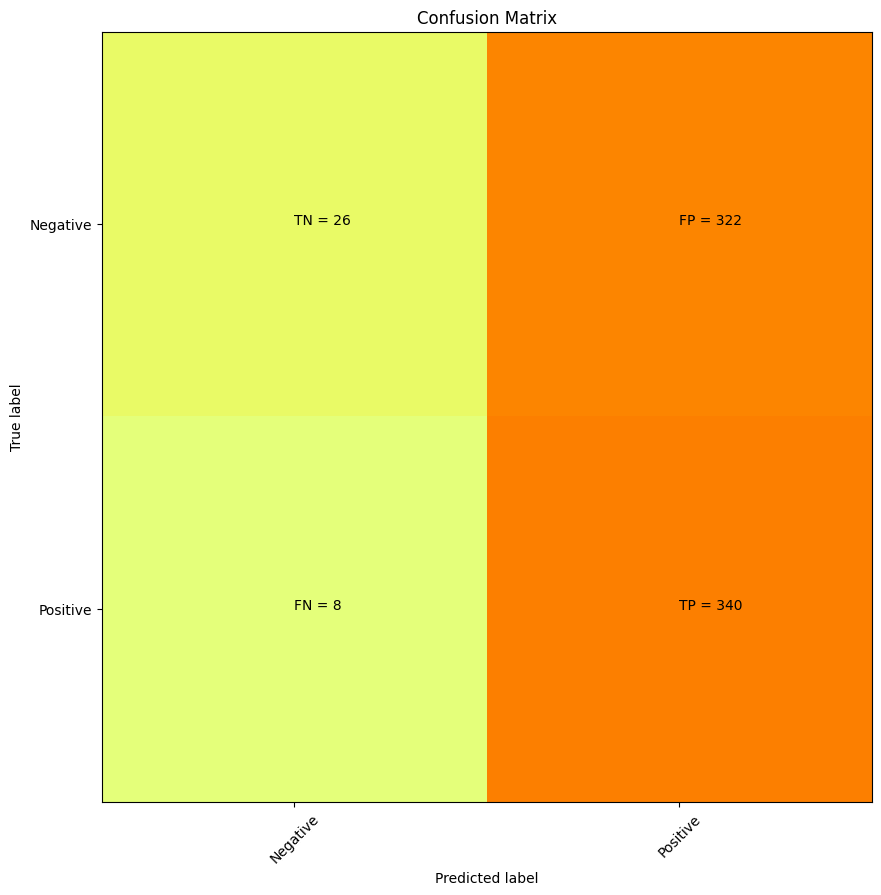

CXCL3 precision = 0.513595166163142 recall = 0.9770114942528736


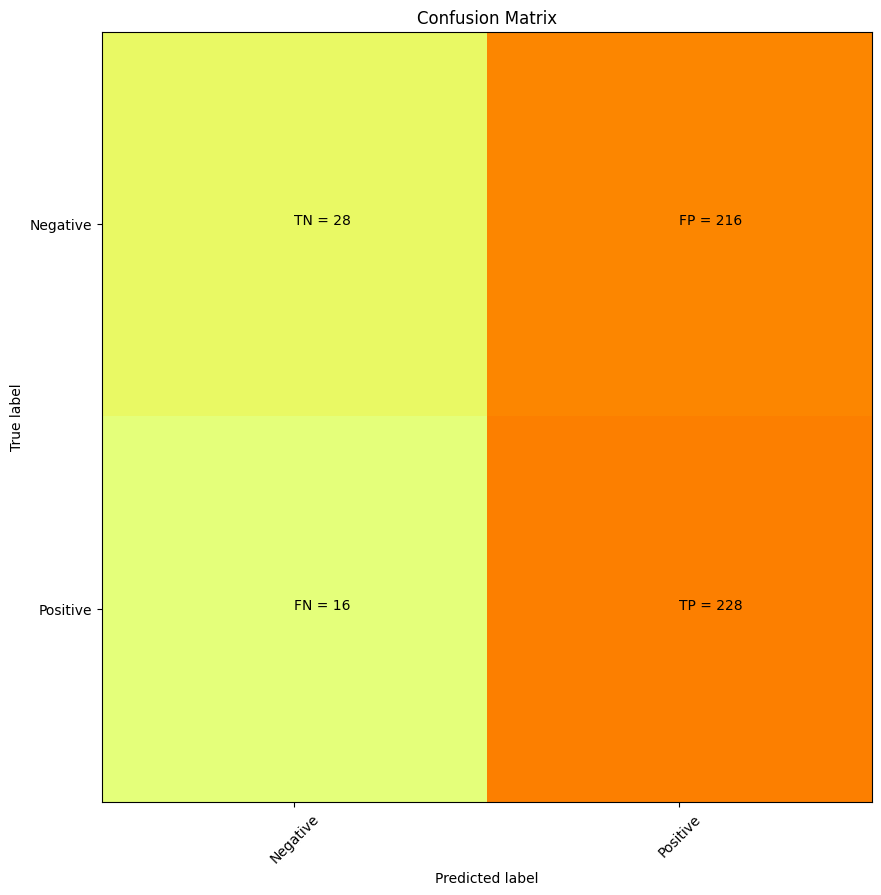

CXCL5 precision = 0.5135135135135135 recall = 0.9344262295081968


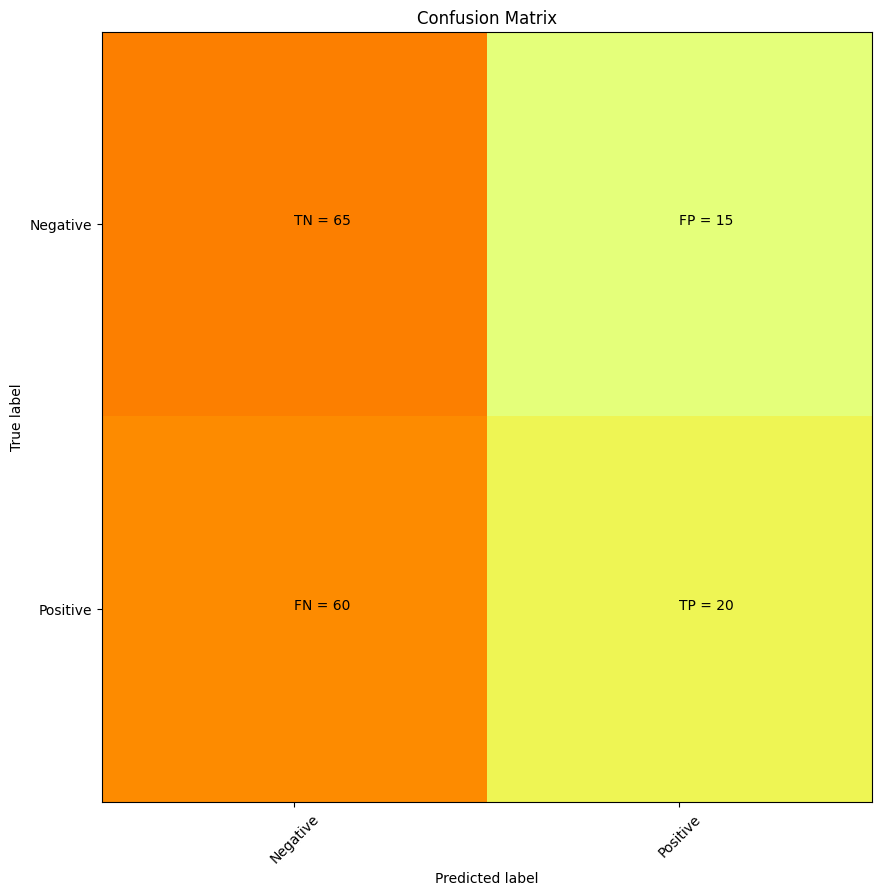

G-CSF precision = 0.5714285714285714 recall = 0.25


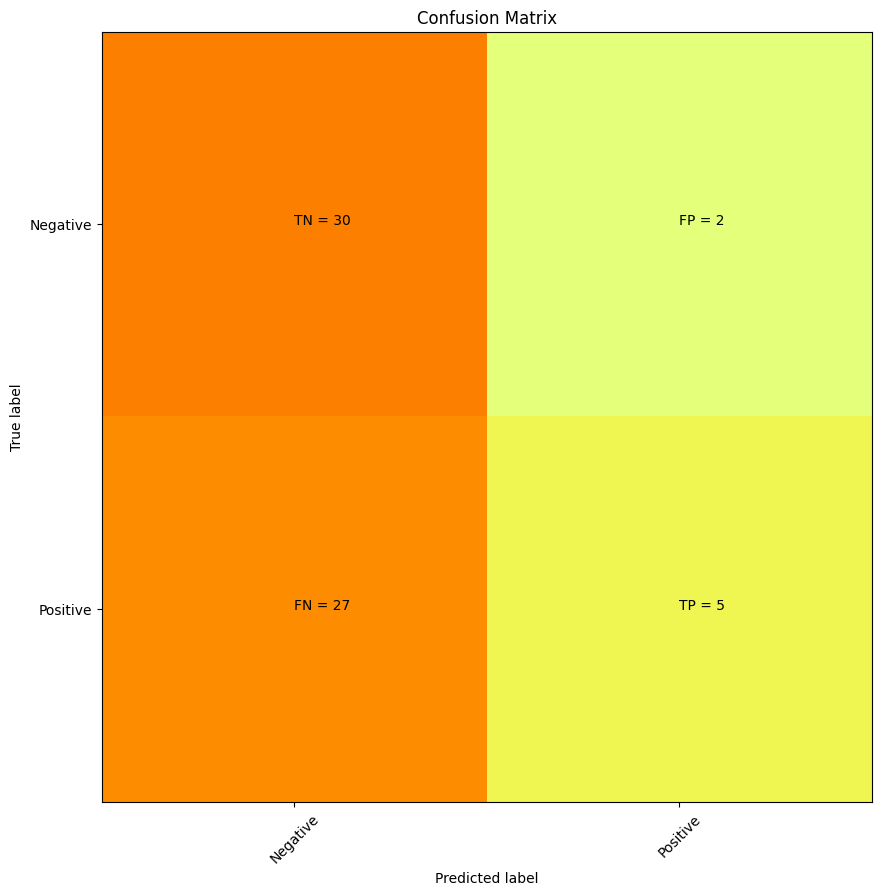

GM-CSF precision = 0.7142857142857143 recall = 0.15625


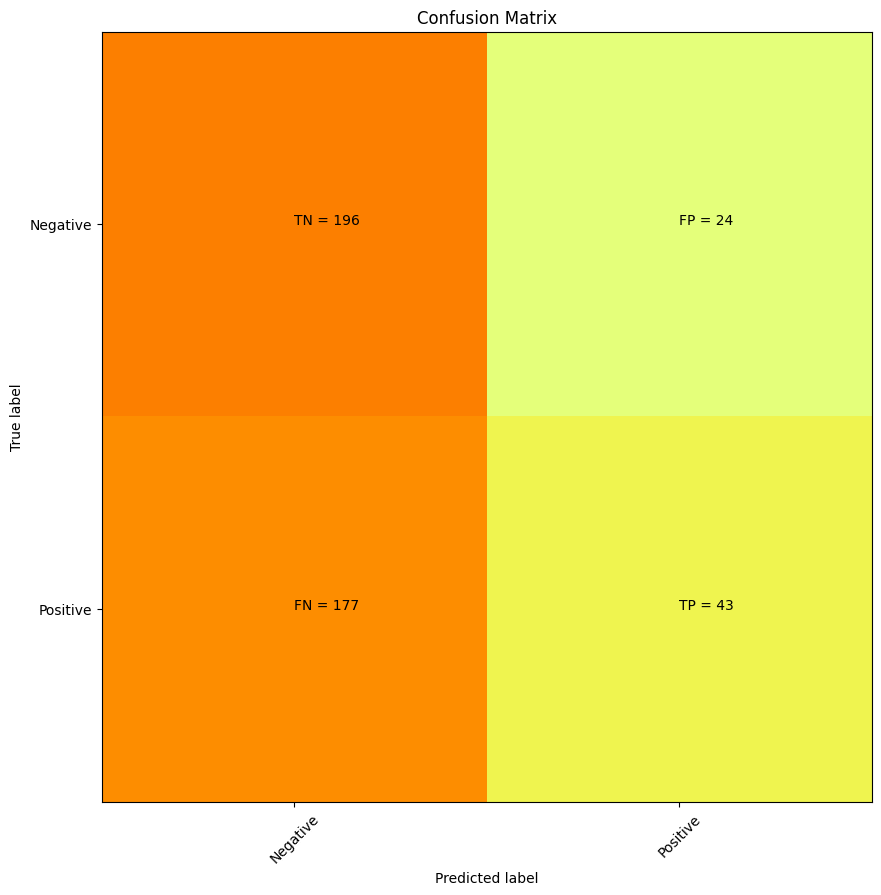

IL-1 alpha precision = 0.6417910447761194 recall = 0.19545454545454546


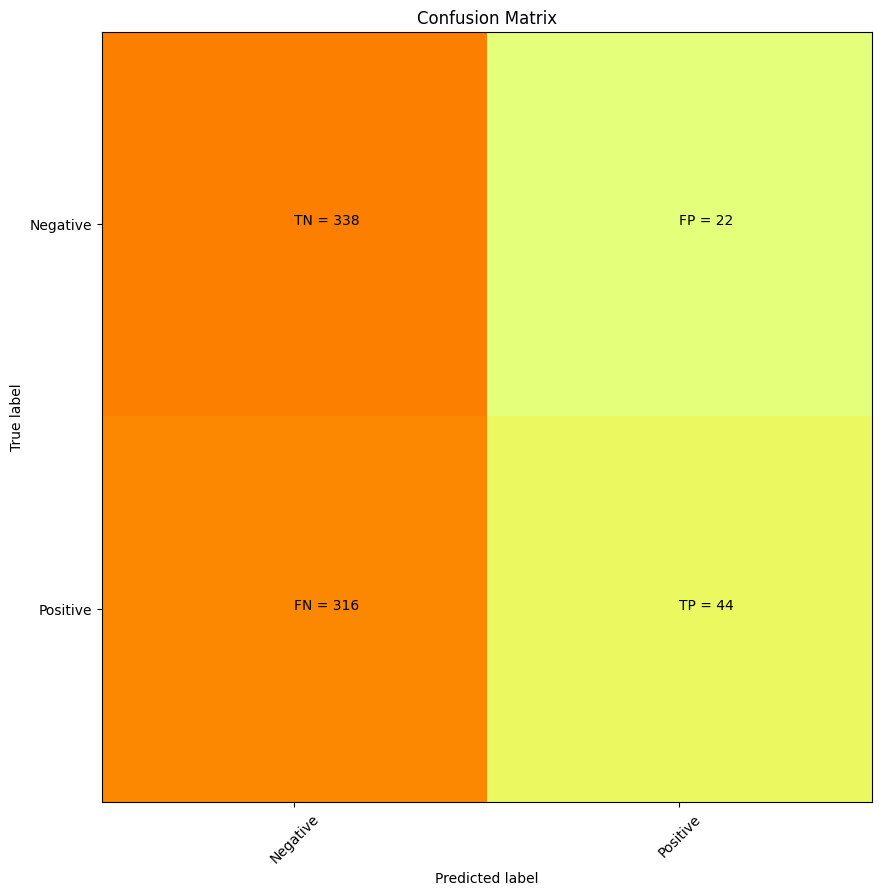

IL-1 beta precision = 0.6666666666666666 recall = 0.12222222222222222


<ipython-input-19-217dd9f1d6df>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos


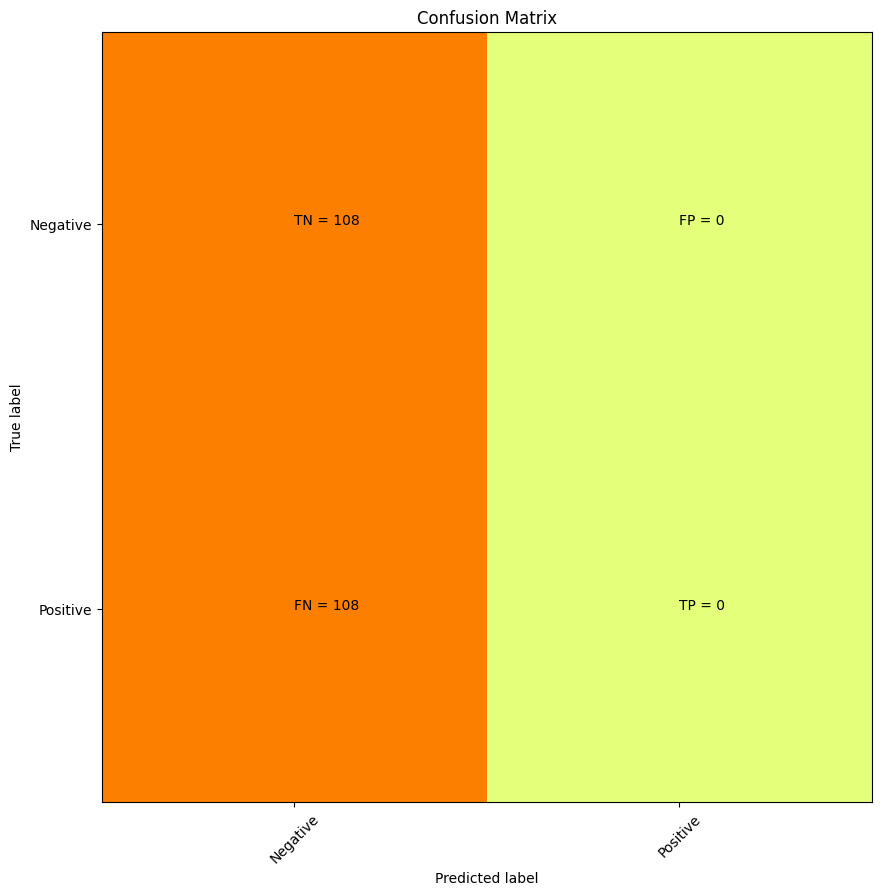

IL-12 p40 precision = nan recall = 0.0


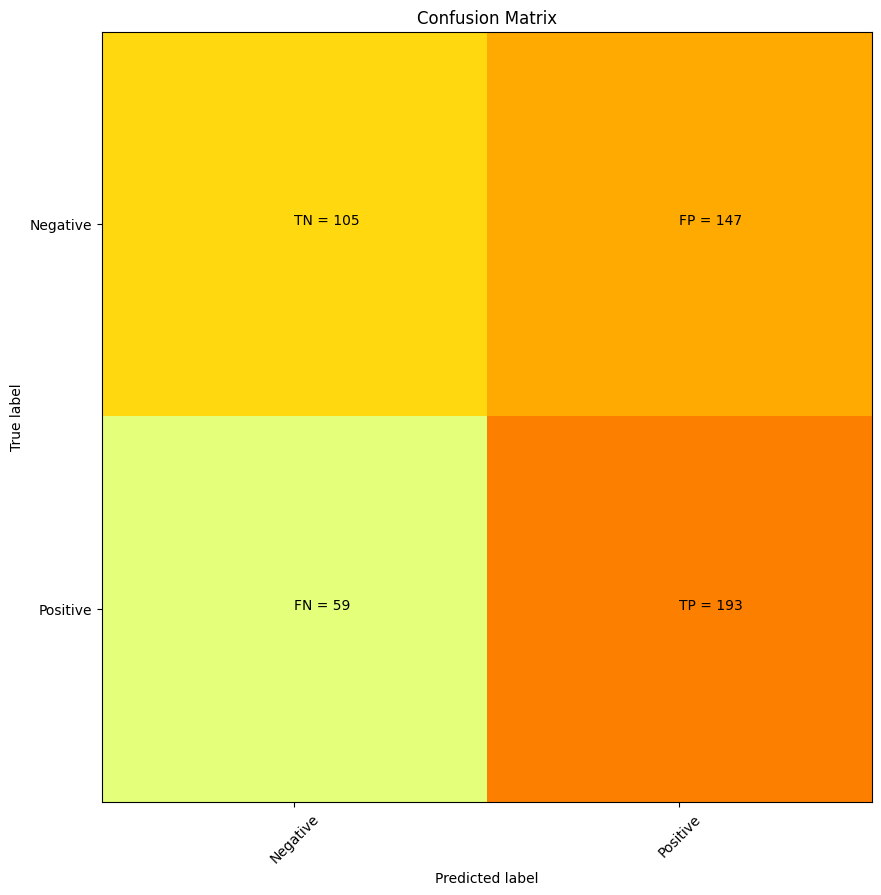

IL-16 precision = 0.5676470588235294 recall = 0.7658730158730159


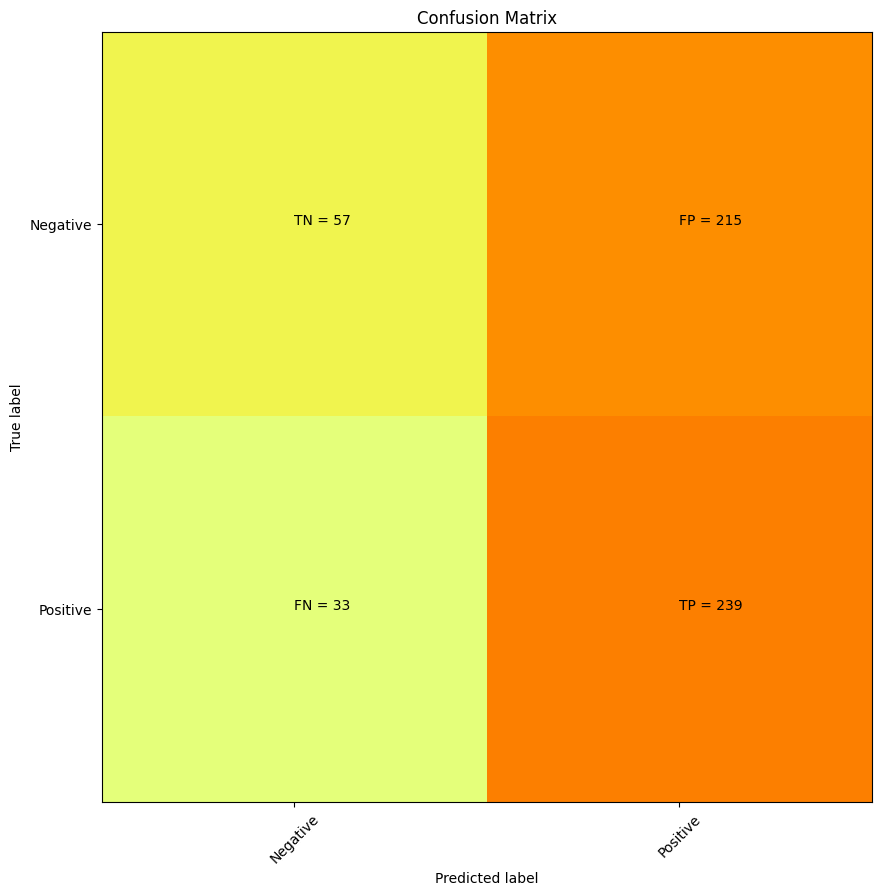

IL-6 R alpha precision = 0.526431718061674 recall = 0.8786764705882353


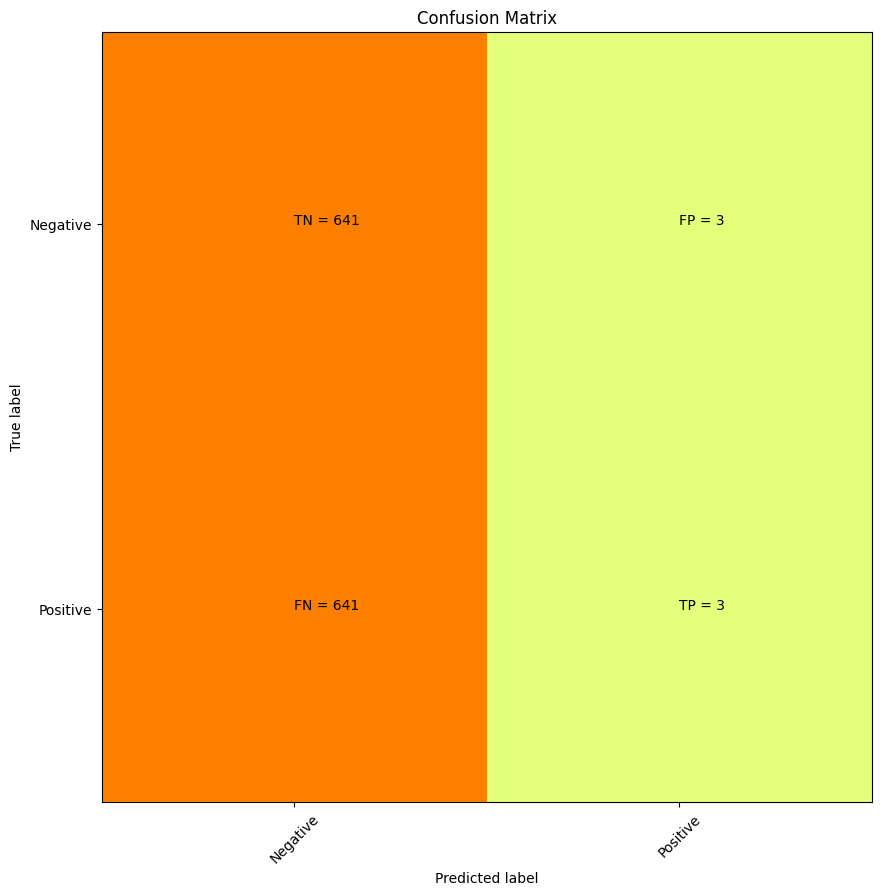

IL-6 precision = 0.5 recall = 0.004658385093167702


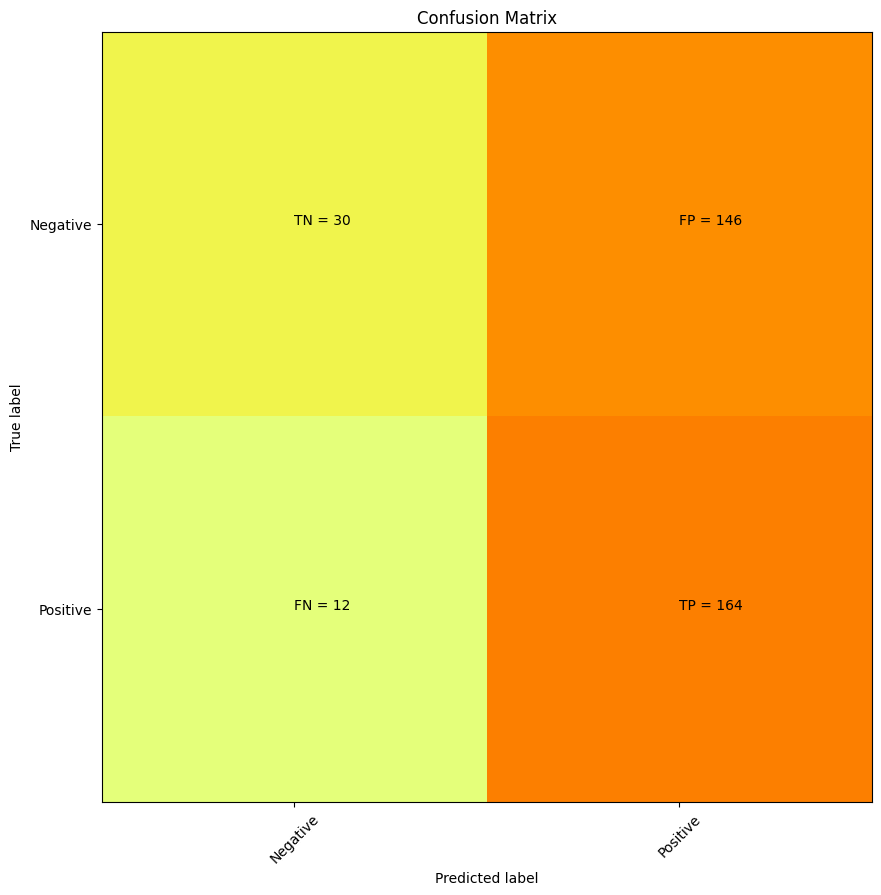

IL-8 precision = 0.5290322580645161 recall = 0.9318181818181818


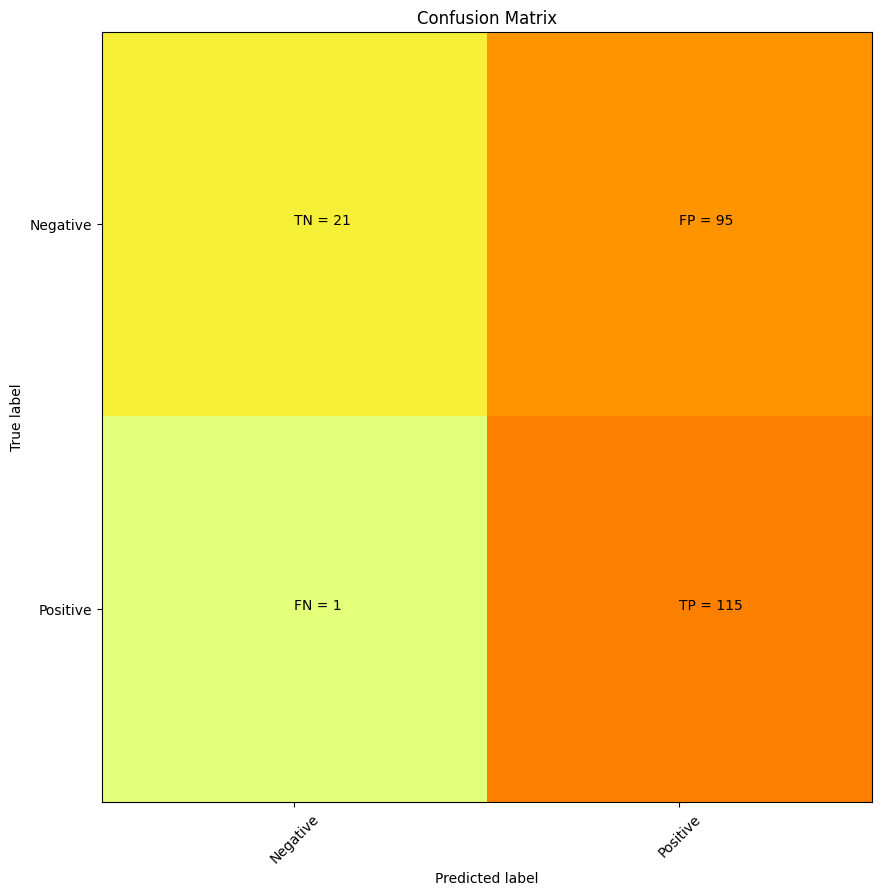

MMP-9 precision = 0.5476190476190477 recall = 0.9913793103448276


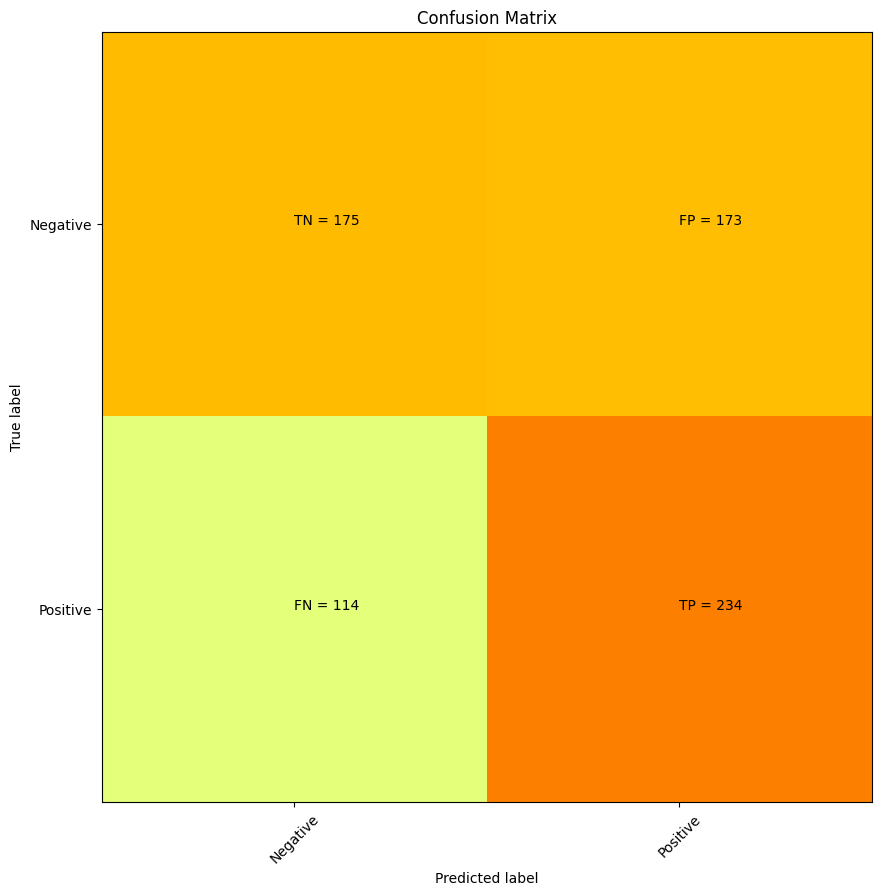

TNF RII precision = 0.5749385749385749 recall = 0.6724137931034483


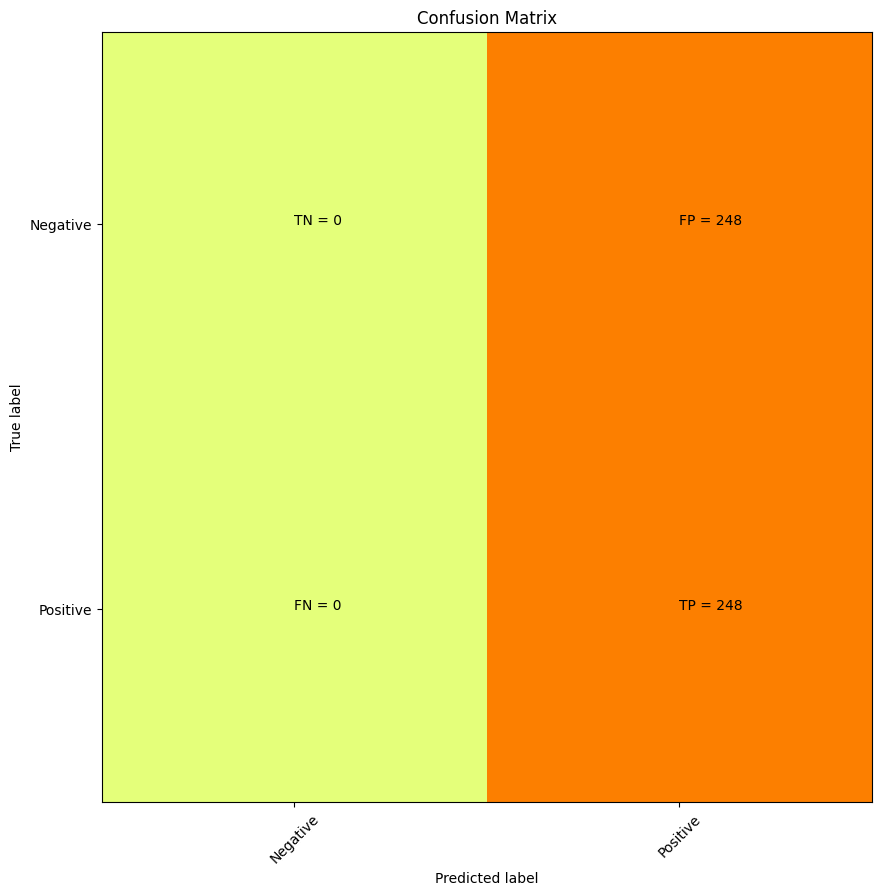

TNF alpha precision = 0.5 recall = 1.0


Cyotkine  Precision    Recall
0      Activin A   0.632184  0.292553
1           CCL1   0.524917  0.858696
2          CCL19   0.500000  1.000000
3           CCL2   0.526316  0.552632
4          CCL20   1.000000  0.008333
5          CCL22   0.559829  0.262000
6           CCL4   0.577778  0.423913
7           CCL5   0.526702  0.945489
8           CD14   0.546012  0.729508
9            CRP   0.625000  0.087209
10         CXCL1   0.516923  0.976744
11        CXCL10   0.833333  0.147059
12        CXCL13   1.000000  0.071429
13         CXCL3   0.513595  0.977011
14         CXCL5   0.513514  0.934426
15         G-CSF   0.571429  0.250000
16        GM-CSF   0.714286  0.156250
17    IL-1 alpha   0.641791  0.195455
18     IL-1 beta   0.666667  0.122222
19     IL-12 p40        NaN  0.000000
20         IL-16   0.567647  0.765873
21  IL-6 R alpha   0.526432  0.878676
22          IL-6   0.500000  0.004658
23          IL-8   0.529032  0.931818
24         MMP-9   0.547619  0.991379
25       TNF RII   0.574939  0.672414
26     TNF alpha   0.500000  1.000000

In [25]:
#make a summary for the performance for each cytokine for the original data with a vit

tracker = []

for i in range(len(longdfs)):

  target = list(longdfs[i].iloc[:,0:1].values)

  target2 = [target for j in range(4)]
#this is 2 arrays
#put them together without separation to match structure of features
  target2final = []
  for k in target2:
    target2final = target2final+k

  cytokine = totalresultsvit_1_answer[i][0]

  answer = totalresultsvit_1_answer[i][1]

  precision, recall = confusio_matrix(target2final, answer, cytokine)

  tracker.append([cytokine, precision, recall])

  totalvitsummary = pd.DataFrame(tracker, columns = ["Cyotkine", "Precision", "Recall"])


totalvitsummary

In [26]:
totalvitsummary[totalvitsummary["Precision"]>=0.65]

Cyotkine  Precision    Recall
4       CCL20   1.000000  0.008333
11     CXCL10   0.833333  0.147059
12     CXCL13   1.000000  0.071429
16     GM-CSF   0.714286  0.156250
18  IL-1 beta   0.666667  0.122222

In [27]:
totalvitsummary[totalvitsummary["Recall"]>=0.65]

Cyotkine  Precision    Recall
1           CCL1   0.524917  0.858696
2          CCL19   0.500000  1.000000
7           CCL5   0.526702  0.945489
8           CD14   0.546012  0.729508
10         CXCL1   0.516923  0.976744
13         CXCL3   0.513595  0.977011
14         CXCL5   0.513514  0.934426
20         IL-16   0.567647  0.765873
21  IL-6 R alpha   0.526432  0.878676
23          IL-8   0.529032  0.931818
24         MMP-9   0.547619  0.991379
25       TNF RII   0.574939  0.672414
26     TNF alpha   0.500000  1.000000

None! No cytokines come up as predictable  (Precision and recall >0.65) with the visual transformer!

We need more optimization - a much larger dataset. You can't just assume that using a visual transformer will improve your results!